In [1]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
using DiffEqFlux
using Optim
using ForwardDiff

In [2]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const * (M + M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [3]:
# function limit_func(param,pmin,pmax)
#     PL = pmax - pmin
#     offset = 0.5*(pmax + pmin)
#     PL/2 * (sin(pi * (param - offset)/PL) + 1) + pmin
# end
function limit_func(param,pmin,pmax)
    if pmin < param < pmax
        return param
    elseif param <= pmin
        return pmin
    else
        return pmax
    end
end

limit_func (generic function with 1 method)

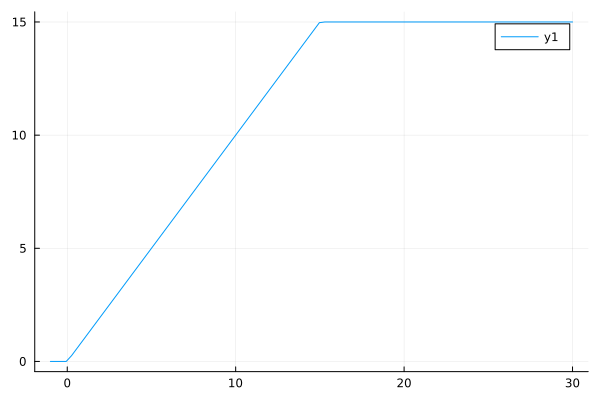

In [4]:
lims = (0,15)
tmpx = LinRange(lims[1]-1, 2*lims[2], 100)
plot(tmpx, [limit_func(x,lims[1],lims[2]) for x in tmpx])

In [8]:
#[Tᵣ, Tₐ, Tₚ, αmin, ϕ, f, A, Φ_ext, λ]
p = [2, 10, 10, 0.7, 0.5418, 0.9763*2.482542369189332, 1.01556/0.2949509890806259, 0.995pi, 0.05289]

function alpha(p, t)
    Tₐ = limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    αmin = limit_func(p[4],0.5,1)
    abs_slope = (1 - αmin)/Tₐ
    if t < Tₐ
        return 1 - abs_slope * t
    elseif t > Tₐ + Tₚ
        return αmin + abs_slope * (t - Tₐ - Tₚ)
    else
        return αmin
    end
end

dalphadp(p, t) = ForwardDiff.gradient(p̃ -> alpha(p̃,t), p)

function envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    if Tₐ < t < Tₐ + Tᵣ
        arg = pi / 2 * (t - Tₐ) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*pi/(2*Tᵣ)
    elseif Tₐ + Tᵣ < t < Tₐ + Tₚ - Tᵣ
        E *= 1
        Edot *= 0
    elseif Tₐ + Tₚ - Tᵣ < t < Tₐ + Tₚ
        arg = pi / 2 * (Tₐ + Tₚ - t) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*(-pi)/(2*Tᵣ)
    else
        E *= 0
        Edot *= 0
    end
    return (E, Edot)
end

function pulse(p, t)
    Tₐ = limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    Tᵣ = limit_func(p[1],0,Tₚ/2)
    # αmin = p[4]
    ϕ = p[5]
    f = p[6]
    A = p[7]
    # Φ_ext = p[8]
    λ = p[9]

    amp = pi * A / (Tₚ - Tᵣ)
    E = amp
    Edot = amp
    E, Edot = envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    arg = f*(t - Tₐ) + ϕ
    return E*cos(arg) + Edot*λ*sin(arg)
end

dpulsedp(p, t) = ForwardDiff.gradient(p̃ -> pulse(p̃, t), p)

dpulsedp (generic function with 2 methods)

In [7]:
# Es, ψs = eigs(KinPot12 + p[4] .* get_Pot3(p[8]), nev=2, which=:SR)
# ω_qubit = real(Es[2] - Es[1])
# overlap_scale = abs(ψs[:,2]' * chargecoupling * ψs[:,1])

# ω_qubit, overlap_scale

(2.482542369189332, 0.2949509890806259)

In [9]:
function augmented_H_int!(du, u, p, t)
    H = KinPot12 + alpha(p, t) .* Potential3
    V = chargecoupling
    hamil = H + pulse(p, t) .* V
    
    a = transpose(reshape(u[1:2*NHilbert],NHilbert,2))
    ψT = reshape(u[2*NHilbert+1:4*NHilbert],NHilbert,2)
    # a = reshape(u[1:NHilbert],1,:)
    # ψT = u[NHilbert+1:2*NHilbert]

    du[1:2*NHilbert] = reshape(transpose(im .* a * hamil),:)
    du[2*NHilbert+1:4*NHilbert] = reshape(-im .* hamil * ψT,:)
    # du[1:NHilbert] = im .* a * hamil
    # du[NHilbert+1:2*NHilbert] = -im .* hamil * ψT
    
    du[4*NHilbert+1:end] = 2*real(im * tr(a * V * ψT)) .* dpulsedp(p, t) + 2*real(im * tr(a * Potential3 * ψT)) .* dalphadp(p,t)
    # du[2*NHilbert+1:end] = 2*real(im * a * V * ψT) .* dpulsedp(p, t, ω_qubit, overlap_scale) + 2*real(im * a * Potential3 * ψT) .* dalphadp(p,t)
end

augmented_H_int! (generic function with 1 method)

In [10]:
#buffer = [ω_qubit, overlap_scale, Potential3, ψ1s, ψT]

ps = []

function H_int!(du, u, p, t)
    H = KinPot12 + alpha(p, t) .* Potential3
    V = pulse(p, t) .* chargecoupling
    du[:] = - im * (H + V) * u
end

E1s, ψ1s = eigs(KinPot12 + Potential3, nev=2, which=:SR)
# ψ1s
function calculate_common!(p, last_p, buffer)
    if p != last_p
        copy!(last_p, p)
        println(last_p)
        push!(ps,last_p)
        # buffer[3] = get_Pot3(0.995pi)#p[8])
        # Es, ψs = eigs(KinPot12 + p[4] .* buffer[3], nev=2, which=:SR)
        # buffer[1] = real(Es[2] - Es[1])
        # buffer[2] = abs(ψs[:,2]' * chargecoupling * ψs[:,1])

        
        # T = 30.0#p[3] + 2*p[2]
        forward_prob = ODEProblem(H_int!, ψ1s[:,1:2], (0.0, 30.0), p)
        sol = solve(forward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-10)
        buffer[5] = sol.u[end]
    end
end

function loss_func(buffer)
    UT = abs2.(ψ1s'*buffer[5])
    return 0.5 * (2 - UT[1,2] - UT[2,1])
end

function f(p, last_p, buffer)
    calculate_common!(p, last_p, buffer)
    loss_func(buffer)
end

function g!(storage, p, last_p, buffer)
    calculate_common!(p, last_p, buffer)
    ψT = buffer[5]
    a1 = - dropdims(ψT[:,1]'*ψ1s[:,2]*ψ1s[:,2]',dims=1)
    a2 = - dropdims(ψT[:,2]'*ψ1s[:,1]*ψ1s[:,1]',dims=1)

    u0_aug = cat(a1,a2,ψT[:,1],ψT[:,2],zeros(ComplexF64,length(p)),dims=1)
    # u0_aug = cat(a1,ψT[:,1],zeros(ComplexF64,length(p)),dims=1)
    aug_prob = ODEProblem(augmented_H_int!, u0_aug, (30.0,0.0), p)
    aug_sol = solve(aug_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-10)

    # push!(buffer,aug_sol)
    storage[:] = real(aug_sol.u[end][4*NHilbert+1:end])
    # storage[:] = real(aug_sol.u[end][2*NHilbert+1:end])
end

g! (generic function with 1 method)

In [15]:
initial_p = copy(p)
buffer = [nothing,nothing,nothing,nothing,zeros(ComplexF64,NHilbert,2)]
last_p = similar(initial_p);

In [12]:
f(initial_p,last_p,buffer)

[2.0, 10.0, 10.0, 0.7, 0.5418, 2.4237061150395447, 3.44314831140435, 3.1258846903218442, 0.05289]

2.9160349941548258e-5

In [13]:
storage = similar(last_p)
g!(storage,p,last_p,buffer)

9-element Vector{Float64}:
 -0.00020829402924519267
 -0.0010403115779957
  0.0
  0.006333617883784099
 -1.0514240677060915e-6
  0.00014907134967723841
  6.252990993973458e-7
  0.0
  2.3583571970825894e-5

In [16]:
res = optimize(p -> f(p, initial_p, buffer),
               (storage, p) -> g!(storage, p, last_p, buffer),
               initial_p,BFGS())

[2.0, 10.0, 10.0, 0.7, 0.5418, 2.4237061150395447, 3.44314831140435, 3.1258846903218442, 0.05289]


[2.000208294029245, 10.001040311577995, 10.0, 0.6936663821162159, 0.5418010514240676, 2.4235570436898675, 3.4431476861052506, 3.1258846903218442, 0.052866416428029174]


[2.000208294029245, 10.001040311577995, 10.0, 0.6936663821162159, 0.5418010514240676, 2.4235570436898675, 3.4431476861052506, 3.1258846903218442, 0.052866416428029174]


[2.000000029554387, 10.000000147607548, 10.0, 0.6999991013367313, 0.5418000001491842, 2.423706093888135, 3.443148311315628, 3.1258846903218442, 0.052889996653778255]


[2.000000029554387, 10.000000147607548, 10.0, 0.6999991013367313, 0.5418000001491842, 2.423706093888135, 3.443148311315628, 3.1258846903218442, 0.052889996653778255]


[2.0002182959277865, 10.001086153665996, 10.0, 0.6999822115179738, 0.5417990386589319, 2.4239408550483112, 3.44314333450006, 3.1258846903218442, 0.052926321023063605]


[2.0002182959277865, 10.001086153665996, 10.0, 0.6999822115179738, 0.5417990386589319, 2.4239408550483112, 3.44314333450006, 3.1258846903218442, 0.052926321023063605]


[2.0010913614213854, 10.00543017789979, 10.0, 0.6999146522429439, 0.5417951926979229, 2.424879899689015, 3.4431234272377886, 3.1258846903218442, 0.053071618500204996]


[2.0010913614213854, 10.00543017789979, 10.0, 0.6999146522429439, 0.5417951926979229, 2.424879899689015, 3.4431234272377886, 3.1258846903218442, 0.053071618500204996]


[2.0007993054849194, 10.003977024528211, 10.0, 0.6999372520220905, 0.541796479240287, 2.4245657725542986, 3.443130086571101, 3.1258846903218442, 0.053023013909754675]


[2.0007993054849194, 10.003977024528211, 10.0, 0.6999372520220905, 0.541796479240287, 2.4245657725542986, 3.443130086571101, 3.1258846903218442, 0.053023013909754675]


[2.0015343112395216, 10.007015417067663, 10.0, 0.6999404313415071, 0.5420073429328571, 2.4244160138620714, 3.4415339649593264, 3.1258846903218442, 0.0527713658474211]


[2.0015343112395216, 10.007015417067663, 10.0, 0.6999404313415071, 0.5420073429328571, 2.4244160138620714, 3.4415339649593264, 3.1258846903218442, 0.0527713658474211]


[2.00447433425793, 10.019168987225473, 10.0, 0.6999531486191737, 0.5428507977031377, 2.423816979093163, 3.435149478512227, 3.1258846903218442, 0.05176477359808681]


[2.00447433425793, 10.019168987225473, 10.0, 0.6999531486191737, 0.5428507977031377, 2.423816979093163, 3.435149478512227, 3.1258846903218442, 0.05176477359808681]


[2.0027477346780396, 10.01203150939035, 10.0, 0.6999456800904789, 0.5423554585024225, 2.424168776740277, 3.438898922495609, 3.1258846903218442, 0.05235591922651867]


[2.0027477346780396, 10.01203150939035, 10.0, 0.6999456800904789, 0.5423554585024225, 2.424168776740277, 3.438898922495609, 3.1258846903218442, 0.05235591922651867]


[2.002746693558037, 10.011966421469044, 10.0, 0.6999389896804536, 0.5423860977457319, 2.424267539585113, 3.43885897739715, 3.1258846903218442, 0.05237677559956264]


[2.002746693558037, 10.011966421469044, 10.0, 0.6999389896804536, 0.5423860977457319, 2.424267539585113, 3.43885897739715, 3.1258846903218442, 0.05237677559956264]


[2.002742529078027, 10.011706069783816, 10.0, 0.699912228040353, 0.5425086547189693, 2.4246625909644575, 3.4386991970033143, 3.1258846903218442, 0.052460201091738524]


[2.002742529078027, 10.011706069783816, 10.0, 0.699912228040353, 0.5425086547189693, 2.4246625909644575, 3.4386991970033143, 3.1258846903218442, 0.052460201091738524]


[2.0027436230676177, 10.011774462964427, 10.0, 0.6999192581991294, 0.542476459570325, 2.4245588127987263, 3.4387411705719666, 3.1258846903218442, 0.05243828560173922]


[2.0027436230676177, 10.011774462964427, 10.0, 0.6999192581991294, 0.542476459570325, 2.4245588127987263, 3.4387411705719666, 3.1258846903218442, 0.05243828560173922]


[2.0027875595065927, 10.01176233162701, 10.0, 0.6998977499088788, 0.5425947717272547, 2.4249129005941072, 3.438526974492107, 3.1258846903218442, 0.05250770249718426]


[2.0027875595065927, 10.01176233162701, 10.0, 0.6998977499088788, 0.5425947717272547, 2.4249129005941072, 3.438526974492107, 3.1258846903218442, 0.05250770249718426]


[2.0029633052624933, 10.01171380627734, 10.0, 0.6998117167478761, 0.5430680203549733, 2.426329251775631, 3.437670190172669, 3.1258846903218442, 0.05278537007896443

]
[2.0029633052624933, 10.01171380627734, 10.0, 0.6998117167478761, 0.5430680203549733, 2.426329251775631, 3.437670190172669, 3.1258846903218442, 0.05278537007896443]


[2.0038420340419956, 10.011471179528996, 10.0, 0.6993815509428634, 0.5454342634935663, 2.4334110076832505, 3.433386268575479, 3.1258846903218442, 0.05417370798786525]


[2.0038420340419956, 10.011471179528996, 10.0, 0.6993815509428634, 0.5454342634935663, 2.4334110076832505, 3.433386268575479, 3.1258846903218442, 0.05417370798786525]


[2.0031376476524474, 10.011665668412553, 10.0, 0.6997263705793291, 0.5435374899952289, 2.4277342931021555, 3.4368202474519425, 3.1258846903218442, 0.05306082042809149]


[2.0031376476524474, 10.011665668412553, 10.0, 0.6997263705793291, 0.5435374899952289, 2.4277342931021555, 3.4368202474519425, 3.1258846903218442, 0.05306082042809149]


[2.0031302731092056, 10.011575140831741, 10.0, 0.6997162088342926, 0.5435964557134718, 2.427897636426716, 3.436741348042255, 3.1258846903218442, 0.053118628028528514]


[2.0031302731092056, 10.011575140831741, 10.0, 0.6997162088342926, 0.5435964557134718, 2.427897636426716, 3.436741348042255, 3.1258846903218442, 0.053118628028528514]


[2.003100774936238, 10.011213030508497, 10.0, 0.6996755618541469, 0.5438323185864433, 2.4285510097249583, 3.4364257504035054, 3.1258846903218442, 0.05334985843027661]


[2.003100774936238, 10.011213030508497, 10.0, 0.6996755618541469, 0.5438323185864433, 2.4285510097249583, 3.4364257504035054, 3.1258846903218442, 0.05334985843027661]


[2.0031276774718516, 10.011543277601353, 10.0, 0.6997126321782022, 0.5436172100321955, 2.4279551288056838, 3.4367135776097975, 3.1258846903218442, 0.05313897472148634]


[2.0031276774718516, 10.011543277601353, 10.0, 0.6997126321782022, 0.5436172100321955, 2.4279551288056838, 3.4367135776097975, 3.1258846903218442, 0.05313897472148634]


[2.003114898474515, 10.01154513869995, 10.0, 0.6997127037342438, 0.5436239356682107, 2.427948755683433, 3.4367107580356566, 3.1258846903218442, 0.053167694818181094]


[2.003114898474515, 10.01154513869995, 10.0, 0.6997127037342438, 0.5436239356682107, 2.427948755683433, 3.4367107580356566, 3.1258846903218442, 0.053167694818181094]


[2.003063782485167, 10.011552583094332, 10.0, 0.69971298995841, 0.5436508382122711, 2.427923263194429, 3.4366994797390924, 3.1258846903218442, 0.0532825752049601]


[2.003063782485167, 10.011552583094332, 10.0, 0.69971298995841, 0.5436508382122711, 2.427923263194429, 3.4366994797390924, 3.1258846903218442, 0.0532825752049601]


[2.002808202538429, 10.011589805066249, 10.0, 0.6997144210792411, 0.5437853509325733, 2.4277958007494105, 3.436643088256272, 3.1258846903218442, 0.05385697713885516]


[2.002808202538429, 10.011589805066249, 10.0, 0.6997144210792411, 0.5437853509325733, 2.4277958007494105, 3.436643088256272, 3.1258846903218442, 0.05385697713885516]


[2.0015303028047398, 10.011775914925833, 10.0, 0.6997215766833965, 0.5444579145340841, 2.427158488524318, 3.4363611308421715, 3.1258846903218442, 0.05672898680833041]


[2.0015303028047398, 10.011775914925833, 10.0, 0.6997215766833965, 0.5444579145340841, 2.427158488524318, 3.4363611308421715, 3.1258846903218442, 0.05672898680833041]


[2.0025252264720415, 10.011631016934906, 10.0, 0.6997160056047427, 0.5439342823372318, 2.4276546753529784, 3.4365806520589497, 3.1258846903218442, 0.05449295035136212]


[2.0025252264720415, 10.011631016934906, 10.0, 0.6997160056047427, 0.5439342823372318, 2.4276546753529784, 3.4365806520589497, 3.1258846903218442, 0.05449295035136212]


[2.0020904827862718, 10.011700299101182, 10.0, 0.6997094594058968, 0.5442402665489662, 2.4276054670930955, 3.4363574820253175, 3.1258846903218442, 0.055560265934477555]


[2.0020904827862718, 10.011700299101182, 10.0, 0.6997094594058968, 0.5442402665489662, 2.4276054670930955, 3.4363574820253175, 3.1258846903218442, 0.055560265934477555]


[2.0003515080431926, 10.011977427766286, 10.0, 0.6996832746105135, 0.5454642033959035, 2.427408634053564, 3.435464801890789, 3.1258846903218442, 0.05982952826693931]


[2.0003515080431926, 10.011977427766286, 10.0, 0.6996832746105135, 0.5454642033959035, 2.427408634053564, 3.435464801890789, 3.1258846903218442, 0.05982952826693931]


[2.0007284922711546, 10.01191735033487, 10.0, 0.6996889510902388, 0.5451988718324906, 2.4274513045706265, 3.4356583218557404, 3.1258846903218442, 0.05890401478793397]


[2.0007284922711546, 10.01191735033487, 10.0, 0.6996889510902388, 0.5451988718324906, 2.4274513045706265, 3.4356583218557404, 3.1258846903218442, 0.05890401478793397]


[2.0007452799828815, 10.011904618344069, 10.0, 0.699689483829716, 0.545190511398711, 2.4274521972348047, 3.4356611621622926, 3.1258846903218442, 0.058851326407677367]


[2.0007452799828815, 10.011904618344069, 10.0, 0.699689483829716, 0.545190511398711, 2.4274521972348047, 3.4356611621622926, 3.1258846903218442, 0.058851326407677367]


[2.00081243082979, 10.011853690380859, 10.0, 0.699691614787625, 0.5451570696635927, 2.427455767891517, 3.435672523388502, 3.1258846903218442, 0.058640572886650956]


[2.00081243082979, 10.011853690380859, 10.0, 0.699691614787625, 0.5451570696635927, 2.427455767891517, 3.435672523388502, 3.1258846903218442, 0.058640572886650956]


[2.000746953869312, 10.011903348849632, 10.0, 0.6996895369486519, 0.5451896777879794, 2.4274522862414827, 3.4356614453665, 3.1258846903218442, 0.05884607290045872]


[2.000746953869312, 10.011903348849632, 10.0, 0.6996895369486519, 0.5451896777879794, 2.4274522862414827, 3.4356614453665, 3.1258846903218442, 0.05884607290045872]


[2.0007419717886803, 10.011903849292084, 10.0, 0.6996895260321248, 0.5451953975522268, 2.4274520044851533, 3.435661261330627, 3.1258846903218442, 0.05884928954183433]


[2.0007419717886803, 10.011903849292084, 10.0, 0.6996895260321248, 0.5451953975522268, 2.4274520044851533, 3.435661261330627, 3.1258846903218442, 0.05884928954183433]


[2.0007220434661543, 10.011905851061895, 10.0, 0.6996894823660165, 0.5452182766092162, 2.427450877459835, 3.435660525187134, 3.1258846903218442, 0.05886215610733679]


[2.0007220434661543, 10.011905851061895, 10.0, 0.6996894823660165, 0.5452182766092162, 2.427450877459835, 3.435660525187134, 3.1258846903218442, 0.05886215610733679]


[2.000622401853524, 10.011915859910951, 10.0, 0.6996892640354746, 0.545332671894163, 2.4274452423332433, 3.435656844469671, 3.1258846903218442, 0.05892648893484906]


[2.000622401853524, 10.011915859910951, 10.0, 0.6996892640354746, 0.545332671894163, 2.4274452423332433, 3.435656844469671, 3.1258846903218442, 0.05892648893484906]


[2.0001241937903727, 10.011965904156225, 10.0, 0.6996881723827657, 0.5459046483188973, 2.4274170667002863, 3.4356384408823546, 3.1258846903218442, 0.05924815307241042]


[2.0001241937903727, 10.011965904156225, 10.0, 0.6996881723827657, 0.5459046483188973, 2.4274170667002863, 3.4356384408823546, 3.1258846903218442, 0.05924815307241042]


[1.9976331534746155, 10.012216125382599, 10.0, 0.6996827141192209, 0.5487645304425686, 2.4272761885355014, 3.435546422945772, 3.1258846903218442, 0.06085647376021722]


[1.9976331534746155, 10.012216125382599, 10.0, 0.6996827141192209, 0.5487645304425686, 2.4272761885355014, 3.435546422945772, 3.1258846903218442, 0.06085647376021722]


[1.999694227446978, 10.01200909362412, 10.0, 0.6996872302584641, 0.5463982786513637, 2.427392750406008, 3.435622558114232, 3.1258846903218442, 0.05952575747759323]


[1.999694227446978, 10.01200909362412, 10.0, 0.6996872302584641, 0.5463982786513637, 2.427392750406008, 3.435622558114232, 3.1258846903218442, 0.05952575747759323]


[1.9989741404244556, 10.012183719126838, 10.0, 0.6996914858381006, 0.5474194819799616, 2.4273631338943127, 3.4357626400780275, 3.1258846903218442, 0.05930614645546811]


[1.9989741404244556, 10.012183719126838, 10.0, 0.6996914858381006, 0.5474194819799616, 2.4273631338943127, 3.4357626400780275, 3.1258846903218442, 0.05930614645546811]


[1.9960937923343658, 10.012882221137708, 10.0, 0.6997085081566463, 0.5515042952943533, 2.42724466784753, 3.4363229679332083, 3.1258846903218442, 0.058427702366967635]


[1.9960937923343658, 10.012882221137708, 10.0, 0.6997085081566463, 0.5515042952943533, 2.42724466784753, 3.4363229679332083, 3.1258846903218442, 0.058427702366967635]


[1.981692051883917, 10.016374731192062, 10.0, 0.699793619749375, 0.5719283618663116, 2.4266523376136186, 3.4391246072091124, 3.1258846903218442, 0.05403548192446527]


[1.981692051883917, 10.016374731192062, 10.0, 0.699793619749375, 0.5719283618663116, 2.4266523376136186, 3.4391246072091124, 3.1258846903218442, 0.05403548192446527]


[1.909683349631673, 10.033837281463825, 10.0, 0.7002191777130184, 0.6740486947261033, 2.423690686444061, 3.4531328035886335, 3.1258846903218442, 0.032074379711953434]


[1.909683349631673, 10.033837281463825, 10.0, 0.7002191777130184, 0.6740486947261033, 2.423690686444061, 3.4531328035886335, 3.1258846903218442, 0.032074379711953434

]
[1.9298467900797336, 10.02894752395587, 10.0, 0.7001000155508249, 0.6454535779450565, 2.4245199900576173, 3.4492103133249734, 3.1258846903218442, 0.03822379447413872]


[1.9298467900797336, 10.02894752395587, 10.0, 0.7001000155508249, 0.6454535779450565, 2.4245199900576173, 3.4492103133249734, 3.1258846903218442, 0.03822379447413872]


[1.9245672980421222, 10.029126931630307, 10.0, 0.7001402541161449, 0.6519767978443006, 2.423831355087704, 3.449621780691447, 3.1258846903218442, 0.03895026046677678]


[1.9245672980421222, 10.029126931630307, 10.0, 0.7001402541161449, 0.6519767978443006, 2.423831355087704, 3.449621780691447, 3.1258846903218442, 0.03895026046677678]


[1.9034493298916766, 10.029844562328057, 10.0, 0.700301208377425, 0.6780696774412772, 2.4210768152080515, 3.451267650157341, 3.1258846903218442, 0.041856124437329]


[1.9034493298916766, 10.029844562328057, 10.0, 0.700301208377425, 0.6780696774412772, 2.4210768152080515, 3.451267650157341, 3.1258846903218442, 0.041856124437329]


[1.9231811913485797, 10.02917403430167, 10.0, 0.7001508185689997, 0.6536894396479775, 2.423650557099109, 3.449729809582632, 3.1258846903218442, 0.03914099081883585]


[1.9231811913485797, 10.02917403430167, 10.0, 0.7001508185689997, 0.6536894396479775, 2.423650557099109, 3.449729809582632, 3.1258846903218442, 0.03914099081883585]


[1.9211814961853064, 10.029229402374419, 10.0, 0.7001560057466938, 0.6568954827874652, 2.4239153886127083, 3.4503869955487896, 3.1258846903218442, 0.037167924175325905]


[1.9211814961853064, 10.029229402374419, 10.0, 0.7001560057466938, 0.6568954827874652, 2.4239153886127083, 3.4503869955487896, 3.1258846903218442, 0.037167924175325905]


[1.9131827155322132, 10.029450874665418, 10.0, 0.7001767544574702, 0.6697196553454159, 2.4249747146671066, 3.4530157394134195, 3.1258846903218442, 0.02927565760128614]


[1.9131827155322132, 10.029450874665418, 10.0, 0.7001767544574702, 0.6697196553454159, 2.4249747146671066, 3.4530157394134195, 3.1258846903218442, 0.02927565760128614]


[1.9164430350196042, 10.02936060210294, 10.0, 0.7001682972401747, 0.664492496167825, 2.4245429311830424, 3.4519442579938238, 3.1258846903218442, 0.03249256173042696]


[1.9164430350196042, 10.02936060210294, 10.0, 0.7001682972401747, 0.664492496167825, 2.4245429311830424, 3.4519442579938238, 3.1258846903218442, 0.03249256173042696]


[1.9060364914144667, 10.031362110026867, 10.0, 0.7002195651267081, 0.6787751641976909, 2.4241143262799554, 3.4535965805110127, 3.1258846903218442, 0.03053057004538065]


[1.9060364914144667, 10.031362110026867, 10.0, 0.7002195651267081, 0.6787751641976909, 2.4241143262799554, 3.4535965805110127, 3.1258846903218442, 0.03053057004538065]


[1.8644103169939166, 10.039368141722578, 10.0, 0.7004246366728417, 0.7359058363171546, 2.4223999066676063, 3.460205870579769, 3.1258846903218442, 0.022682603305195427]


[1.8644103169939166, 10.039368141722578, 10.0, 0.7004246366728417, 0.7359058363171546, 2.4223999066676063, 3.460205870579769, 3.1258846903218442, 0.022682603305195427]


[1.8700326856313414, 10.038286782165935, 10.0, 0.7003969380470261, 0.7281893045043996, 2.4226314700815887, 3.4593131662725516, 3.1258846903218442, 0.023742613327297914]


[1.8700326856313414, 10.038286782165935, 10.0, 0.7003969380470261, 0.7281893045043996, 2.4226314700815887, 3.4593131662725516, 3.1258846903218442, 0.023742613327297914]


[1.8508303866998081, 10.042916120047803, 10.0, 0.7005823251908815, 0.7533042856756547, 2.419943995412823, 3.4621454712473785, 3.1258846903218442, 0.02263181156644843]


[1.8508303866998081, 10.042916120047803, 10.0, 0.7005823251908815, 0.7533042856756547, 2.419943995412823, 3.4621454712473785, 3.1258846903218442, 0.02263181156644843]


[1.7740211909736756, 10.061433471575272, 10.0, 0.701323873766303, 0.8537642103606751, 2.4091940967377594, 3.473474691146685, 3.1258846903218442, 0.018188604523050503]


[1.7740211909736756, 10.061433471575272, 10.0, 0.701323873766303, 0.8537642103606751, 2.4091940967377594, 3.473474691146685, 3.1258846903218442, 0.018188604523050503]


[1.8495862415428148, 10.043216061649916, 10.0, 0.7005943366962756, 0.7549315222010109, 2.4197698699809873, 3.462328980447507, 3.1258846903218442, 0.02255984108853491]


[1.8495862415428148, 10.043216061649916, 10.0, 0.7005943366962756, 0.7549315222010109, 2.4197698699809873, 3.462328980447507, 3.1258846903218442, 0.02255984108853491]


[1.857540202507863, 10.041790203740245, 10.0, 0.7005739418806294, 0.7436114462845191, 2.4196260962111023, 3.4609177240575564, 3.1258846903218442, 0.02504992625201117]


[1.857540202507863, 10.041790203740245, 10.0, 0.7005739418806294, 0.7436114462845191, 2.4196260962111023, 3.4609177240575564, 3.1258846903218442, 0.02504992625201117]


[1.8533037620513173, 10.042549644496914, 10.0, 0.7005848045718706, 0.7496407476344412, 2.4197026730283646, 3.461669387749548, 3.1258846903218442, 0.023723656538952462]


[1.8533037620513173, 10.042549644496914, 10.0, 0.7005848045718706, 0.7496407476344412, 2.4197026730283646, 3.461669387749548, 3.1258846903218442, 0.023723656538952462]


[1.8523236601569295, 10.042634268927374, 10.0, 0.7005953819152266, 0.7510413794569546, 2.4196230350423, 3.461917505342523, 3.1258846903218442, 0.02320717399750111]


[1.8523236601569295, 10.042634268927374, 10.0, 0.7005953819152266, 0.7510413794569546, 2.4196230350423, 3.461917505342523, 3.1258846903218442, 0.02320717399750111]


[1.848403252579378, 10.042972766649216, 10.0, 0.7006376912886509, 0.7566439067470079, 2.419304483098041, 3.4629099757144233, 3.1258846903218442, 0.021141243831695713]


[1.848403252579378, 10.042972766649216, 10.0, 0.7006376912886509, 0.7566439067470079, 2.419304483098041, 3.4629099757144233, 3.1258846903218442, 0.021141243831695713]


[1.851866552090571, 10.0426737367725, 10.0, 0.700600315064521, 0.7516946177658845, 2.4195858928165506, 3.4620332244874445, 3.1258846903218442, 0.02296629257774005]


[1.851866552090571, 10.0426737367725, 10.0, 0.700600315064521, 0.7516946177658845, 2.4195858928165506, 3.4620332244874445, 3.1258846903218442, 0.02296629257774005]


[1.8516887157818747, 10.04268615731361, 10.0, 0.7006016817688596, 0.7519035177773717, 2.4195520806461936, 3.4620534922280357, 3.1258846903218442, 0.0230474893125073]


[1.8516887157818747, 10.04268615731361, 10.0, 0.7006016817688596, 0.7519035177773717, 2.4195520806461936, 3.4620534922280357, 3.1258846903218442, 0.0230474893125073]


[1.8509773705470889, 10.042735839478052, 10.0, 0.7006071485862142, 0.7527391178233206, 2.419416831964766, 3.4621345631903995, 3.1258846903218442, 0.023372276251576302]


[1.8509773705470889, 10.042735839478052, 10.0, 0.7006071485862142, 0.7527391178233206, 2.419416831964766, 3.4621345631903995, 3.1258846903218442, 0.023372276251576302]


[1.8516616895686329, 10.042688044893234, 10.0, 0.7006018894702181, 0.751935264816534, 2.4195469421290206, 3.4620565723655123, 3.1258846903218442, 0.023059828976350106]


[1.8516616895686329, 10.042688044893234, 10.0, 0.7006018894702181, 0.751935264816534, 2.4195469421290206, 3.4620565723655123, 3.1258846903218442, 0.023059828976350106]


[1.8516908676699815, 10.042676322322913, 10.0, 0.7006030628836102, 0.7519014212628851, 2.419529030953062, 3.4620722206397785, 3.1258846903218442, 0.0230509078390077]


[1.8516908676699815, 10.042676322322913, 10.0, 0.7006030628836102, 0.7519014212628851, 2.419529030953062, 3.4620722206397785, 3.1258846903218442, 0.0230509078390077]


[1.8516762786193073, 10.042682183608074, 10.0, 0.7006024761769141, 0.7519183430397096, 2.4195379865410414, 3.4620643965026456, 3.1258846903218442, 0.023055368407678904]


[1.8516762786193073, 10.042682183608074, 10.0, 0.7006024761769141, 0.7519183430397096, 2.4195379865410414, 3.4620643965026456, 3.1258846903218442, 0.023055368407678904]


[1.85166898409397, 10.042685114250654, 10.0, 0.7006021828235661, 0.7519268039281218, 2.4195424643350307, 3.4620604844340788, 3.1258846903218442, 0.023057598692014503]


[1.85166898409397, 10.042685114250654, 10.0, 0.7006021828235661, 0.7519268039281218, 2.4195424643350307, 3.4620604844340788, 3.1258846903218442, 0.023057598692014503]


[1.8516726313566385, 10.042683648929364, 10.0, 0.7006023295002402, 0.7519225734839157, 2.4195402254380363, 3.462062440468362, 3.1258846903218442, 0.023056483549846706]


[1.8516726313566385, 10.042683648929364, 10.0, 0.7006023295002402, 0.7519225734839157, 2.4195402254380363, 3.462062440468362, 3.1258846903218442, 0.023056483549846706]


[1.8516708077253043, 10.042684381590009, 10.0, 0.7006022561619031, 0.7519246887060188, 2.4195413448865337, 3.4620614624512207, 3.1258846903218442, 0.023057041120930603]


[1.8516708077253043, 10.042684381590009, 10.0, 0.7006022561619031, 0.7519246887060188, 2.4195413448865337, 3.4620614624512207, 3.1258846903218442, 0.023057041120930603]


[1.8516717195409715, 10.042684015259686, 10.0, 0.7006022928310716, 0.7519236310949672, 2.419540785162285, 3.4620619514597912, 3.1258846903218442, 0.023056762335388652]


[1.8516717195409715, 10.042684015259686, 10.0, 0.7006022928310716, 0.7519236310949672, 2.419540785162285, 3.4620619514597912, 3.1258846903218442, 0.023056762335388652]


[1.851672175448805, 10.042683832094525, 10.0, 0.7006023111656559, 0.7519231022894415, 2.4195405053001604, 3.462062195964077, 3.1258846903218442, 0.023056622942617677]


[1.851672175448805, 10.042683832094525, 10.0, 0.7006023111656559, 0.7519231022894415, 2.4195405053001604, 3.462062195964077, 3.1258846903218442, 0.023056622942617677]


[1.8516724034027219, 10.042683740511944, 10.0, 0.700602320332948, 0.7519228378866786, 2.419540365369098, 3.4620623182162196, 3.1258846903218442, 0.02305655324623219]


[1.8516724034027219, 10.042683740511944, 10.0, 0.700602320332948, 0.7519228378866786, 2.419540365369098, 3.4620623182162196, 3.1258846903218442, 0.02305655324623219]


[1.8516722894257633, 10.042683786303234, 10.0, 0.7006023157493019, 0.75192297008806, 2.4195404353346293, 3.4620622570901483, 3.1258846903218442, 0.023056588094424936]


[1.8516722894257633, 10.042683786303234, 10.0, 0.7006023157493019, 0.75192297008806, 2.4195404353346293, 3.4620622570901483, 3.1258846903218442, 0.023056588094424936]


[1.8516723464142426, 10.04268376340759, 10.0, 0.7006023180411249, 0.7519229039873693, 2.4195404003518637, 3.462062287653184, 3.1258846903218442, 0.023056570670328562]


[1.8516723464142426, 10.04268376340759, 10.0, 0.7006023180411249, 0.7519229039873693, 2.4195404003518637, 3.462062287653184, 3.1258846903218442, 0.023056570670328562]


[1.8516723749084822, 10.042683751959768, 10.0, 0.7006023191870364, 0.7519228709370239, 2.419540382860481, 3.4620623029347017, 3.1258846903218442, 0.02305656195828038]


[1.8516723749084822, 10.042683751959768, 10.0, 0.7006023191870364, 0.7519228709370239, 2.419540382860481, 3.4620623029347017, 3.1258846903218442, 0.02305656195828038]


[1.8516723606613623, 10.042683757683678, 10.0, 0.7006023186140807, 0.7519228874621966, 2.4195403916061724, 3.4620622952939426, 3.1258846903218442, 0.023056566314304472]


[1.8516723606613623, 10.042683757683678, 10.0, 0.7006023186140807, 0.7519228874621966, 2.4195403916061724, 3.4620622952939426, 3.1258846903218442, 0.023056566314304472]


[1.8516723535378026, 10.042683760545634, 10.0, 0.7006023183276028, 0.751922895724783, 2.419540395979018, 3.4620622914735635, 3.1258846903218442, 0.023056568492316517]


[1.8516723535378026, 10.042683760545634, 10.0, 0.7006023183276028, 0.751922895724783, 2.419540395979018, 3.4620622914735635, 3.1258846903218442, 0.023056568492316517]


[1.8516723499760226, 10.042683761976612, 10.0, 0.7006023181843639, 0.7519228998560761, 2.419540398165441, 3.4620622895633737, 3.1258846903218442, 0.02305656958132254]


[1.8516723499760226, 10.042683761976612, 10.0, 0.7006023181843639, 0.7519228998560761, 2.419540398165441, 3.4620622895633737, 3.1258846903218442, 0.02305656958132254]


[1.8516723481951325, 10.0426837626921, 10.0, 0.7006023181127444, 0.7519229019217227, 2.4195403992586524, 3.4620622886082786, 3.1258846903218442, 0.023056570125825553]


[1.8516723481951325, 10.0426837626921, 10.0, 0.7006023181127444, 0.7519229019217227, 2.4195403992586524, 3.4620622886082786, 3.1258846903218442, 0.023056570125825553]


[1.8516723473046877, 10.042683763049844, 10.0, 0.7006023180769346, 0.751922902954546, 2.4195403998052583, 3.4620622881307312, 3.1258846903218442, 0.023056570398077056]


[1.8516723473046877, 10.042683763049844, 10.0, 0.7006023180769346, 0.751922902954546, 2.4195403998052583, 3.4620622881307312, 3.1258846903218442, 0.023056570398077056]


[1.8516723468594651, 10.042683763228718, 10.0, 0.7006023180590298, 0.7519229034709577, 2.419540400078561, 3.4620622878919574, 3.1258846903218442, 0.02305657053420281]


[1.8516723468594651, 10.042683763228718, 10.0, 0.7006023180590298, 0.7519229034709577, 2.419540400078561, 3.4620622878919574, 3.1258846903218442, 0.02305657053420281]


[1.8516723466368539, 10.042683763318154, 10.0, 0.7006023180500773, 0.7519229037291635, 2.4195404002152125, 3.4620622877725706, 3.1258846903218442, 0.023056570602265687]


[1.8516723466368539, 10.042683763318154, 10.0, 0.7006023180500773, 0.7519229037291635, 2.4195404002152125, 3.4620622877725706, 3.1258846903218442, 0.023056570602265687]


[1.8516723467481595, 10.042683763273436, 10.0, 0.7006023180545536, 0.7519229036000605, 2.4195404001468868, 3.462062287832264, 3.1258846903218442, 0.02305657056823425]


[1.8516723467481595, 10.042683763273436, 10.0, 0.7006023180545536, 0.7519229036000605, 2.4195404001468868, 3.462062287832264, 3.1258846903218442, 0.02305657056823425]


[1.8516723466925067, 10.042683763295795, 10.0, 0.7006023180523155, 0.751922903664612, 2.4195404001810497, 3.4620622878024174, 3.1258846903218442, 0.02305657058524997]


[1.8516723466925067, 10.042683763295795, 10.0, 0.7006023180523155, 0.751922903664612, 2.4195404001810497, 3.4620622878024174, 3.1258846903218442, 0.02305657058524997]


[1.8516723466646803, 10.042683763306973, 10.0, 0.7006023180511964, 0.7519229036968877, 2.419540400198131, 3.462062287787494, 3.1258846903218442, 0.023056570593757826]


[1.8516723466646803, 10.042683763306973, 10.0, 0.7006023180511964, 0.7519229036968877, 2.419540400198131, 3.462062287787494, 3.1258846903218442, 0.023056570593757826]


[1.851672346650767, 10.042683763312564, 10.0, 0.7006023180506369, 0.7519229037130256, 2.419540400206672, 3.462062287780032, 3.1258846903218442, 0.023056570598011757]


[1.851672346650767, 10.042683763312564, 10.0, 0.7006023180506369, 0.7519229037130256, 2.419540400206672, 3.462062287780032, 3.1258846903218442, 0.023056570598011757]


[1.8516723466438105, 10.042683763315358, 10.0, 0.7006023180503571, 0.7519229037210945, 2.419540400210942, 3.4620622877763014, 3.1258846903218442, 0.023056570600138722]


[1.8516723466438105, 10.042683763315358, 10.0, 0.7006023180503571, 0.7519229037210945, 2.419540400210942, 3.4620622877763014, 3.1258846903218442, 0.023056570600138722]


[1.8516723466472889, 10.042683763313962, 10.0, 0.700602318050497, 0.75192290371706, 2.419540400208807, 3.462062287778167, 3.1258846903218442, 0.02305657059907524]


[1.8516723466472889, 10.042683763313962, 10.0, 0.700602318050497, 0.75192290371706, 2.419540400208807, 3.462062287778167, 3.1258846903218442, 0.02305657059907524]


[1.8516723466455496, 10.04268376331466, 10.0, 0.700602318050427, 0.7519229037190773, 2.4195404002098746, 3.462062287777234, 3.1258846903218442, 0.02305657059960698]


[1.8516723466455496, 10.04268376331466, 10.0, 0.700602318050427, 0.7519229037190773, 2.4195404002098746, 3.462062287777234, 3.1258846903218442, 0.02305657059960698]


[1.851672346646419, 10.04268376331431, 10.0, 0.700602318050462, 0.7519229037180687, 2.419540400209341, 3.4620622877777008, 3.1258846903218442, 0.02305657059934111]


[1.851672346646419, 10.04268376331431, 10.0, 0.700602318050462, 0.7519229037180687, 2.419540400209341, 3.4620622877777008, 3.1258846903218442, 0.02305657059934111]


[1.8516723466468539, 10.042683763314136, 10.0, 0.7006023180504796, 0.7519229037175644, 2.419540400209074, 3.462062287777934, 3.1258846903218442, 0.023056570599208175]


[1.8516723466468539, 10.042683763314136, 10.0, 0.7006023180504796, 0.7519229037175644, 2.419540400209074, 3.462062287777934, 3.1258846903218442, 0.023056570599208175]


[1.8516723466470715, 10.042683763314049, 10.0, 0.7006023180504883, 0.7519229037173122, 2.4195404002089402, 3.4620622877780503, 3.1258846903218442, 0.023056570599141707]


[1.8516723466470715, 10.042683763314049, 10.0, 0.7006023180504883, 0.7519229037173122, 2.4195404002089402, 3.4620622877780503, 3.1258846903218442, 0.023056570599141707]


[1.85167234664718, 10.042683763314004, 10.0, 0.7006023180504927, 0.7519229037171862, 2.4195404002088736, 3.4620622877781084, 3.1258846903218442, 0.023056570599108473]


[1.85167234664718, 10.042683763314004, 10.0, 0.7006023180504927, 0.7519229037171862, 2.4195404002088736, 3.4620622877781084, 3.1258846903218442, 0.023056570599108473]


[1.8516723466472345, 10.042683763313983, 10.0, 0.7006023180504949, 0.7519229037171231, 2.4195404002088403, 3.4620622877781377, 3.1258846903218442, 0.023056570599091858]


[1.8516723466472345, 10.042683763313983, 10.0, 0.7006023180504949, 0.7519229037171231, 2.4195404002088403, 3.4620622877781377, 3.1258846903218442, 0.023056570599091858]


[1.8516723466472615, 10.042683763313972, 10.0, 0.7006023180504959, 0.7519229037170916, 2.4195404002088234, 3.4620622877781524, 3.1258846903218442, 0.02305657059908355]


[1.8516723466472615, 10.042683763313972, 10.0, 0.7006023180504959, 0.7519229037170916, 2.4195404002088234, 3.4620622877781524, 3.1258846903218442, 0.02305657059908355]


[1.851672346647248, 10.042683763313978, 10.0, 0.7006023180504953, 0.7519229037171073, 2.419540400208832, 3.462062287778145, 3.1258846903218442, 0.0230565705990877]


[1.851672346647248, 10.042683763313978, 10.0, 0.7006023180504953, 0.7519229037171073, 2.419540400208832, 3.462062287778145, 3.1258846903218442, 0.0230565705990877]


[1.8516723466472411, 10.04268376331398, 10.0, 0.7006023180504951, 0.7519229037171152, 2.419540400208836, 3.4620622877781413, 3.1258846903218442, 0.02305657059908978]


[1.8516723466472411, 10.04268376331398, 10.0, 0.7006023180504951, 0.7519229037171152, 2.419540400208836, 3.4620622877781413, 3.1258846903218442, 0.02305657059908978]


[1.8516723466472447, 10.04268376331398, 10.0, 0.7006023180504952, 0.7519229037171113, 2.419540400208834, 3.462062287778143, 3.1258846903218442, 0.023056570599088742]


[1.8516723466472447, 10.04268376331398, 10.0, 0.7006023180504952, 0.7519229037171113, 2.419540400208834, 3.462062287778143, 3.1258846903218442, 0.023056570599088742]


[1.8516723466472462, 10.042683763313978, 10.0, 0.7006023180504953, 0.7519229037171093, 2.4195404002088328, 3.462062287778144, 3.1258846903218442, 0.023056570599088222]


[1.8516723466472462, 10.042683763313978, 10.0, 0.7006023180504953, 0.7519229037171093, 2.4195404002088328, 3.462062287778144, 3.1258846903218442, 0.023056570599088222]


[1.8516723466472456, 10.042683763313978, 10.0, 0.7006023180504953, 0.7519229037171103, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.023056570599088482]


[1.8516723466472456, 10.042683763313978, 10.0, 0.7006023180504953, 0.7519229037171103, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.023056570599088482]


[1.8516723466472451, 10.042683763313978, 10.0, 0.7006023180504952, 0.7519229037171108, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.02305657059908861]


[1.8516723466472451, 10.042683763313978, 10.0, 0.7006023180504952, 0.7519229037171108, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.02305657059908861]


[1.851672346647245, 10.04268376331398, 10.0, 0.7006023180504952, 0.751922903717111, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.023056570599088676]


[1.851672346647245, 10.04268376331398, 10.0, 0.7006023180504952, 0.751922903717111, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.023056570599088676]


[1.851672346647245, 10.04268376331398, 10.0, 0.7006023180504952, 0.7519229037171109, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.02305657059908864]


[1.851672346647245, 10.04268376331398, 10.0, 0.7006023180504952, 0.7519229037171109, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.02305657059908864]


[1.851672346647245, 10.042683763313978, 10.0, 0.7006023180504952, 0.7519229037171109, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.023056570599088628]


[1.851672346647245, 10.042683763313978, 10.0, 0.7006023180504952, 0.7519229037171109, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.023056570599088628]


[1.851672346647245, 10.04268376331398, 10.0, 0.7006023180504952, 0.7519229037171109, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.023056570599088635]


[1.851672346647245, 10.04268376331398, 10.0, 0.7006023180504952, 0.7519229037171109, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.023056570599088635]


[1.851672346647245, 10.04268376331398, 10.0, 0.7006023180504952, 0.7519229037171109, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.02305657059908863]


[1.851672346647245, 10.04268376331398, 10.0, 0.7006023180504952, 0.7519229037171109, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.02305657059908863]


[1.851672346647245, 10.04268376331398, 10.0, 0.7006023180504952, 0.7519229037171109, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.023056570599088628]


[1.851672346647245, 10.04268376331398, 10.0, 0.7006023180504952, 0.7519229037171109, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.023056570599088628]


[1.851672346647245, 10.042683763313978, 10.0, 0.7006023180504952, 0.7519229037171109, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.023056570599088628]


[1.851672346647245, 10.042683763313978, 10.0, 0.7006023180504952, 0.7519229037171109, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.023056570599088628]


[1.851672346647245, 10.04268376331398, 10.0, 0.7006023180504952, 0.7519229037171109, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.023056570599088628]


[1.851672346647245, 10.04268376331398, 10.0, 0.7006023180504952, 0.7519229037171109, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.023056570599088628]


[1.851672346647245, 10.042683763313978, 10.0, 0.7006023180504952, 0.7519229037171109, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.023056570599088628]


[1.851672346647245, 10.042683763313978, 10.0, 0.7006023180504952, 0.7519229037171109, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.023056570599088628]


[1.851672346647245, 10.04268376331398, 10.0, 0.7006023180504952, 0.7519229037171109, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.023056570599088628]


[1.851672346647245, 10.04268376331398, 10.0, 0.7006023180504952, 0.7519229037171109, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.023056570599088628]


[1.851672346647245, 10.042683763313978, 10.0, 0.7006023180504952, 0.7519229037171109, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.023056570599088628]


[1.851672346647245, 10.042683763313978, 10.0, 0.7006023180504952, 0.7519229037171109, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.023056570599088628]


[1.851672346647245, 10.04268376331398, 10.0, 0.7006023180504952, 0.7519229037171109, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.023056570599088628]


[1.851672346647245, 10.04268376331398, 10.0, 0.7006023180504952, 0.7519229037171109, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.023056570599088628]


[1.851672346647245, 10.042683763313978, 10.0, 0.7006023180504952, 0.7519229037171109, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.023056570599088628]


[1.851672346647245, 10.042683763313978, 10.0, 0.7006023180504952, 0.7519229037171109, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.023056570599088628]


[1.851672346647245, 10.04268376331398, 10.0, 0.7006023180504952, 0.7519229037171109, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.023056570599088628]


[1.851672346647245, 10.04268376331398, 10.0, 0.7006023180504952, 0.7519229037171109, 2.4195404002088337, 3.4620622877781435, 3.1258846903218442, 0.023056570599088628]


[1.8516991249688894, 10.042656617978157, 10.0, 0.7006068010465782, 0.751951777635443, 2.41947485282371, 3.4621332453687437, 3.1258846903218442, 0.023009698519124204]


[1.8516991249688894, 10.042656617978157, 10.0, 0.7006068010465782, 0.751951777635443, 2.41947485282371, 3.4621332453687437, 3.1258846903218442, 0.023009698519124204]


[1.8518062382554679, 10.04254803663487, 10.0, 0.7006247330309106, 0.7520672733087712, 2.419212663283215, 3.462417075731144, 3.1258846903218442, 0.022822210199266516]


[1.8518062382554679, 10.04254803663487, 10.0, 0.7006247330309106, 0.7520672733087712, 2.419212663283215, 3.462417075731144, 3.1258846903218442, 0.022822210199266516]


[1.8517211406431693, 10.042634300564856, 10.0, 0.7006104867212397, 0.7519755161949245, 2.4194209633417656, 3.462191582826298, 3.1258846903218442, 0.0229711628536331]


[1.8517211406431693, 10.042634300564856, 10.0, 0.7006104867212397, 0.7519755161949245, 2.4194209633417656, 3.462191582826298, 3.1258846903218442, 0.0229711628536331]


[1.8518283507055333, 10.042624828320836, 10.0, 0.7006108385634781, 0.7519244946839763, 2.4194132372192407, 3.4621962015196432, 3.1258846903218442, 0.02297668034432499]


[1.8518283507055333, 10.042624828320836, 10.0, 0.7006108385634781, 0.7519244946839763, 2.4194132372192407, 3.4621962015196432, 3.1258846903218442, 0.02297668034432499]


[1.8522571909549899, 10.042586939344751, 10.0, 0.7006122459324313, 0.7517204086401831, 2.4193823327291417, 3.4622146762930237, 3.1258846903218442, 0.022998750307092544]


[1.8522571909549899, 10.042586939344751, 10.0, 0.7006122459324313, 0.7517204086401831, 2.4193823327291417, 3.4622146762930237, 3.1258846903218442, 0.022998750307092544]


[1.8544013922022722, 10.042397494464334, 10.0, 0.7006192827771976, 0.7506999784212175, 2.4192278102786453, 3.462307050159927, 3.1258846903218442, 0.023109100120930322]


[1.8544013922022722, 10.042397494464334, 10.0, 0.7006192827771976, 0.7506999784212175, 2.4192278102786453, 3.462307050159927, 3.1258846903218442, 0.023109100120930322]


[1.8651223984386833, 10.041450270062242, 10.0, 0.7006544670010295, 0.7455978273263895, 2.418455198026164, 3.4627689194944415, 3.1258846903218442, 0.023660849190119206]


[1.8651223984386833, 10.041450270062242, 10.0, 0.7006544670010295, 0.7455978273263895, 2.418455198026164, 3.4627689194944415, 3.1258846903218442, 0.023660849190119206]


[1.856616360101887, 10.042201797195057, 10.0, 0.7006265518641324, 0.749645870192491, 2.4190681880099554, 3.4624024727095652, 3.1258846903218442, 0.023223091890914118]


[1.856616360101887, 10.042201797195057, 10.0, 0.7006265518641324, 0.749645870192491, 2.4190681880099554, 3.4624024727095652, 3.1258846903218442, 0.023223091890914118]


[1.856674925575301, 10.042331067297752, 10.0, 0.7006686585211135, 0.7533130264897613, 2.4184489781976675, 3.463307267399682, 3.1258846903218442, 0.022836592575443838]


[1.856674925575301, 10.042331067297752, 10.0, 0.7006686585211135, 0.7533130264897613, 2.4184489781976675, 3.463307267399682, 3.1258846903218442, 0.022836592575443838]


[1.8569091874689565, 10.042848147708533, 10.0, 0.700837085149038, 0.7679816516788424, 2.4159721389485167, 3.466926446160149, 3.1258846903218442, 0.021290595313562723]


[1.8569091874689565, 10.042848147708533, 10.0, 0.700837085149038, 0.7679816516788424, 2.4159721389485167, 3.466926446160149, 3.1258846903218442, 0.021290595313562723]


[1.8580804969372349, 10.045433549762436, 10.0, 0.7016792182886606, 0.8413247776242481, 2.403587942702762, 3.4850223399624825, 3.1258846903218442, 0.013560609004157143]


[1.8580804969372349, 10.045433549762436, 10.0, 0.7016792182886606, 0.8413247776242481, 2.403587942702762, 3.4850223399624825, 3.1258846903218442, 0.013560609004157143]


[1.8576519082262386, 10.044487536634652, 10.0, 0.7013710770445464, 0.814488116041055, 2.4081193896426507, 3.478400950817164, 3.1258846903218442, 0.016389054396335416]


[1.8576519082262386, 10.044487536634652, 10.0, 0.7013710770445464, 0.814488116041055, 2.4081193896426507, 3.478400950817164, 3.1258846903218442, 0.016389054396335416]


[1.855312875141763, 10.04892383383968, 10.0, 0.7025816197058677, 0.928234279201093, 2.3903141835015984, 3.5051886671011623, 3.1258846903218442, 0.006335397738717517]


[1.855312875141763, 10.04892383383968, 10.0, 0.7025816197058677, 0.928234279201093, 2.3903141835015984, 3.5051886671011623, 3.1258846903218442, 0.006335397738717517]


[1.8572362909538547, 10.04527581182241, 10.0, 0.7015861755150818, 0.8346994035129894, 2.4049556245554053, 3.483160796947277, 3.1258846903218442, 0.014602643855477443]


[1.8572362909538547, 10.04527581182241, 10.0, 0.7015861755150818, 0.8346994035129894, 2.4049556245554053, 3.483160796947277, 3.1258846903218442, 0.014602643855477443]


[1.8516767393517588, 10.049191950173837, 10.0, 0.7024957907156725, 0.9253671190883126, 2.391578860503834, 3.503684305074384, 3.1258846903218442, 0.007881196353508929]


[1.8516767393517588, 10.049191950173837, 10.0, 0.7024957907156725, 0.9253671190883126, 2.391578860503834, 3.503684305074384, 3.1258846903218442, 0.007881196353508929]


[1.8535693802132585, 10.047858777286224, 10.0, 0.7021861299696098, 0.8945010644856355, 2.3961327188094392, 3.496697477199985, 3.1258846903218442, 0.010169382002483773]


[1.8535693802132585, 10.047858777286224, 10.0, 0.7021861299696098, 0.8945010644856355, 2.3961327188094392, 3.496697477199985, 3.1258846903218442, 0.010169382002483773]


[1.8476812764700212, 10.050839543845031, 10.0, 0.7028214276523237, 0.9614023020189506, 2.3867920003307583, 3.511419441466423, 3.1258846903218442, 0.006313003832125663]


[1.8476812764700212, 10.050839543845031, 10.0, 0.7028214276523237, 0.9614023020189506, 2.3867920003307583, 3.511419441466423, 3.1258846903218442, 0.006313003832125663]


[1.8241288614970728, 10.062762610080258, 10.0, 0.7053626183831789, 1.229007252152211, 2.3494291264160343, 3.5703072985321755, 3.1258846903218442, -0.009112508849306778]


[1.8241288614970728, 10.062762610080258, 10.0, 0.7053626183831789, 1.229007252152211, 2.3494291264160343, 3.5703072985321755, 3.1258846903218442, -0.009112508849306778]


[1.8471906679633758, 10.051087907239062, 10.0, 0.702874361917918, 0.9669766460981732, 2.386013713102194, 3.512646104789389, 3.1258846903218442, 0.005991682738319671]


[1.8471906679633758, 10.051087907239062, 10.0, 0.702874361917918, 0.9669766460981732, 2.386013713102194, 3.512646104789389, 3.1258846903218442, 0.005991682738319671]


[1.8389556310353459, 10.05457710575395, 10.0, 0.7036194419348099, 1.0493817482677006, 2.3750559178441044, 3.5305645300423683, 3.1258846903218442, 0.0032030266862154884]


[1.8389556310353459, 10.05457710575395, 10.0, 0.7036194419348099, 1.0493817482677006, 2.3750559178441044, 3.5305645300423683, 3.1258846903218442, 0.0032030266862154884]


[1.8060154833232265, 10.068533899813502, 10.0, 0.7065997620023774, 1.37900215694581, 2.3312247368117474, 3.6022382310542866, 3.1258846903218442, -0.007951597522201242]


[1.8060154833232265, 10.068533899813502, 10.0, 0.7065997620023774, 1.37900215694581, 2.3312247368117474, 3.6022382310542866, 3.1258846903218442, -0.007951597522201242]


[1.8371709513471006, 10.055333277435048, 10.0, 0.7037809140913873, 1.0672404067454988, 2.3726811677615034, 3.5344477730531545, 3.1258846903218442, 0.00259867507769349]


[1.8371709513471006, 10.055333277435048, 10.0, 0.7037809140913873, 1.0672404067454988, 2.3726811677615034, 3.5344477730531545, 3.1258846903218442, 0.00259867507769349]


[1.8441533943411812, 10.059668373983937, 10.0, 0.7057083212021639, 1.234072491139473, 2.344450782793634, 3.577374266193388, 3.1258846903218442, -0.009316306253815182]


[1.8441533943411812, 10.059668373983937, 10.0, 0.7057083212021639, 1.234072491139473, 2.344450782793634, 3.577374266193388, 3.1258846903218442, -0.009316306253815182]


[1.8388721834066024, 10.056389498765643, 10.0, 0.7042505157438955, 1.1078880841794756, 2.3658029968977914, 3.5449065661137, 3.1258846903218442, -0.0003043415665828441]


[1.8388721834066024, 10.056389498765643, 10.0, 0.7042505157438955, 1.1078880841794756, 2.3658029968977914, 3.5449065661137, 3.1258846903218442, -0.0003043415665828441]


[1.8529422920818606, 10.062565912524438, 10.0, 0.7074583071101002, 1.3811715080194193, 2.3194911753278364, 3.617330053502487, 3.1258846903218442, -0.01984538877252908]


[1.8529422920818606, 10.062565912524438, 10.0, 0.7074583071101002, 1.3811715080194193, 2.3194911753278364, 3.617330053502487, 3.1258846903218442, -0.01984538877252908]


[1.842070343294195, 10.057793408229916, 10.0, 0.7049796522354425, 1.1700058761767607, 2.3552762402475866, 3.561368549288975, 3.1258846903218442, -0.004746055186429111]


[1.842070343294195, 10.057793408229916, 10.0, 0.7049796522354425, 1.1700058761767607, 2.3552762402475866, 3.561368549288975, 3.1258846903218442, -0.004746055186429111]


[1.8273399052137163, 10.06966120207966, 10.0, 0.7082993732180096, 1.496710500523035, 2.308239722678583, 3.6396781552861635, 3.1258846903218442, -0.028575175247193847]


[1.8273399052137163, 10.06966120207966, 10.0, 0.7082993732180096, 1.496710500523035, 2.308239722678583, 3.6396781552861635, 3.1258846903218442, -0.028575175247193847]


[1.841407037066632, 10.058327810637024, 10.0, 0.7051291380544981, 1.1847172656628395, 2.3531582031019203, 3.564894802143924, 3.1258846903218442, -0.00581907172859133]


[1.841407037066632, 10.058327810637024, 10.0, 0.7051291380544981, 1.1847172656628395, 2.3531582031019203, 3.564894802143924, 3.1258846903218442, -0.00581907172859133]


[1.8333457199043357, 10.06482252924056, 10.0, 0.7069458745008003, 1.3635082548279482, 2.327417197691079, 3.60775018549022, 3.1258846903218442, -0.018859695059599425]


[1.8333457199043357, 10.06482252924056, 10.0, 0.7069458745008003, 1.3635082548279482, 2.327417197691079, 3.60775018549022, 3.1258846903218442, -0.018859695059599425]


[1.8401229143425404, 10.059362382975202, 10.0, 0.7054185340064765, 1.213197669972395, 2.3490578049506565, 3.5717214249521705, 3.1258846903218442, -0.007896370068122025]


[1.8401229143425404, 10.059362382975202, 10.0, 0.7054185340064765, 1.213197669972395, 2.3490578049506565, 3.5717214249521705, 3.1258846903218442, -0.007896370068122025]


[1.8349279452443499, 10.068959792349165, 10.0, 0.7085069960136453, 1.511791559052095, 2.305339305788995, 3.645225411980846, 3.1258846903218442, -0.026798328529906563]


[1.8349279452443499, 10.068959792349165, 10.0, 0.7085069960136453, 1.511791559052095, 2.305339305788995, 3.645225411980846, 3.1258846903218442, -0.026798328529906563]


[1.8395302955182866, 10.06045721248267, 10.0, 0.7057708519296145, 1.2472599244596083, 2.3440705942316655, 3.5801064308198804, 3.1258846903218442, -0.010052620892331578]


[1.8395302955182866, 10.06045721248267, 10.0, 0.7057708519296145, 1.2472599244596083, 2.3440705942316655, 3.5801064308198804, 3.1258846903218442, -0.010052620892331578]


[1.8314498763090772, 10.06878306905907, 10.0, 0.7080968634333128, 1.4719269930813619, 2.3108532516061917, 3.6347556662711336, 3.1258846903218442, -0.021561179919962713]


[1.8314498763090772, 10.06878306905907, 10.0, 0.7080968634333128, 1.4719269930813619, 2.3108532516061917, 3.6347556662711336, 3.1258846903218442, -0.021561179919962713]


[1.836945000608632, 10.063121034008283, 10.0, 0.7065150491729278, 1.3191411739141987, 2.3334428502274913, 3.5975912155285275, 3.1258846903218442, -0.013734734196265665]


[1.836945000608632, 10.063121034008283, 10.0, 0.7065150491729278, 1.3191411739141987, 2.3334428502274913, 3.5975912155285275, 3.1258846903218442, -0.013734734196265665]


[1.8401653636549502, 10.068766974296464, 10.0, 0.7086655183476541, 1.5273355494342926, 2.3032825089645974, 3.6502542223012133, 3.1258846903218442, -0.024606679739165718]


[1.8401653636549502, 10.068766974296464, 10.0, 0.7086655183476541, 1.5273355494342926, 2.3032825089645974, 3.6502542223012133, 3.1258846903218442, -0.024606679739165718]


[1.8384399924200703, 10.065742053557104, 10.0, 0.707513363263832, 1.4157914217630867, 2.319441489955468, 3.6220390068981674, 3.1258846903218442, -0.018781826504575834]


[1.8384399924200703, 10.065742053557104, 10.0, 0.707513363263832, 1.4157914217630867, 2.319441489955468, 3.6220390068981674, 3.1258846903218442, -0.018781826504575834]


[1.8217044526647082, 10.076845131067547, 10.0, 0.7101321113568039, 1.6554310976893905, 2.281859974788412, 3.6810614277817715, 3.1258846903218442, -0.027983469267504217]


[1.8217044526647082, 10.076845131067547, 10.0, 0.7101321113568039, 1.6554310976893905, 2.281859974788412, 3.6810614277817715, 3.1258846903218442, -0.027983469267504217]


[1.8348427946367076, 10.06812858941988, 10.0, 0.7080762465035079, 1.4673004452931848, 2.311363582398825, 3.63472550071162, 3.1258846903218442, -0.020759661067067035]


[1.8348427946367076, 10.06812858941988, 10.0, 0.7080762465035079, 1.4673004452931848, 2.311363582398825, 3.63472550071162, 3.1258846903218442, -0.020759661067067035]


[1.842314870716399, 10.077388122533991, 10.0, 0.7113641130454073, 1.7668542124566984, 2.26503325790318, 3.71324763667364, 3.1258846903218442, -0.0295055166844644]


[1.842314870716399, 10.077388122533991, 10.0, 0.7113641130454073, 1.7668542124566984, 2.26503325790318, 3.71324763667364, 3.1258846903218442, -0.0295055166844644]


[1.8392564519432064, 10.073598074145142, 10.0, 0.7100183461329386, 1.6442429254057649, 2.283996867573953, 3.6811074962125243, 3.1258846903218442, -0.025925723234477904]


[1.8392564519432064, 10.073598074145142, 10.0, 0.7100183461329386, 1.6442429254057649, 2.283996867573953, 3.6811074962125243, 3.1258846903218442, -0.025925723234477904]


[1.8211281709828215, 10.089193179114615, 10.0, 0.7142968904676749, 2.026814838704542, 2.222338489937222, 3.77865640288955, 3.1258846903218442, -0.03397156110245442]


[1.8211281709828215, 10.089193179114615, 10.0, 0.7142968904676749, 2.026814838704542, 2.222338489937222, 3.77865640288955, 3.1258846903218442, -0.03397156110245442]


[1.838701368232073, 10.074075592601574, 10.0, 0.7101493541569627, 1.6559571876611507, 2.2821089025122987, 3.6840944208554958, 3.1258846903218442, -0.02617208490289496]


[1.838701368232073, 10.074075592601574, 10.0, 0.7101493541569627, 1.6559571876611507, 2.2821089025122987, 3.6840944208554958, 3.1258846903218442, -0.02617208490289496]


[1.8056066316983372, 10.095408045804318, 10.0, 0.7154668981496887, 2.1066182387698165, 2.205250082557915, 3.8014132139649406, 3.1258846903218442, -0.030599107987643384]


[1.8056066316983372, 10.095408045804318, 10.0, 0.7154668981496887, 2.1066182387698165, 2.205250082557915, 3.8014132139649406, 3.1258846903218442, -0.030599107987643384]


[1.8372538921128114, 10.075008617602235, 10.0, 0.7103819294468353, 1.6756679083884836, 2.2787473013004202, 3.6892256341284404, 3.1258846903218442, -0.026365711166940333]


[1.8372538921128114, 10.075008617602235, 10.0, 0.7103819294468353, 1.6756679083884836, 2.2787473013004202, 3.6892256341284404, 3.1258846903218442, -0.026365711166940333]


[1.8239279871363934, 10.08359832926239, 10.0, 0.71252308823451, 1.8571307926004468, 2.2477993791053708, 3.7364651426627007, 3.1258846903218442, -0.028148293388002267]


[1.8239279871363934, 10.08359832926239, 10.0, 0.71252308823451, 1.8571307926004468, 2.2477993791053708, 3.7364651426627007, 3.1258846903218442, -0.028148293388002267]


[1.832915927858478, 10.07780481509897, 10.0, 0.7110789380402647, 1.7347392815216989, 2.268672865045202, 3.7046034489767785, 3.1258846903218442, -0.026945992804026993]


[1.832915927858478, 10.07780481509897, 10.0, 0.7110789380402647, 1.7347392815216989, 2.268672865045202, 3.7046034489767785, 3.1258846903218442, -0.026945992804026993]


[1.832683907573728, 10.087058007894722, 10.0, 0.7140123797588765, 2.001769023950374, 2.225968087758881, 3.7732886231389045, 3.1258846903218442, -0.023714844835089538]


[1.832683907573728, 10.087058007894722, 10.0, 0.7140123797588765, 2.001769023950374, 2.225968087758881, 3.7732886231389045, 3.1258846903218442, -0.023714844835089538]


[1.8328937524634654, 10.078689191245624, 10.0, 0.7113593024442931, 1.7602607139465842, 2.2645913455941478, 3.7111680511631375, 3.1258846903218442, -0.02663717505288802]


[1.8328937524634654, 10.078689191245624, 10.0, 0.7113593024442931, 1.7602607139465842, 2.2645913455941478, 3.7111680511631375, 3.1258846903218442, -0.02663717505288802]


[1.828303511305935, 10.086745419105412, 10.0, 0.7137102384849222, 1.9708432474330133, 2.2302237496000283, 3.7653395828382803, 3.1258846903218442, -0.021207437052675714]


[1.828303511305935, 10.086745419105412, 10.0, 0.7137102384849222, 1.9708432474330133, 2.2302237496000283, 3.7653395828382803, 3.1258846903218442, -0.021207437052675714]


[1.8312030458537465, 10.081656511964624, 10.0, 0.7122252140525313, 1.837823802472507, 2.2519328556121816, 3.73112085179356, 3.1258846903218442, -0.02463725966479542]


[1.8312030458537465, 10.081656511964624, 10.0, 0.7122252140525313, 1.837823802472507, 2.2519328556121816, 3.73112085179356, 3.1258846903218442, -0.02463725966479542]


[1.8338856341886691, 10.08607137421936, 10.0, 0.7137966781661914, 1.9766146224318837, 2.2288754081615165, 3.7676650215507963, 3.1258846903218442, -0.018851390751363953]


[1.8338856341886691, 10.08607137421936, 10.0, 0.7137966781661914, 1.9766146224318837, 2.2288754081615165, 3.7676650215507963, 3.1258846903218442, -0.018851390751363953]


[1.8335835795197182, 10.085574268592135, 10.0, 0.7136197341056956, 1.9609870232842581, 2.2314716356802524, 3.763550213119547, 3.1258846903218442, -0.019502869286661027]


[1.8335835795197182, 10.085574268592135, 10.0, 0.7136197341056956, 1.9609870232842581, 2.2314716356802524, 3.763550213119547, 3.1258846903218442, -0.019502869286661027]


[1.8423647563218921, 10.086600955473271, 10.0, 0.7144070076723561, 2.018144790732291, 2.2193793364691854, 3.7808743747092173, 3.1258846903218442, -0.01239323993363508]


[1.8423647563218921, 10.086600955473271, 10.0, 0.7144070076723561, 2.018144790732291, 2.2193793364691854, 3.7808743747092173, 3.1258846903218442, -0.01239323993363508]


[1.8774894635305879, 10.090707702997815, 10.0, 0.7175561019389984, 2.2467758605244237, 2.1710101396249177, 3.850171021067899, 3.1258846903218442, 0.016045277478468713]


[1.8774894635305879, 10.090707702997815, 10.0, 0.7175561019389984, 2.2467758605244237, 2.1710101396249177, 3.850171021067899, 3.1258846903218442, 0.016045277478468713]


[1.8725175490071986, 10.090126391457199, 10.0, 0.7171103465501545, 2.214413053066883, 2.1778568162632688, 3.840362056671248, 3.1258846903218442, 0.012019795446553225]


[1.8725175490071986, 10.090126391457199, 10.0, 0.7171103465501545, 2.214413053066883, 2.1778568162632688, 3.840362056671248, 3.1258846903218442, 0.012019795446553225]


[1.9529675588310578, 10.13010990768433, 10.0, 0.7358983490715337, 3.659310279678418, 1.9016404937013238, 4.259993823934566, 3.1258846903218442, 0.09415529708729596]


[1.9529675588310578, 10.13010990768433, 10.0, 0.7358983490715337, 3.659310279678418, 1.9016404937013238, 4.259993823934566, 3.1258846903218442, 0.09415529708729596]


[1.87291559598895, 10.090324220121097, 10.0, 0.7172033049937041, 2.2215620513237253, 2.176490165423238, 3.8424382920722366, 3.1258846903218442, 0.012426181829778256]


[1.87291559598895, 10.090324220121097, 10.0, 0.7172033049937041, 2.2215620513237253, 2.176490165423238, 3.8424382920722366, 3.1258846903218442, 0.012426181829778256]


[1.9129415774100038, 10.110217063902713, 10.0, 0.7265508270326189, 2.9404361655010716, 2.039065329562281, 4.051216058003401, 3.1258846903218442, 0.05329073945853711]


[1.9129415774100038, 10.110217063902713, 10.0, 0.7265508270326189, 2.9404361655010716, 2.039065329562281, 4.051216058003401, 3.1258846903218442, 0.05329073945853711]


[1.8739724462926364, 10.090849472900551, 10.0, 0.7174501179675478, 2.2405432804880636, 2.172861585327078, 3.8479508825820408, 3.1258846903218442, 0.013505173989536878]


[1.8739724462926364, 10.090849472900551, 10.0, 0.7174501179675478, 2.2405432804880636, 2.172861585327078, 3.8479508825820408, 3.1258846903218442, 0.013505173989536878]


[1.89345701185132, 10.100533268401632, 10.0, 0.7220004725000833, 2.5904897229945676, 2.1059634574446795, 3.949583470292721, 3.1258846903218442, 0.03339795672403699]


[1.89345701185132, 10.100533268401632, 10.0, 0.7220004725000833, 2.5904897229945676, 2.1059634574446795, 3.949583470292721, 3.1258846903218442, 0.03339795672403699]


[1.8761157996467324, 10.091914715823474, 10.0, 0.7179506689097929, 2.2790383076951737, 2.165502615667343, 3.8591307339931005, 3.1258846903218442, 0.01569343230445168]


[1.8761157996467324, 10.091914715823474, 10.0, 0.7179506689097929, 2.2790383076951737, 2.165502615667343, 3.8591307339931005, 3.1258846903218442, 0.01569343230445168]


[1.9369245623466873, 10.128116186959533, 10.0, 0.7318772845377364, 3.376705676742851, 1.962178965018756, 4.1725311905496625, 3.1258846903218442, 0.07508387102434809]


[1.9369245623466873, 10.128116186959533, 10.0, 0.7318772845377364, 3.376705676742851, 1.962178965018756, 4.1725311905496625, 3.1258846903218442, 0.07508387102434809]


[1.8767659672246162, 10.092301782123778, 10.0, 0.7180995723498385, 2.290774572387441, 2.1633286782346577, 3.8624816131542588, 3.1258846903218442, 0.016328435155644486]


[1.8767659672246162, 10.092301782123778, 10.0, 0.7180995723498385, 2.290774572387441, 2.1633286782346577, 3.8624816131542588, 3.1258846903218442, 0.016328435155644486]


[1.89003218968224, 10.10019960388598, 10.0, 0.7211378446776893, 2.5302449851322804, 2.1189709794321074, 3.930853998817079, 3.1258846903218442, 0.029285231790393444]


[1.89003218968224, 10.10019960388598, 10.0, 0.7211378446776893, 2.5302449851322804, 2.1189709794321074, 3.930853998817079, 3.1258846903218442, 0.029285231790393444]


[1.8792637961915033, 10.093788822465214, 10.0, 0.7186716330592106, 2.335863227848867, 2.154976794695287, 3.875355098880078, 3.1258846903218442, 0.018768003921788654]


[1.8792637961915033, 10.093788822465214, 10.0, 0.7186716330592106, 2.335863227848867, 2.154976794695287, 3.875355098880078, 3.1258846903218442, 0.018768003921788654]


[1.8719943190149706, 10.100312202368553, 10.0, 0.7198848241006074, 2.4354473825507204, 2.1395955738424597, 3.9032442287215683, 3.1258846903218442, 0.010640528888834395]


[1.8719943190149706, 10.100312202368553, 10.0, 0.7198848241006074, 2.4354473825507204, 2.1395955738424597, 3.9032442287215683, 3.1258846903218442, 0.010640528888834395]


[1.8747812450667742, 10.097811310357073, 10.0, 0.7194197186140673, 2.3972694409538504, 2.145492328734499, 3.8925522710154077, 3.1258846903218442, 0.013756388716807321]


[1.8747812450667742, 10.097811310357073, 10.0, 0.7194197186140673, 2.3972694409538504, 2.145492328734499, 3.8925522710154077, 3.1258846903218442, 0.013756388716807321]


[1.841133622974161, 10.103435130806025, 10.0, 0.7189333423025247, 2.389193284715605, 2.156831148573881, 3.8845020137914035, 3.1258846903218442, -0.0091364354589202]


[1.841133622974161, 10.103435130806025, 10.0, 0.7189333423025247, 2.389193284715605, 2.156831148573881, 3.8845020137914035, 3.1258846903218442, -0.0091364354589202]


[1.8558098600506794, 10.100982163343499, 10.0, 0.7191454872807628, 2.392715898684974, 2.1518854437132924, 3.8880133312693888, 3.1258846903218442, 0.0008488322675556416]


[1.8558098600506794, 10.100982163343499, 10.0, 0.7191454872807628, 2.392715898684974, 2.1518854437132924, 3.8880133312693888, 3.1258846903218442, 0.0008488322675556416]


[1.8216690359031618, 10.103357957941, 10.0, 0.7182741596185596, 2.3290462107150716, 2.1688608727212233, 3.8694489280007516, 3.1258846903218442, -0.026738252725694463]


[1.8216690359031618, 10.103357957941, 10.0, 0.7182741596185596, 2.3290462107150716, 2.1688608727212233, 3.8694489280007516, 3.1258846903218442, -0.026738252725694463]


[1.8467112973537212, 10.101615314904429, 10.0, 0.7189132776150003, 2.3757478651838833, 2.1564094119827475, 3.883065899820708, 3.1258846903218442, -0.006503152598212477]


[1.8467112973537212, 10.101615314904429, 10.0, 0.7189132776150003, 2.3757478651838833, 2.1564094119827475, 3.883065899820708, 3.1258846903218442, -0.006503152598212477]


[1.8474338250402746, 10.101554212093644, 10.0, 0.7190611707153329, 2.383295424383233, 2.1546904042817605, 3.886535059624835, 3.1258846903218442, -0.008602022371809868]


[1.8474338250402746, 10.101554212093644, 10.0, 0.7190611707153329, 2.383295424383233, 2.1546904042817605, 3.886535059624835, 3.1258846903218442, -0.008602022371809868]


[1.850323935786488, 10.101309800850506, 10.0, 0.7196527431166635, 2.4134856611806317, 2.1478143734778117, 3.900411698841345, 3.1258846903218442, -0.01699750146619943]


[1.850323935786488, 10.101309800850506, 10.0, 0.7196527431166635, 2.4134856611806317, 2.1478143734778117, 3.900411698841345, 3.1258846903218442, -0.01699750146619943]


[1.8478372881988656, 10.101520091971334, 10.0, 0.7191437549795826, 2.38751002007402, 2.1537305015824035, 3.8884722562171308, 3.1258846903218442, -0.009774041996921161]


[1.8478372881988656, 10.101520091971334, 10.0, 0.7191437549795826, 2.38751002007402, 2.1537305015824035, 3.8884722562171308, 3.1258846903218442, -0.009774041996921161]


[1.8460918345814283, 10.101904892510202, 10.0, 0.7192265549337676, 2.393666259932942, 2.152529923031978, 3.890436699713086, 3.1258846903218442, -0.009204259830250201]


[1.8460918345814283, 10.101904892510202, 10.0, 0.7192265549337676, 2.393666259932942, 2.152529923031978, 3.890436699713086, 3.1258846903218442, -0.009204259830250201]


[1.8391100201116795, 10.103444094665669, 10.0, 0.7195577547505078, 2.4182912193686303, 2.147727608830276, 3.898294473696907, 3.1258846903218442, -0.006925131163566363]


[1.8391100201116795, 10.103444094665669, 10.0, 0.7195577547505078, 2.4182912193686303, 2.147727608830276, 3.898294473696907, 3.1258846903218442, -0.006925131163566363]


[1.804200947762935, 10.111140105443008, 10.0, 0.7212137538342084, 2.5414160165470716, 2.1237160378217674, 3.937583343616011, 3.1258846903218442, 0.004470512169852829]


[1.804200947762935, 10.111140105443008, 10.0, 0.7212137538342084, 2.5414160165470716, 2.1237160378217674, 3.937583343616011, 3.1258846903218442, 0.004470512169852829]


[1.828690458676514, 10.105741178251824, 10.0, 0.7200520326853902, 2.4550411614918906, 2.1405607028529827, 3.9100213047553396, 3.1258846903218442, -0.0035237916888419384]


[1.828690458676514, 10.105741178251824, 10.0, 0.7200520326853902, 2.4550411614918906, 2.1405607028529827, 3.9100213047553396, 3.1258846903218442, -0.0035237916888419384]


[1.8408512925416676, 10.109062013573315, 10.0, 0.7213709425184417, 2.5384007192678335, 2.1201485976626455, 3.9407530428306927, 3.1258846903218442, 0.008773973073421664]


[1.8408512925416676, 10.109062013573315, 10.0, 0.7213709425184417, 2.5384007192678335, 2.1201485976626455, 3.9407530428306927, 3.1258846903218442, 0.008773973073421664]


[1.8894946280022815, 10.122345354859277, 10.0, 0.7266465818506478, 2.8718389503716057, 2.038500176901297, 4.063679995132105, 3.1258846903218442, 0.05796503212247607]


[1.8894946280022815, 10.122345354859277, 10.0, 0.7266465818506478, 2.8718389503716057, 2.038500176901297, 4.063679995132105, 3.1258846903218442, 0.05796503212247607]


[1.8411895400655323, 10.109154380950184, 10.0, 0.7214076273371126, 2.54071932375835, 2.1195808451455025, 3.9416078307854754, 3.1258846903218442, 0.009116029261840271]


[1.8411895400655323, 10.109154380950184, 10.0, 0.7214076273371126, 2.54071932375835, 2.1195808451455025, 3.9416078307854754, 3.1258846903218442, 0.009116029261840271]


[1.8583333360384715, 10.115761456309588, 10.0, 0.7228084051467302, 2.626186828568417, 2.097058883222141, 3.9758905599895527, 3.1258846903218442, 0.027260598741905645]


[1.8583333360384715, 10.115761456309588, 10.0, 0.7228084051467302, 2.626186828568417, 2.097058883222141, 3.9758905599895527, 3.1258846903218442, 0.027260598741905645]


[1.926908519930228, 10.142189757747209, 10.0, 0.7284115163852004, 2.9680568478086844, 2.0069710355286947, 4.113021476805862, 3.1258846903218442, 0.09983887666216715]


[1.926908519930228, 10.142189757747209, 10.0, 0.7284115163852004, 2.9680568478086844, 2.0069710355286947, 4.113021476805862, 3.1258846903218442, 0.09983887666216715]


[1.8599488278702785, 10.116384053329064, 10.0, 0.7229404030492476, 2.6342405907645796, 2.094936596793809, 3.979121085427948, 3.1258846903218442, 0.02897039532563589]


[1.8599488278702785, 10.116384053329064, 10.0, 0.7229404030492476, 2.6342405907645796, 2.094936596793809, 3.979121085427948, 3.1258846903218442, 0.02897039532563589]


[1.8384217934455513, 10.142188042742955, 10.0, 0.7267794670692612, 2.916719323181589, 2.0379777681884126, 4.073454908224056, 3.1258846903218442, 0.057102848464254306]


[1.8384217934455513, 10.142188042742955, 10.0, 0.7267794670692612, 2.916719323181589, 2.0379777681884126, 4.073454908224056, 3.1258846903218442, 0.057102848464254306]


[1.858341762349862, 10.118310407923852, 10.0, 0.7232270020900401, 2.655328578183641, 2.090684428672133, 3.986163422567084, 3.1258846903218442, 0.03107057756866127]


[1.858341762349862, 10.118310407923852, 10.0, 0.7232270020900401, 2.655328578183641, 2.090684428672133, 3.986163422567084, 3.1258846903218442, 0.03107057756866127]


[1.8357407650603144, 10.136887335219606, 10.0, 0.7253740721243449, 2.8180191883054886, 2.0593275705498533, 4.041031082252631, 3.1258846903218442, 0.045444925547855924]


[1.8357407650603144, 10.136887335219606, 10.0, 0.7253740721243449, 2.8180191883054886, 2.0593275705498533, 4.041031082252631, 3.1258846903218442, 0.045444925547855924]


[1.8489268067339801, 10.126049046344463, 10.0, 0.7241214125807894, 2.7231010244077862, 2.077622021571571, 4.0090197847916675, 3.1258846903218442, 0.03705853670593111]


[1.8489268067339801, 10.126049046344463, 10.0, 0.7241214125807894, 2.7231010244077862, 2.077622021571571, 4.0090197847916675, 3.1258846903218442, 0.03705853670593111]


[1.8418795245395339, 10.135167832675318, 10.0, 0.7252068970930565, 2.7953076762564413, 2.0620679920815705, 4.037584800858722, 3.1258846903218442, 0.04189514416984015]


[1.8418795245395339, 10.135167832675318, 10.0, 0.7252068970930565, 2.7953076762564413, 2.0620679920815705, 4.037584800858722, 3.1258846903218442, 0.04189514416984015]


[1.8429876922563802, 10.133733926050061, 10.0, 0.7250362073348716, 2.78395335861846, 2.0645138247972343, 4.033093022643619, 3.1258846903218442, 0.04113459959355155]


[1.8429876922563802, 10.133733926050061, 10.0, 0.7250362073348716, 2.78395335861846, 2.0645138247972343, 4.033093022643619, 3.1258846903218442, 0.04113459959355155]


[1.8199462205044699, 10.143008271729675, 10.0, 0.7253517672844386, 2.8129530601013886, 2.0617233139282187, 4.045157435065452, 3.1258846903218442, 0.03505943105104796]


[1.8199462205044699, 10.143008271729675, 10.0, 0.7253517672844386, 2.8129530601013886, 2.0617233139282187, 4.045157435065452, 3.1258846903218442, 0.03505943105104796]


[1.8284813022941429, 10.139572844523745, 10.0, 0.7252348767486214, 2.802210915385204, 2.0627569822094145, 4.040688504092926, 3.1258846903218442, 0.03730981075572191]


[1.8284813022941429, 10.139572844523745, 10.0, 0.7252348767486214, 2.802210915385204, 2.0627569822094145, 4.040688504092926, 3.1258846903218442, 0.03730981075572191]


[1.8304698277253943, 10.143120801906942, 10.0, 0.7258484880519956, 2.8257552064778793, 2.0544876926895506, 4.058550972885474, 3.1258846903218442, 0.03644265631272425]


[1.8304698277253943, 10.143120801906942, 10.0, 0.7258484880519956, 2.8257552064778793, 2.0544876926895506, 4.058550972885474, 3.1258846903218442, 0.03644265631272425]


[1.8384239294504008, 10.157312631439735, 10.0, 0.7283029332654926, 2.9199323708485805, 2.0214105346100952, 4.130000848055667, 3.1258846903218442, 0.032974038540733636]


[1.8384239294504008, 10.157312631439735, 10.0, 0.7283029332654926, 2.9199323708485805, 2.0214105346100952, 4.130000848055667, 3.1258846903218442, 0.032974038540733636]


[1.8308933669739906, 10.1438764870898, 10.0, 0.7259791821161886, 2.830769943127159, 2.0527264033368353, 4.0623555290111195, 3.1258846903218442, 0.03625795968504627]


[1.8308933669739906, 10.1438764870898, 10.0, 0.7259791821161886, 2.830769943127159, 2.0527264033368353, 4.0623555290111195, 3.1258846903218442, 0.03625795968504627]


[1.8287723741681197, 10.144659013438364, 10.0, 0.7262855439910283, 2.8348730459383433, 2.0492339715945533, 4.073170848608379, 3.1258846903218442, 0.033113792936336296]


[1.8287723741681197, 10.144659013438364, 10.0, 0.7262855439910283, 2.8348730459383433, 2.0492339715945533, 4.073170848608379, 3.1258846903218442, 0.033113792936336296]


[1.8202884029446353, 10.14778911883262, 10.0, 0.727510991490387, 2.8512854571830806, 2.0352642446254263, 4.1164321269974185, 3.1258846903218442, 0.020537125941496405]


[1.8202884029446353, 10.14778911883262, 10.0, 0.727510991490387, 2.8512854571830806, 2.0352642446254263, 4.1164321269974185, 3.1258846903218442, 0.020537125941496405]


[1.8273726063746305, 10.14517544856122, 10.0, 0.7264877301956992, 2.8375809246037362, 2.0469291106538314, 4.080308513576704, 3.1258846903218442, 0.031038772530788048]


[1.8273726063746305, 10.14517544856122, 10.0, 0.7264877301956992, 2.8375809246037362, 2.0469291106538314, 4.080308513576704, 3.1258846903218442, 0.031038772530788048]


[1.8181248167758715, 10.152713721061803, 10.0, 0.7273318839946031, 2.8882275003675186, 2.0352867984055245, 4.104736532329123, 3.1258846903218442, 0.03312107736622359]


[1.8181248167758715, 10.152713721061803, 10.0, 0.7273318839946031, 2.8882275003675186, 2.0352867984055245, 4.104736532329123, 3.1258846903218442, 0.03312107736622359]


[1.8250881387375522, 10.147037616745644, 10.0, 0.7266962602464447, 2.850092072486764, 2.044053127666979, 4.0863429305237915, 3.1258846903218442, 0.03155316118077667]


[1.8250881387375522, 10.147037616745644, 10.0, 0.7266962602464447, 2.850092072486764, 2.044053127666979, 4.0863429305237915, 3.1258846903218442, 0.03155316118077667]


[1.8177886337271238, 10.15227634089917, 10.0, 0.7269671271791608, 2.8697696973321825, 2.040360740792672, 4.095011817485311, 3.1258846903218442, 0.03212507561869361]


[1.8177886337271238, 10.15227634089917, 10.0, 0.7269671271791608, 2.8697696973321825, 2.040360740792672, 4.095011817485311, 3.1258846903218442, 0.03212507561869361]


[1.788590613685411, 10.17323123751328, 10.0, 0.7280505949100252, 2.9484801967138554, 2.025591193295442, 4.129687365331387, 3.1258846903218442, 0.03441273337036139]


[1.788590613685411, 10.17323123751328, 10.0, 0.7280505949100252, 2.9484801967138554, 2.025591193295442, 4.129687365331387, 3.1258846903218442, 0.03441273337036139]


[1.8169896194382396, 10.152849779159466, 10.0, 0.7269967766621487, 2.871923638373436, 2.0399565668290336, 4.095960726286809, 3.1258846903218442, 0.032187678193424656]


[1.8169896194382396, 10.152849779159466, 10.0, 0.7269967766621487, 2.871923638373436, 2.0399565668290336, 4.095960726286809, 3.1258846903218442, 0.032187678193424656]


[1.8173098611375034, 10.153509044186945, 10.0, 0.7270923679072474, 2.8757077275710135, 2.0384269586704415, 4.099101851155952, 3.1258846903218442, 0.03360088671754796]


[1.8173098611375034, 10.153509044186945, 10.0, 0.7270923679072474, 2.8757077275710135, 2.0384269586704415, 4.099101851155952, 3.1258846903218442, 0.03360088671754796]


[1.8185908279345586, 10.156146104296866, 10.0, 0.7274747328876424, 2.890844084361323, 2.0323085260360734, 4.111666350632524, 3.1258846903218442, 0.0392537208140412]


[1.8185908279345586, 10.156146104296866, 10.0, 0.7274747328876424, 2.890844084361323, 2.0323085260360734, 4.111666350632524, 3.1258846903218442, 0.0392537208140412]


[1.818019529463656, 10.15497000167505, 10.0, 0.7273042019034448, 2.8840934195437673, 2.0350372862321766, 4.106062708637181, 3.1258846903218442, 0.03673261294222448]


[1.818019529463656, 10.15497000167505, 10.0, 0.7273042019034448, 2.8840934195437673, 2.0350372862321766, 4.106062708637181, 3.1258846903218442, 0.03673261294222448]


[1.8184452455350077, 10.156496779004478, 10.0, 0.7275710112467288, 2.8954497435117577, 2.0313747397249835, 4.114318996746169, 3.1258846903218442, 0.03705460960712175]


[1.8184452455350077, 10.156496779004478, 10.0, 0.7275710112467288, 2.8954497435117577, 2.0313747397249835, 4.114318996746169, 3.1258846903218442, 0.03705460960712175]


[1.8182648592041737, 10.155849846039082, 10.0, 0.727457957590299, 2.8906377907803407, 2.032926650424159, 4.110820605168983, 3.1258846903218442, 0.036918171730258874]


[1.8182648592041737, 10.155849846039082, 10.0, 0.727457957590299, 2.8906377907803407, 2.032926650424159, 4.110820605168983, 3.1258846903218442, 0.036918171730258874]


[1.8191747318629712, 10.155637041304423, 10.0, 0.7274628273127074, 2.890120878255582, 2.032917198414342, 4.111078156081811, 3.1258846903218442, 0.03649040591680208]


[1.8191747318629712, 10.155637041304423, 10.0, 0.7274628273127074, 2.890120878255582, 2.032917198414342, 4.111078156081811, 3.1258846903218442, 0.03649040591680208]


[1.8228142224981616, 10.154785822365792, 10.0, 0.7274823062023409, 2.888053228156547, 2.032879390375073, 4.11210835973312, 3.1258846903218442, 0.0347793426629749]


[1.8228142224981616, 10.154785822365792, 10.0, 0.7274823062023409, 2.888053228156547, 2.032879390375073, 4.11210835973312, 3.1258846903218442, 0.0347793426629749]


[1.8194463868798836, 10.155573505519241, 10.0, 0.7274642812354188, 2.889966546900202, 2.0329143763865978, 4.1111550514549196, 3.1258846903218442, 0.036362690540188126]


[1.8194463868798836, 10.155573505519241, 10.0, 0.7274642812354188, 2.889966546900202, 2.0329143763865978, 4.1111550514549196, 3.1258846903218442, 0.036362690540188126]


[1.8201852221263273, 10.155506067528645, 10.0, 0.7274666068069454, 2.88939102857911, 2.0328046963456323, 4.111285915885207, 3.1258846903218442, 0.03664388613784127]


[1.8201852221263273, 10.155506067528645, 10.0, 0.7274666068069454, 2.88939102857911, 2.0328046963456323, 4.111285915885207, 3.1258846903218442, 0.03664388613784127]


[1.8231405631121018, 10.155236315566261, 10.0, 0.7274759090930518, 2.887088955294743, 2.032365976181771, 4.11180937360636, 3.1258846903218442, 0.037768668528453835]


[1.8231405631121018, 10.155236315566261, 10.0, 0.7274759090930518, 2.887088955294743, 2.032365976181771, 4.11180937360636, 3.1258846903218442, 0.037768668528453835]


[1.8379172680409743, 10.153887555754347, 10.0, 0.7275224205235836, 2.875578588872909, 2.0301723753624645, 4.114426662212122, 3.1258846903218442, 0.043392580481516674]


[1.8379172680409743, 10.153887555754347, 10.0, 0.7275224205235836, 2.875578588872909, 2.0301723753624645, 4.114426662212122, 3.1258846903218442, 0.043392580481516674]


[1.8231821140034716, 10.155232522963466, 10.0, 0.7274760398794082, 2.8870565890813604, 2.0323598079548364, 4.111816733208861, 3.1258846903218442, 0.03778448251105418]


[1.8231821140034716, 10.155232522963466, 10.0, 0.7274760398794082, 2.8870565890813604, 2.0323598079548364, 4.111816733208861, 3.1258846903218442, 0.03778448251105418]


[1.8228153169583412, 10.154699275324205, 10.0, 0.727385157598002, 2.8815325110934507, 2.033419473675718, 4.109434528806819, 3.1258846903218442, 0.0383961025559527]


[1.8228153169583412, 10.154699275324205, 10.0, 0.727385157598002, 2.8815325110934507, 2.033419473675718, 4.109434528806819, 3.1258846903218442, 0.0383961025559527]


[1.8213481287778193, 10.15256628476716, 10.0, 0.7270216284723775, 2.859436199141812, 2.037658136559244, 4.099905711198651, 3.1258846903218442, 0.04084258273554678]


[1.8213481287778193, 10.15256628476716, 10.0, 0.7270216284723775, 2.859436199141812, 2.037658136559244, 4.099905711198651, 3.1258846903218442, 0.04084258273554678]


[1.81401218787521, 10.141901331981936, 10.0, 0.7252039828442546, 2.7489546393836175, 2.0588514509768734, 4.05226162315781, 3.1258846903218442, 0.05307498363351716]


[1.81401218787521, 10.141901331981936, 10.0, 0.7252039828442546, 2.7489546393836175, 2.0588514509768734, 4.05226162315781, 3.1258846903218442, 0.05307498363351716]


[1.8212263750775388, 10.152389279870016, 10.0, 0.7269914612335787, 2.8576025504126443, 2.0380098793671277, 4.0991149681852495, 3.1258846903218442, 0.04104560237439261]


[1.8212263750775388, 10.152389279870016, 10.0, 0.7269914612335787, 2.8576025504126443, 2.0380098793671277, 4.0991149681852495, 3.1258846903218442, 0.04104560237439261]


[1.8179475161332426, 10.151591335006295, 10.0, 0.7268135241241165, 2.845048872315708, 2.0404773382720003, 4.0948041056893665, 3.1258846903218442, 0.04026581420730363]


[1.8179475161332426, 10.151591335006295, 10.0, 0.7268135241241165, 2.845048872315708, 2.0404773382720003, 4.0948041056893665, 3.1258846903218442, 0.04026581420730363]


[1.8048320803560576, 10.148399555551407, 10.0, 0.7261017756862673, 2.7948341599279614, 2.0503471738914905, 4.0775606557058355, 3.1258846903218442, 0.03714666153894773]


[1.8048320803560576, 10.148399555551407, 10.0, 0.7261017756862673, 2.7948341599279614, 2.0503471738914905, 4.0775606557058355, 3.1258846903218442, 0.03714666153894773]


[1.814674238809725, 10.150794748488785, 10.0, 0.7266358899180374, 2.8325165644184978, 2.042940596807132, 4.090500581599951, 3.1258846903218442, 0.03948735347817718]


[1.814674238809725, 10.150794748488785, 10.0, 0.7266358899180374, 2.8325165644184978, 2.042940596807132, 4.090500581599951, 3.1258846903218442, 0.03948735347817718]


[1.8106806487567624, 10.151372543524996, 10.0, 0.7266000202403693, 2.8255618475457056, 2.0438071001092566, 4.0909124337358085, 3.1258846903218442, 0.03715769694081029]


[1.8106806487567624, 10.151372543524996, 10.0, 0.7266000202403693, 2.8255618475457056, 2.0438071001092566, 4.0909124337358085, 3.1258846903218442, 0.03715769694081029]


[1.794706288544912, 10.153683723669841, 10.0, 0.7264565415296969, 2.797742980054537, 2.0472731133177553, 4.092559842279238, 3.1258846903218442, 0.027839070791342714]


[1.794706288544912, 10.153683723669841, 10.0, 0.7264565415296969, 2.797742980054537, 2.0472731133177553, 4.092559842279238, 3.1258846903218442, 0.027839070791342714]


[1.809887483167861, 10.151487299204494, 10.0, 0.726592896175647, 2.824180573546398, 2.0439791960411875, 4.090994231551194, 3.1258846903218442, 0.03669500463266326]


[1.809887483167861, 10.151487299204494, 10.0, 0.726592896175647, 2.824180573546398, 2.0439791960411875, 4.090994231551194, 3.1258846903218442, 0.03669500463266326]


[1.8100458242841106, 10.151455856358051, 10.0, 0.7265551873720936, 2.8206590922826655, 2.0445460805494005, 4.090332739146832, 3.1258846903218442, 0.036026730514277246]


[1.8100458242841106, 10.151455856358051, 10.0, 0.7265551873720936, 2.8206590922826655, 2.0445460805494005, 4.090332739146832, 3.1258846903218442, 0.036026730514277246]


[1.8106791887491085, 10.151330084972283, 10.0, 0.7264043521578796, 2.806573167227736, 2.046813618582252, 4.087686769529384, 3.1258846903218442, 0.033353634040733195]


[1.8106791887491085, 10.151330084972283, 10.0, 0.7264043521578796, 2.806573167227736, 2.046813618582252, 4.087686769529384, 3.1258846903218442, 0.033353634040733195]


[1.8100548829045922, 10.151454057527657, 10.0, 0.7265530300692508, 2.82045763000264, 2.0445785117443953, 4.0902948954787774, 3.1258846903218442, 0.03598849886756691]


[1.8100548829045922, 10.151454057527657, 10.0, 0.7265530300692508, 2.82045763000264, 2.0445785117443953, 4.0902948954787774, 3.1258846903218442, 0.03598849886756691]


[1.8096320562891663, 10.151431645984461, 10.0, 0.7265378469120991, 2.819770821105142, 2.0448387818074267, 4.089882596708399, 3.1258846903218442, 0.035703520565154453]


[1.8096320562891663, 10.151431645984461, 10.0, 0.7265378469120991, 2.819770821105142, 2.0448387818074267, 4.089882596708399, 3.1258846903218442, 0.035703520565154453]


[1.8079407498274631, 10.151341999811677, 10.0, 0.7264771142834924, 2.81702358551515, 2.0458798620595533, 4.088233401626889, 3.1258846903218442, 0.03456360735550464]


[1.8079407498274631, 10.151341999811677, 10.0, 0.7264771142834924, 2.81702358551515, 2.0458798620595533, 4.088233401626889, 3.1258846903218442, 0.03456360735550464]


[1.8095849078508544, 10.151429146924034, 10.0, 0.7265361538726304, 2.819694236600396, 2.0448678039327226, 4.0898366222062466, 3.1258846903218442, 0.0356717432800419]


[1.8095849078508544, 10.151429146924034, 10.0, 0.7265361538726304, 2.819694236600396, 2.0448678039327226, 4.0898366222062466, 3.1258846903218442, 0.0356717432800419]


[1.809591700385357, 10.151418117818825, 10.0, 0.7265361849759773, 2.8197427431657935, 2.0448624363903614, 4.089831878870185, 3.1258846903218442, 0.03570774520576292]


[1.809591700385357, 10.151418117818825, 10.0, 0.7265361849759773, 2.8197427431657935, 2.0448624363903614, 4.089831878870185, 3.1258846903218442, 0.03570774520576292]


[1.809591668382465, 10.151418169782236, 10.0, 0.7265361848294345, 2.8197425146280715, 2.044862461679431, 4.089831901218319, 3.1258846903218442, 0.03570757558340293]


[1.809591668382465, 10.151418169782236, 10.0, 0.7265361848294345, 2.8197425146280715, 2.044862461679431, 4.089831901218319, 3.1258846903218442, 0.03570757558340293]


[1.8096022338864441, 10.151418123487781, 10.0, 0.7265362779685107, 2.8197579767637255, 2.044860568602497, 4.08983127521737, 3.1258846903218442, 0.03571173403289322]


[1.8096022338864441, 10.151418123487781, 10.0, 0.7265362779685107, 2.8197579767637255, 2.044860568602497, 4.08983127521737, 3.1258846903218442, 0.03571173403289322]


[1.8096444959023608, 10.151417938309965, 10.0, 0.7265366505248155, 2.819819825306341, 2.044852996294762, 4.0898287712135755, 3.1258846903218442, 0.03572836783085439]


[1.8096444959023608, 10.151417938309965, 10.0, 0.7265366505248155, 2.819819825306341, 2.044852996294762, 4.0898287712135755, 3.1258846903218442, 0.03572836783085439]


[1.809606776272424, 10.151418103584588, 10.0, 0.726536318011431, 2.8197646243394914, 2.0448597547193033, 4.08983100608322, 3.1258846903218442, 0.03571352185888799]


[1.809606776272424, 10.151418103584588, 10.0, 0.726536318011431, 2.8197646243394914, 2.0448597547193033, 4.08983100608322, 3.1258846903218442, 0.03571352185888799]


[1.8096044514079663, 10.151418113771355, 10.0, 0.7265362975168358, 2.8197612220058508, 2.044860171277499, 4.089831143830303, 3.1258846903218442, 0.035712606821475895]


[1.8096044514079663, 10.151418113771355, 10.0, 0.7265362975168358, 2.8197612220058508, 2.044860171277499, 4.089831143830303, 3.1258846903218442, 0.035712606821475895]


[1.8096018067617698, 10.151415045743635, 10.0, 0.7265358031244047, 2.819728914118306, 2.0448670194158387, 4.089818073661733, 3.1258846903218442, 0.03571055974737258]


[1.8096018067617698, 10.151415045743635, 10.0, 0.7265358031244047, 2.819728914118306, 2.0448670194158387, 4.089818073661733, 3.1258846903218442, 0.03571055974737258]


[1.8096029674661027, 10.151416392265174, 10.0, 0.7265360201074694, 2.8197430936728742, 2.044864013847891, 4.0898238100060915, 3.1258846903218442, 0.035711458184291826]


[1.8096029674661027, 10.151416392265174, 10.0, 0.7265360201074694, 2.8197430936728742, 2.044864013847891, 4.0898238100060915, 3.1258846903218442, 0.035711458184291826]


[1.8096037094370345, 10.151417253018264, 10.0, 0.7265361588121526, 2.8197521578393623, 2.044862092562695, 4.089827476918198, 3.1258846903218442, 0.035712032502883864]


[1.8096037094370345, 10.151417253018264, 10.0, 0.7265361588121526, 2.8197521578393623, 2.044862092562695, 4.089827476918198, 3.1258846903218442, 0.035712032502883864]


[1.8096039421826062, 10.151417523024085, 10.0, 0.7265362023218096, 2.8197550011375574, 2.044861489883261, 4.089828627175597, 3.1258846903218442, 0.03571221265833644]


[1.8096039421826062, 10.151417523024085, 10.0, 0.7265362023218096, 2.8197550011375574, 2.044861489883261, 4.089828627175597, 3.1258846903218442, 0.03571221265833644]


[1.8096088377474526, 10.151414159407667, 10.0, 0.7265359000264899, 2.8197361809839663, 2.044865532459732, 4.089819477895806, 3.1258846903218442, 0.03571162067328079]


[1.8096088377474526, 10.151414159407667, 10.0, 0.7265359000264899, 2.8197361809839663, 2.044865532459732, 4.089819477895806, 3.1258846903218442, 0.03571162067328079]


[1.80960753061969, 10.15141505750146, 10.0, 0.7265359807400781, 2.8197412060109097, 2.0448644530819475, 4.089821920775841, 3.1258846903218442, 0.035711778734735515]


[1.80960753061969, 10.15141505750146, 10.0, 0.7265359807400781, 2.8197412060109097, 2.0448644530819475, 4.089821920775841, 3.1258846903218442, 0.035711778734735515]


[1.8096048684464776, 10.151416457329558, 10.0, 0.7265360941511132, 2.819747580412058, 2.044863092839706, 4.089825558183183, 3.1258846903218442, 0.035711184440477654]


[1.8096048684464776, 10.151416457329558, 10.0, 0.7265360941511132, 2.819747580412058, 2.044863092839706, 4.089825558183183, 3.1258846903218442, 0.035711184440477654]


[1.8096061995330837, 10.151415757415508, 10.0, 0.7265360374455957, 2.819744393211484, 2.0448637729608268, 4.089823739479512, 3.1258846903218442, 0.035711481587606585]


[1.8096061995330837, 10.151415757415508, 10.0, 0.7265360374455957, 2.819744393211484, 2.0448637729608268, 4.089823739479512, 3.1258846903218442, 0.035711481587606585]


[1.8096068650763868, 10.151415407458485, 10.0, 0.7265360090928369, 2.8197427996111966, 2.0448641130213874, 4.089822830127677, 3.1258846903218442, 0.03571163016117105]


[1.8096068650763868, 10.151415407458485, 10.0, 0.7265360090928369, 2.8197427996111966, 2.0448641130213874, 4.089822830127677, 3.1258846903218442, 0.03571163016117105]


[1.8096071978480384, 10.151415232479971, 10.0, 0.7265359949164575, 2.8197420028110534, 2.0448642830516675, 4.089822375451758, 3.1258846903218442, 0.03571170444795328]


[1.8096071978480384, 10.151415232479971, 10.0, 0.7265359949164575, 2.8197420028110534, 2.0448642830516675, 4.089822375451758, 3.1258846903218442, 0.03571170444795328]


[1.809607233879475, 10.151415213533866, 10.0, 0.726535993381485, 2.8197419165361146, 2.0448643014619954, 4.089822326220923, 3.1258846903218442, 0.03571171249148546]


[1.809607233879475, 10.151415213533866, 10.0, 0.726535993381485, 2.8197419165361146, 2.0448643014619954, 4.089822326220923, 3.1258846903218442, 0.03571171249148546]


[1.8096073822495824, 10.151415135517663, 10.0, 0.7265359870607816, 2.819741561273512, 2.0448643772719715, 4.089822123498382, 3.1258846903218442, 0.03571174561311049]


[1.8096073822495824, 10.151415135517663, 10.0, 0.7265359870607816, 2.819741561273512, 2.0448643772719715, 4.089822123498382, 3.1258846903218442, 0.03571174561311049]


[1.8096073080645287, 10.151415174525765, 10.0, 0.7265359902211332, 2.8197417389048134, 2.0448643393669834, 4.0898222248596525, 3.1258846903218442, 0.035711729052297976]


[1.8096073080645287, 10.151415174525765, 10.0, 0.7265359902211332, 2.8197417389048134, 2.0448643393669834, 4.0898222248596525, 3.1258846903218442, 0.035711729052297976]


[1.809607270972002, 10.151415194029815, 10.0, 0.7265359918013091, 2.819741827720464, 2.0448643204144896, 4.089822275540287, 3.1258846903218442, 0.03571172077189172]


[1.809607270972002, 10.151415194029815, 10.0, 0.7265359918013091, 2.819741827720464, 2.0448643204144896, 4.089822275540287, 3.1258846903218442, 0.03571172077189172]


[1.8096072895182653, 10.15141518427779, 10.0, 0.7265359910112212, 2.8197417833126384, 2.0448643298907365, 4.08982225019997, 3.1258846903218442, 0.035711724912094844]


[1.8096072895182653, 10.15141518427779, 10.0, 0.7265359910112212, 2.8197417833126384, 2.0448643298907365, 4.08982225019997, 3.1258846903218442, 0.035711724912094844]


[1.8096072987913971, 10.151415179401777, 10.0, 0.7265359906161772, 2.819741761108726, 2.0448643346288597, 4.089822237529812, 3.1258846903218442, 0.035711726982196414]


[1.8096072987913971, 10.151415179401777, 10.0, 0.7265359906161772, 2.819741761108726, 2.0448643346288597, 4.089822237529812, 3.1258846903218442, 0.035711726982196414]


[1.809607303427963, 10.15141517696377, 10.0, 0.7265359904186552, 2.8197417500067696, 2.0448643369979216, 4.089822231194732, 3.1258846903218442, 0.035711728017247195]


[1.809607303427963, 10.15141517696377, 10.0, 0.7265359904186552, 2.8197417500067696, 2.0448643369979216, 4.089822231194732, 3.1258846903218442, 0.035711728017247195]


[1.8096073057462458, 10.151415175744766, 10.0, 0.7265359903198942, 2.8197417444557913, 2.0448643381824527, 4.0898222280271925, 3.1258846903218442, 0.035711728534772585]


[1.8096073057462458, 10.151415175744766, 10.0, 0.7265359903198942, 2.8197417444557913, 2.0448643381824527, 4.0898222280271925, 3.1258846903218442, 0.035711728534772585]


[1.8096073045871044, 10.151415176354268, 10.0, 0.7265359903692747, 2.8197417472312805, 2.044864337590187, 4.089822229610962, 3.1258846903218442, 0.03571172827600989]


[1.8096073045871044, 10.151415176354268, 10.0, 0.7265359903692747, 2.8197417472312805, 2.044864337590187, 4.089822229610962, 3.1258846903218442, 0.03571172827600989]


[1.809607305166675, 10.151415176049518, 10.0, 0.7265359903445845, 2.819741745843536, 2.04486433788632, 4.089822228819077, 3.1258846903218442, 0.03571172840539123]


[1.809607305166675, 10.151415176049518, 10.0, 0.7265359903445845, 2.819741745843536, 2.04486433788632, 4.089822228819077, 3.1258846903218442, 0.03571172840539123]


[1.8096073054564605, 10.151415175897142, 10.0, 0.7265359903322394, 2.819741745149664, 2.0448643380343863, 4.0898222284231345, 3.1258846903218442, 0.03571172847008191]


[1.8096073054564605, 10.151415175897142, 10.0, 0.7265359903322394, 2.819741745149664, 2.0448643380343863, 4.0898222284231345, 3.1258846903218442, 0.03571172847008191]


[1.8096073053115678, 10.15141517597333, 10.0, 0.726535990338412, 2.8197417454965996, 2.044864337960353, 4.089822228621106, 3.1258846903218442, 0.035711728437736574]


[1.8096073053115678, 10.15141517597333, 10.0, 0.726535990338412, 2.8197417454965996, 2.044864337960353, 4.089822228621106, 3.1258846903218442, 0.035711728437736574]


[1.809607305384014, 10.151415175935236, 10.0, 0.7265359903353257, 2.8197417453231317, 2.0448643379973697, 4.08982222852212, 3.1258846903218442, 0.03571172845390924]


[1.809607305384014, 10.151415175935236, 10.0, 0.7265359903353257, 2.8197417453231317, 2.0448643379973697, 4.08982222852212, 3.1258846903218442, 0.03571172845390924]


[1.8096073054202373, 10.15141517591619, 10.0, 0.7265359903337826, 2.8197417452363975, 2.044864338015878, 4.089822228472627, 3.1258846903218442, 0.03571172846199558]


[1.8096073054202373, 10.15141517591619, 10.0, 0.7265359903337826, 2.8197417452363975, 2.044864338015878, 4.089822228472627, 3.1258846903218442, 0.03571172846199558]


[1.8096073054383488, 10.151415175906665, 10.0, 0.726535990333011, 2.819741745193031, 2.044864338025132, 4.089822228447881, 3.1258846903218442, 0.03571172846603874]


[1.8096073054383488, 10.151415175906665, 10.0, 0.726535990333011, 2.819741745193031, 2.044864338025132, 4.089822228447881, 3.1258846903218442, 0.03571172846603874]


[1.8096073054474047, 10.151415175901905, 10.0, 0.7265359903326252, 2.8197417451713473, 2.0448643380297593, 4.089822228435508, 3.1258846903218442, 0.035711728468060325]


[1.8096073054474047, 10.151415175901905, 10.0, 0.7265359903326252, 2.8197417451713473, 2.0448643380297593, 4.089822228435508, 3.1258846903218442, 0.035711728468060325]


[1.8096073054519326, 10.151415175899523, 10.0, 0.7265359903324323, 2.8197417451605054, 2.0448643380320726, 4.0898222284293215, 3.1258846903218442, 0.03571172846907112]


[1.8096073054519326, 10.151415175899523, 10.0, 0.7265359903324323, 2.8197417451605054, 2.0448643380320726, 4.0898222284293215, 3.1258846903218442, 0.03571172846907112]


[1.8096073054541966, 10.151415175898332, 10.0, 0.7265359903323358, 2.8197417451550844, 2.0448643380332294, 4.089822228426228, 3.1258846903218442, 0.035711728469576515]


[1.8096073054541966, 10.151415175898332, 10.0, 0.7265359903323358, 2.8197417451550844, 2.0448643380332294, 4.089822228426228, 3.1258846903218442, 0.035711728469576515]


[1.8096073054553286, 10.151415175897737, 10.0, 0.7265359903322877, 2.819741745152374, 2.0448643380338076, 4.089822228424682, 3.1258846903218442, 0.03571172846982921]


[1.8096073054553286, 10.151415175897737, 10.0, 0.7265359903322877, 2.819741745152374, 2.0448643380338076, 4.089822228424682, 3.1258846903218442, 0.03571172846982921]


[1.8096073054553992, 10.1514151758977, 10.0, 0.7265359903322847, 2.8197417451522044, 2.044864338033844, 4.089822228424585, 3.1258846903218442, 0.035711728469845015]


[1.8096073054553992, 10.1514151758977, 10.0, 0.7265359903322847, 2.8197417451522044, 2.044864338033844, 4.089822228424585, 3.1258846903218442, 0.035711728469845015]


[1.8096073054559298, 10.151415175897421, 10.0, 0.726535990332262, 2.8197417451509343, 2.044864338034115, 4.089822228423859, 3.1258846903218442, 0.03571172846996346]


[1.8096073054559298, 10.151415175897421, 10.0, 0.726535990332262, 2.8197417451509343, 2.044864338034115, 4.089822228423859, 3.1258846903218442, 0.03571172846996346]


[1.8096073054561952, 10.151415175897283, 10.0, 0.7265359903322507, 2.819741745150299, 2.044864338034251, 4.089822228423497, 3.1258846903218442, 0.035711728470022686]


[1.8096073054561952, 10.151415175897283, 10.0, 0.7265359903322507, 2.819741745150299, 2.044864338034251, 4.089822228423497, 3.1258846903218442, 0.035711728470022686]


[1.8096073054563278, 10.151415175897212, 10.0, 0.726535990332245, 2.8197417451499813, 2.0448643380343183, 4.089822228423316, 3.1258846903218442, 0.0357117284700523]


[1.8096073054563278, 10.151415175897212, 10.0, 0.726535990332245, 2.8197417451499813, 2.0448643380343183, 4.089822228423316, 3.1258846903218442, 0.0357117284700523]


[1.8096073054562616, 10.151415175897247, 10.0, 0.7265359903322479, 2.81974174515014, 2.0448643380342846, 4.089822228423406, 3.1258846903218442, 0.03571172847003749]


[1.8096073054562616, 10.151415175897247, 10.0, 0.7265359903322479, 2.81974174515014, 2.0448643380342846, 4.089822228423406, 3.1258846903218442, 0.03571172847003749]


[1.8096073054562947, 10.15141517589723, 10.0, 0.7265359903322465, 2.819741745150061, 2.0448643380343015, 4.089822228423361, 3.1258846903218442, 0.0357117284700449]


[1.8096073054562947, 10.15141517589723, 10.0, 0.7265359903322465, 2.819741745150061, 2.0448643380343015, 4.089822228423361, 3.1258846903218442, 0.0357117284700449]


[1.8096073054563113, 10.15141517589722, 10.0, 0.7265359903322458, 2.819741745150021, 2.04486433803431, 4.089822228423339, 3.1258846903218442, 0.035711728470048595]


[1.8096073054563113, 10.15141517589722, 10.0, 0.7265359903322458, 2.819741745150021, 2.04486433803431, 4.089822228423339, 3.1258846903218442, 0.035711728470048595]


[1.8096073054563195, 10.151415175897217, 10.0, 0.7265359903322454, 2.8197417451500013, 2.0448643380343143, 4.089822228423327, 3.1258846903218442, 0.03571172847005045]


[1.8096073054563195, 10.151415175897217, 10.0, 0.7265359903322454, 2.8197417451500013, 2.0448643380343143, 4.089822228423327, 3.1258846903218442, 0.03571172847005045]


[1.8096073054563238, 10.151415175897215, 10.0, 0.7265359903322453, 2.819741745149991, 2.044864338034316, 4.089822228423322, 3.1258846903218442, 0.03571172847005137]


[1.8096073054563238, 10.151415175897215, 10.0, 0.7265359903322453, 2.819741745149991, 2.044864338034316, 4.089822228423322, 3.1258846903218442, 0.03571172847005137]


[1.8096073054563258, 10.151415175897213, 10.0, 0.7265359903322451, 2.819741745149986, 2.0448643380343174, 4.089822228423318, 3.1258846903218442, 0.035711728470051836]


[1.8096073054563258, 10.151415175897213, 10.0, 0.7265359903322451, 2.819741745149986, 2.0448643380343174, 4.089822228423318, 3.1258846903218442, 0.035711728470051836]


[1.8096073054563269, 10.151415175897213, 10.0, 0.7265359903322451, 2.8197417451499835, 2.044864338034318, 4.089822228423317, 3.1258846903218442, 0.035711728470052065]


[1.8096073054563269, 10.151415175897213, 10.0, 0.7265359903322451, 2.8197417451499835, 2.044864338034318, 4.089822228423317, 3.1258846903218442, 0.035711728470052065]


[1.8096073054563273, 10.151415175897213, 10.0, 0.726535990332245, 2.8197417451499827, 2.0448643380343183, 4.0898222284233166, 3.1258846903218442, 0.03571172847005218]


[1.8096073054563273, 10.151415175897213, 10.0, 0.726535990332245, 2.8197417451499827, 2.0448643380343183, 4.0898222284233166, 3.1258846903218442, 0.03571172847005218]


[1.8096073054563275, 10.151415175897212, 10.0, 0.726535990332245, 2.819741745149982, 2.0448643380343183, 4.0898222284233166, 3.1258846903218442, 0.035711728470052224]


[1.8096073054563275, 10.151415175897212, 10.0, 0.726535990332245, 2.819741745149982, 2.0448643380343183, 4.0898222284233166, 3.1258846903218442, 0.035711728470052224]


[1.8096070378536193, 10.151415149446963, 10.0, 0.7265359892177906, 2.819741487795273, 2.0448644071397855, 4.089822264977363, 3.1258846903218442, 0.03571144182825729]


[1.8096070378536193, 10.151415149446963, 10.0, 0.7265359892177906, 2.819741487795273, 2.0448644071397855, 4.089822264977363, 3.1258846903218442, 0.03571144182825729]


[1.8096059674427867, 10.151415043645967, 10.0, 0.726535984759973, 2.8197404583764363, 2.044864683561653, 4.089822411193546, 3.1258846903218442, 0.03571029526107755]


[1.8096059674427867, 10.151415043645967, 10.0, 0.726535984759973, 2.8197404583764363, 2.044864683561653, 4.089822411193546, 3.1258846903218442, 0.03571029526107755]


[1.8096069976464895, 10.15141514547283, 10.0, 0.7265359890503446, 2.819741449127898, 2.044864417522836, 4.0898222704695835, 3.1258846903218442, 0.03571139876051716]


[1.8096069976464895, 10.15141514547283, 10.0, 0.7265359890503446, 2.819741449127898, 2.044864417522836, 4.0898222704695835, 3.1258846903218442, 0.03571139876051716]


[1.8096071505431255, 10.151415186162499, 10.0, 0.7265359980878024, 2.8197420592859177, 2.044864292144578, 4.089822488666542, 3.1258846903218442, 0.03571143770698314]


[1.8096071505431255, 10.151415186162499, 10.0, 0.7265359980878024, 2.8197420592859177, 2.044864292144578, 4.089822488666542, 3.1258846903218442, 0.03571143770698314]


[1.80960776212967, 10.151415348921176, 10.0, 0.7265360342376339, 2.8197444999179972, 2.044863790631545, 4.089823361454375, 3.1258846903218442, 0.035711593492847055]


[1.80960776212967, 10.151415348921176, 10.0, 0.7265360342376339, 2.8197444999179972, 2.044863790631545, 4.089823361454375, 3.1258846903218442, 0.035711593492847055]


[1.8096073798880798, 10.151415247197004, 10.0, 0.7265360116439893, 2.819742974522948, 2.0448641040771904, 4.089822815961979, 3.1258846903218442, 0.035711496126682105]


[1.8096073798880798, 10.151415247197004, 10.0, 0.7265360116439893, 2.819742974522948, 2.0448641040771904, 4.089822815961979, 3.1258846903218442, 0.035711496126682105]


[1.8096073427726425, 10.151415237319645, 10.0, 0.7265360094501594, 2.819742826407971, 2.0448641345125815, 4.0898227629949835, 3.1258846903218442, 0.035711486672483826]


[1.8096073427726425, 10.151415237319645, 10.0, 0.7265360094501594, 2.819742826407971, 2.0448641345125815, 4.0898227629949835, 3.1258846903218442, 0.035711486672483826]


[1.809607170209566, 10.151415191396238, 10.0, 0.726535999250252, 2.8197421377679346, 2.0448642760177087, 4.0898225167322835, 3.1258846903218442, 0.035711442716500494]


[1.809607170209566, 10.151415191396238, 10.0, 0.726535999250252, 2.8197421377679346, 2.0448642760177087, 4.0898225167322835, 3.1258846903218442, 0.035711442716500494]


[1.809607106570985, 10.151415174460398, 10.0, 0.7265359954886846, 2.8197418838081902, 2.0448643282026007, 4.089822425914426, 3.1258846903218442, 0.03571142650621689]


[1.809607106570985, 10.151415174460398, 10.0, 0.7265359954886846, 2.8197418838081902, 2.0448643282026007, 4.089822425914426, 3.1258846903218442, 0.03571142650621689]


[1.809607164106455, 10.151415189772045, 10.0, 0.7265359988895076, 2.819742113412513, 2.04486428102238, 4.089822508022607, 3.1258846903218442, 0.03571144116189075]


[1.809607164106455, 10.151415189772045, 10.0, 0.7265359988895076, 2.819742113412513, 2.04486428102238, 4.089822508022607, 3.1258846903218442, 0.03571144116189075]


[1.8096071693838733, 10.1514151911765, 10.0, 0.7265359992014467, 2.819742134472879, 2.044864276694793, 4.089822515553947, 3.1258846903218442, 0.035711442506176645]


[1.8096071693838733, 10.1514151911765, 10.0, 0.7265359992014467, 2.819742134472879, 2.044864276694793, 4.089822515553947, 3.1258846903218442, 0.035711442506176645]


[1.8096071667451643, 10.151415190474273, 10.0, 0.7265359990454772, 2.819742123942696, 2.0448642788585865, 4.089822511788277, 3.1258846903218442, 0.0357114418340337]


[1.8096071667451643, 10.151415190474273, 10.0, 0.7265359990454772, 2.819742123942696, 2.0448642788585865, 4.089822511788277, 3.1258846903218442, 0.0357114418340337]


[1.8096071665704119, 10.151415190427766, 10.0, 0.7265359990351479, 2.8197421232453186, 2.044864279001887, 4.08982251153889, 3.1258846903218442, 0.03571144178952002]


[1.8096071665704119, 10.151415190427766, 10.0, 0.7265359990351479, 2.8197421232453186, 2.044864279001887, 4.08982251153889, 3.1258846903218442, 0.03571144178952002]


[1.8096071667352709, 10.15141519047164, 10.0, 0.7265359990448924, 2.819742123903215, 2.044864278866699, 4.089822511774158, 3.1258846903218442, 0.03571144183151363]


[1.8096071667352709, 10.15141519047164, 10.0, 0.7265359990448924, 2.819742123903215, 2.044864278866699, 4.089822511774158, 3.1258846903218442, 0.03571144183151363]


[1.8096081155156638, 10.151415747037136, 10.0, 0.7265360933259074, 2.819748342804067, 2.044863000853983, 4.0898249086863405, 3.1258846903218442, 0.03571169957419125]


[1.8096081155156638, 10.151415747037136, 10.0, 0.7265360933259074, 2.819748342804067, 2.044863000853983, 4.0898249086863405, 3.1258846903218442, 0.03571169957419125]


[1.809607675868458, 10.151415489135026, 10.0, 0.7265360496378368, 2.8197454610809594, 2.04486359306133, 4.0898237980017695, 3.1258846903218442, 0.0357115801410233]


[1.809607675868458, 10.151415489135026, 10.0, 0.7265360496378368, 2.8197454610809594, 2.04486359306133, 4.0898237980017695, 3.1258846903218442, 0.0357115801410233]


[1.8096074330606364, 10.151415346701164, 10.0, 0.7265360255098425, 2.8197438695664427, 2.04486392012488, 4.089823184594252, 3.1258846903218442, 0.035711514180619235]


[1.8096074330606364, 10.151415346701164, 10.0, 0.7265360255098425, 2.8197438695664427, 2.04486392012488, 4.089823184594252, 3.1258846903218442, 0.035711514180619235]


[1.8096072698528107, 10.151415250961575, 10.0, 0.7265360092917592, 2.8197427998001467, 2.0448641399667724, 4.089822772280899, 3.1258846903218442, 0.03571146984409802]


[1.8096072698528107, 10.151415250961575, 10.0, 0.7265360092917592, 2.8197427998001467, 2.0448641399667724, 4.089822772280899, 3.1258846903218442, 0.03571146984409802]


[1.8096071806569431, 10.151415198638253, 10.0, 0.7265360004282994, 2.8197422151545726, 2.0448642601141254, 4.0898225469446, 3.1258846903218442, 0.03571144561343102]


[1.8096071806569431, 10.151415198638253, 10.0, 0.7265360004282994, 2.8197422151545726, 2.0448642601141254, 4.0898225469446, 3.1258846903218442, 0.03571144561343102]


[1.8096071738559791, 10.15141519464873, 10.0, 0.7265359997524825, 2.8197421705767964, 2.0448642692750636, 4.089822529763265, 3.1258846903218442, 0.035711443765902705]


[1.8096071738559791, 10.15141519464873, 10.0, 0.7265359997524825, 2.8197421705767964, 2.0448642692750636, 4.089822529763265, 3.1258846903218442, 0.035711443765902705]


[1.8096071788284265, 10.151415197565624, 10.0, 0.7265360002465983, 2.81974220316933, 2.044864262577148, 4.089822542325202, 3.1258846903218442, 0.03571144511670199]


[1.8096071788284265, 10.151415197565624, 10.0, 0.7265360002465983, 2.81974220316933, 2.044864262577148, 4.089822542325202, 3.1258846903218442, 0.03571144511670199]


[1.809607159844125, 10.15141521972166, 10.0, 0.7265360001502248, 2.819742229009653, 2.044864253606745, 4.089822538191144, 3.1258846903218442, 0.03571150029658579]


[1.809607159844125, 10.15141521972166, 10.0, 0.7265360001502248, 2.819742229009653, 2.044864253606745, 4.089822538191144, 3.1258846903218442, 0.03571150029658579]


[1.8096071693362759, 10.151415208643643, 10.0, 0.7265360001984115, 2.819742216089492, 2.0448642580919465, 4.089822540258173, 3.1258846903218442, 0.03571147270664389]


[1.8096071693362759, 10.151415208643643, 10.0, 0.7265360001984115, 2.819742216089492, 2.0448642580919465, 4.089822540258173, 3.1258846903218442, 0.03571147270664389]


[1.8096071645902003, 10.15141521418265, 10.0, 0.7265360001743182, 2.8197422225495727, 2.0448642558493457, 4.0898225392246585, 3.1258846903218442, 0.03571148650161484]


[1.8096071645902003, 10.15141521418265, 10.0, 0.7265360001743182, 2.8197422225495727, 2.0448642558493457, 4.0898225392246585, 3.1258846903218442, 0.03571148650161484]


[1.809607166963238, 10.151415211413147, 10.0, 0.7265360001863648, 2.819742219319532, 2.044864256970646, 4.089822539741416, 3.1258846903218442, 0.03571147960412936]


[1.809607166963238, 10.151415211413147, 10.0, 0.7265360001863648, 2.819742219319532, 2.044864256970646, 4.089822539741416, 3.1258846903218442, 0.03571147960412936]


[1.8096071657767192, 10.151415212797898, 10.0, 0.7265360001803415, 2.819742220934552, 2.044864256409996, 4.089822539483037, 3.1258846903218442, 0.035711483052872105]


[1.8096071657767192, 10.151415212797898, 10.0, 0.7265360001803415, 2.819742220934552, 2.044864256409996, 4.089822539483037, 3.1258846903218442, 0.035711483052872105]


[1.8096071651834598, 10.151415213490274, 10.0, 0.7265360001773298, 2.8197422217420622, 2.044864256129671, 4.089822539353848, 3.1258846903218442, 0.03571148477724347]


[1.8096071651834598, 10.151415213490274, 10.0, 0.7265360001773298, 2.8197422217420622, 2.044864256129671, 4.089822539353848, 3.1258846903218442, 0.03571148477724347]


[1.8096071648868302, 10.151415213836463, 10.0, 0.726536000175824, 2.8197422221458175, 2.0448642559895083, 4.089822539289253, 3.1258846903218442, 0.03571148563942916]


[1.8096071648868302, 10.151415213836463, 10.0, 0.726536000175824, 2.8197422221458175, 2.0448642559895083, 4.089822539289253, 3.1258846903218442, 0.03571148563942916]


[1.8096071647385152, 10.151415214009557, 10.0, 0.726536000175071, 2.819742222347695, 2.044864255919427, 4.089822539256955, 3.1258846903218442, 0.035711486070522]


[1.8096071647385152, 10.151415214009557, 10.0, 0.726536000175071, 2.819742222347695, 2.044864255919427, 4.089822539256955, 3.1258846903218442, 0.035711486070522]


[1.8096071648126726, 10.15141521392301, 10.0, 0.7265360001754475, 2.8197422222467563, 2.044864255954468, 4.089822539273104, 3.1258846903218442, 0.03571148585497558]


[1.8096071648126726, 10.15141521392301, 10.0, 0.7265360001754475, 2.8197422222467563, 2.044864255954468, 4.089822539273104, 3.1258846903218442, 0.03571148585497558]


[1.809607164775594, 10.151415213966283, 10.0, 0.7265360001752593, 2.8197422222972257, 2.044864255936947, 4.08982253926503, 3.1258846903218442, 0.035711485962748785]


[1.809607164775594, 10.151415213966283, 10.0, 0.7265360001752593, 2.8197422222972257, 2.044864255936947, 4.08982253926503, 3.1258846903218442, 0.035711485962748785]


[1.8096071647570546, 10.15141521398792, 10.0, 0.7265360001751652, 2.81974222232246, 2.044864255928187, 4.089822539260993, 3.1258846903218442, 0.035711486016635395]


[1.8096071647570546, 10.15141521398792, 10.0, 0.7265360001751652, 2.81974222232246, 2.044864255928187, 4.089822539260993, 3.1258846903218442, 0.035711486016635395]


[1.809607164747785, 10.151415213998739, 10.0, 0.7265360001751181, 2.8197422223350777, 2.044864255923807, 4.089822539258974, 3.1258846903218442, 0.0357114860435787]


[1.809607164747785, 10.151415213998739, 10.0, 0.7265360001751181, 2.8197422223350777, 2.044864255923807, 4.089822539258974, 3.1258846903218442, 0.0357114860435787]


[1.80960716474315, 10.151415214004148, 10.0, 0.7265360001750946, 2.8197422223413864, 2.0448642559216172, 4.089822539257965, 3.1258846903218442, 0.035711486057050344]


[1.80960716474315, 10.151415214004148, 10.0, 0.7265360001750946, 2.8197422223413864, 2.0448642559216172, 4.089822539257965, 3.1258846903218442, 0.035711486057050344]


[1.8096071647408327, 10.151415214006853, 10.0, 0.7265360001750828, 2.8197422223445407, 2.044864255920522, 4.08982253925746, 3.1258846903218442, 0.03571148606378617]


[1.8096071647408327, 10.151415214006853, 10.0, 0.7265360001750828, 2.8197422223445407, 2.044864255920522, 4.08982253925746, 3.1258846903218442, 0.03571148606378617]


[1.8096071647408365, 10.151415214006848, 10.0, 0.7265360001750828, 2.8197422223445354, 2.044864255920524, 4.089822539257461, 3.1258846903218442, 0.035711486063775146]


[1.8096071647408365, 10.151415214006848, 10.0, 0.7265360001750828, 2.8197422223445354, 2.044864255920524, 4.089822539257461, 3.1258846903218442, 0.035711486063775146]


[1.8096061314057257, 10.15141563253313, 10.0, 0.7265359716034643, 2.819740941099661, 2.0448644393075646, 4.089821841627149, 3.1258846903218442, 0.035712519994028746]


[1.8096061314057257, 10.15141563253313, 10.0, 0.7265359716034643, 2.819740941099661, 2.0448644393075646, 4.089821841627149, 3.1258846903218442, 0.035712519994028746]


[1.8096069747955696, 10.15141529093938, 10.0, 0.726535994923114, 2.81974198682907, 2.044864289630305, 4.0898224110206725, 3.1258846903218442, 0.03571167611843973]


[1.8096069747955696, 10.15141529093938, 10.0, 0.726535994923114, 2.81974198682907, 2.044864289630305, 4.0898224110206725, 3.1258846903218442, 0.03571167611843973]


[1.809607074240359, 10.15141525066178, 10.0, 0.7265359976727531, 2.819742110131884, 2.0448642719817363, 4.0898224781583306, 3.1258846903218442, 0.03571157661637585]


[1.809607074240359, 10.15141525066178, 10.0, 0.7265359976727531, 2.819742110131884, 2.0448642719817363, 4.0898224781583306, 3.1258846903218442, 0.03571157661637585]


[1.8096070527644195, 10.15141526473771, 10.0, 0.7265360014008979, 2.8197423171013334, 2.044864216381916, 4.089822588674261, 3.1258846903218442, 0.03571160794940814]


[1.8096070527644195, 10.15141526473771, 10.0, 0.7265360014008979, 2.8197423171013334, 2.044864216381916, 4.089822588674261, 3.1258846903218442, 0.03571160794940814]


[1.8096070593975278, 10.151415260390184, 10.0, 0.7265360002494144, 2.8197422531762713, 2.044864233554605, 4.0898225545400555, 3.1258846903218442, 0.0357115982718154]


[1.8096070593975278, 10.151415260390184, 10.0, 0.7265360002494144, 2.8197422531762713, 2.044864233554605, 4.0898225545400555, 3.1258846903218442, 0.0357115982718154]


[1.8096069376081754, 10.151415311471427, 10.0, 0.7265360092142584, 2.8197427580777865, 2.0448640786897663, 4.089822831034773, 3.1258846903218442, 0.03571178036020664]


[1.8096069376081754, 10.151415311471427, 10.0, 0.7265360092142584, 2.8197427580777865, 2.0448640786897663, 4.089822831034773, 3.1258846903218442, 0.03571178036020664]


[1.8096070223800624, 10.151415275916156, 10.0, 0.7265360029742487, 2.819742406639394, 2.0448641864839563, 4.089822638579697, 3.1258846903218442, 0.03571165361697139]


[1.8096070223800624, 10.151415275916156, 10.0, 0.7265360029742487, 2.819742406639394, 2.0448641864839563, 4.089822638579697, 3.1258846903218442, 0.03571165361697139]


[1.8096070448479797, 10.151415266492597, 10.0, 0.7265360013203983, 2.81974231349426, 2.044864215053699, 4.089822587571458, 3.1258846903218442, 0.035711620024979636]


[1.8096070448479797, 10.151415266492597, 10.0, 0.7265360013203983, 2.81974231349426, 2.044864215053699, 4.089822587571458, 3.1258846903218442, 0.035711620024979636]


[1.809607034959273, 10.151415270640149, 10.0, 0.7265360020483003, 2.8197423544898235, 2.044864202479422, 4.089822610021494, 3.1258846903218442, 0.03571163480967705]


[1.809607034959273, 10.151415270640149, 10.0, 0.7265360020483003, 2.8197423544898235, 2.044864202479422, 4.089822610021494, 3.1258846903218442, 0.03571163480967705]


[1.8096069659558356, 10.151415305021654, 10.0, 0.7265360066660069, 2.819742592782002, 2.044864144412703, 4.089822755843512, 3.1258846903218442, 0.03571161983538425]


[1.8096069659558356, 10.151415305021654, 10.0, 0.7265360066660069, 2.819742592782002, 2.044864144412703, 4.089822755843512, 3.1258846903218442, 0.03571161983538425]


[1.8096070004575544, 10.151415287830902, 10.0, 0.7265360043571536, 2.819742473635913, 2.044864173446063, 4.089822682932502, 3.1258846903218442, 0.035711627322530644]


[1.8096070004575544, 10.151415287830902, 10.0, 0.7265360043571536, 2.819742473635913, 2.044864173446063, 4.089822682932502, 3.1258846903218442, 0.035711627322530644]


[1.8096070177084136, 10.151415279235525, 10.0, 0.7265360032027269, 2.819742414062868, 2.0448641879627423, 4.089822646476998, 3.1258846903218442, 0.035711631066103845]


[1.8096070177084136, 10.151415279235525, 10.0, 0.7265360032027269, 2.819742414062868, 2.0448641879627423, 4.089822646476998, 3.1258846903218442, 0.035711631066103845]


[1.8096070263338433, 10.151415274937836, 10.0, 0.7265360026255137, 2.8197423842763456, 2.0448641952210824, 4.089822628249246, 3.1258846903218442, 0.035711632937890446]


[1.8096070263338433, 10.151415274937836, 10.0, 0.7265360026255137, 2.8197423842763456, 2.0448641952210824, 4.089822628249246, 3.1258846903218442, 0.035711632937890446]


[1.8096070306465581, 10.151415272788993, 10.0, 0.726536002336907, 2.8197423693830848, 2.0448641988502523, 4.0898226191353695, 3.1258846903218442, 0.035711633873783746]


[1.8096070306465581, 10.151415272788993, 10.0, 0.726536002336907, 2.8197423693830848, 2.0448641988502523, 4.0898226191353695, 3.1258846903218442, 0.035711633873783746]


[1.809607032270276, 10.151415271979962, 10.0, 0.7265360022282478, 2.8197423637758385, 2.0448642002166184, 4.089822615704036, 3.1258846903218442, 0.03571163422614339]


[1.809607032270276, 10.151415271979962, 10.0, 0.7265360022282478, 2.8197423637758385, 2.0448642002166184, 4.089822615704036, 3.1258846903218442, 0.03571163422614339]


[1.8096070336147745, 10.151415271310055, 10.0, 0.7265360021382741, 2.8197423591328308, 2.0448642013480205, 4.089822612862765, 3.1258846903218442, 0.03571163451791022]


[1.8096070336147745, 10.151415271310055, 10.0, 0.7265360021382741, 2.8197423591328308, 2.0448642013480205, 4.089822612862765, 3.1258846903218442, 0.03571163451791022]


[1.8096070329425253, 10.151415271645009, 10.0, 0.726536002183261, 2.8197423614543347, 2.0448642007823192, 4.089822614283401, 3.1258846903218442, 0.035711634372026804]


[1.8096070329425253, 10.151415271645009, 10.0, 0.726536002183261, 2.8197423614543347, 2.0448642007823192, 4.089822614283401, 3.1258846903218442, 0.035711634372026804]


[1.8096070326064007, 10.151415271812485, 10.0, 0.7265360022057543, 2.8197423626150866, 2.044864200499469, 4.089822614993718, 3.1258846903218442, 0.035711634299085096]


[1.8096070326064007, 10.151415271812485, 10.0, 0.7265360022057543, 2.8197423626150866, 2.044864200499469, 4.089822614993718, 3.1258846903218442, 0.035711634299085096]


[1.8096070324383384, 10.151415271896225, 10.0, 0.7265360022170011, 2.8197423631954623, 2.0448642003580435, 4.0898226153488775, 3.1258846903218442, 0.03571163426261424]


[1.8096070324383384, 10.151415271896225, 10.0, 0.7265360022170011, 2.8197423631954623, 2.0448642003580435, 4.0898226153488775, 3.1258846903218442, 0.03571163426261424]


[1.8096070323543072, 10.151415271938093, 10.0, 0.7265360022226245, 2.81974236348565, 2.044864200287331, 4.089822615526456, 3.1258846903218442, 0.035711634244378815]


[1.8096070323543072, 10.151415271938093, 10.0, 0.7265360022226245, 2.81974236348565, 2.044864200287331, 4.089822615526456, 3.1258846903218442, 0.035711634244378815]


[1.8096070323963227, 10.151415271917159, 10.0, 0.7265360022198127, 2.8197423633405565, 2.0448642003226873, 4.089822615437667, 3.1258846903218442, 0.03571163425349653]


[1.8096070323963227, 10.151415271917159, 10.0, 0.7265360022198127, 2.8197423633405565, 2.0448642003226873, 4.089822615437667, 3.1258846903218442, 0.03571163425349653]


[1.809607032375315, 10.151415271927625, 10.0, 0.7265360022212186, 2.8197423634131034, 2.044864200305009, 4.089822615482062, 3.1258846903218442, 0.035711634248937675]


[1.809607032375315, 10.151415271927625, 10.0, 0.7265360022212186, 2.8197423634131034, 2.044864200305009, 4.089822615482062, 3.1258846903218442, 0.035711634248937675]


[1.809607032364811, 10.15141527193286, 10.0, 0.7265360022219215, 2.819742363449377, 2.0448642002961703, 4.089822615504259, 3.1258846903218442, 0.03571163424665824]


[1.809607032364811, 10.15141527193286, 10.0, 0.7265360022219215, 2.819742363449377, 2.0448642002961703, 4.089822615504259, 3.1258846903218442, 0.03571163424665824]


[1.809607032370063, 10.151415271930244, 10.0, 0.7265360022215701, 2.81974236343124, 2.04486420030059, 4.08982261549316, 3.1258846903218442, 0.03571163424779796]


[1.809607032370063, 10.151415271930244, 10.0, 0.7265360022215701, 2.81974236343124, 2.04486420030059, 4.08982261549316, 3.1258846903218442, 0.03571163424779796]


[1.8096070323674371, 10.151415271931551, 10.0, 0.7265360022217459, 2.8197423634403087, 2.04486420029838, 4.08982261549871, 3.1258846903218442, 0.035711634247228105]


[1.8096070323674371, 10.151415271931551, 10.0, 0.7265360022217459, 2.8197423634403087, 2.04486420029838, 4.08982261549871, 3.1258846903218442, 0.035711634247228105]


[1.809607032366124, 10.151415271932205, 10.0, 0.7265360022218337, 2.819742363444843, 2.0448642002972752, 4.089822615501484, 3.1258846903218442, 0.03571163424694317]


[1.809607032366124, 10.151415271932205, 10.0, 0.7265360022218337, 2.819742363444843, 2.0448642002972752, 4.089822615501484, 3.1258846903218442, 0.03571163424694317]


[1.8096070323667806, 10.151415271931878, 10.0, 0.7265360022217897, 2.819742363442576, 2.0448642002978277, 4.089822615500097, 3.1258846903218442, 0.035711634247085636]


[1.8096070323667806, 10.151415271931878, 10.0, 0.7265360022217897, 2.819742363442576, 2.0448642002978277, 4.089822615500097, 3.1258846903218442, 0.035711634247085636]


[1.8096070323664524, 10.151415271932041, 10.0, 0.7265360022218117, 2.819742363443709, 2.0448642002975514, 4.089822615500791, 3.1258846903218442, 0.03571163424701441]


[1.8096070323664524, 10.151415271932041, 10.0, 0.7265360022218117, 2.819742363443709, 2.0448642002975514, 4.089822615500791, 3.1258846903218442, 0.03571163424701441]


[1.8096070323662883, 10.151415271932123, 10.0, 0.7265360022218227, 2.8197423634442758, 2.0448642002974133, 4.089822615501138, 3.1258846903218442, 0.03571163424697879]


[1.8096070323662883, 10.151415271932123, 10.0, 0.7265360022218227, 2.8197423634442758, 2.0448642002974133, 4.089822615501138, 3.1258846903218442, 0.03571163424697879]


[1.8096070323662061, 10.151415271932164, 10.0, 0.7265360022218281, 2.8197423634445595, 2.044864200297344, 4.089822615501311, 3.1258846903218442, 0.03571163424696098]


[1.8096070323662061, 10.151415271932164, 10.0, 0.7265360022218281, 2.8197423634445595, 2.044864200297344, 4.089822615501311, 3.1258846903218442, 0.03571163424696098]


[1.809607032366165, 10.151415271932185, 10.0, 0.7265360022218309, 2.819742363444701, 2.0448642002973094, 4.089822615501398, 3.1258846903218442, 0.035711634246952076]


[1.809607032366165, 10.151415271932185, 10.0, 0.7265360022218309, 2.819742363444701, 2.0448642002973094, 4.089822615501398, 3.1258846903218442, 0.035711634246952076]


[1.8096070323661857, 10.151415271932175, 10.0, 0.7265360022218296, 2.81974236344463, 2.0448642002973267, 4.089822615501355, 3.1258846903218442, 0.03571163424695653]


[1.8096070323661857, 10.151415271932175, 10.0, 0.7265360022218296, 2.81974236344463, 2.0448642002973267, 4.089822615501355, 3.1258846903218442, 0.03571163424695653]


[1.809607032366196, 10.15141527193217, 10.0, 0.7265360022218289, 2.8197423634445946, 2.0448642002973356, 4.089822615501332, 3.1258846903218442, 0.03571163424695876]


[1.809607032366196, 10.15141527193217, 10.0, 0.7265360022218289, 2.8197423634445946, 2.0448642002973356, 4.089822615501332, 3.1258846903218442, 0.03571163424695876]


[1.8096070323661908, 10.151415271932173, 10.0, 0.7265360022218292, 2.8197423634446124, 2.044864200297331, 4.089822615501344, 3.1258846903218442, 0.03571163424695764]


[1.8096070323661908, 10.151415271932173, 10.0, 0.7265360022218292, 2.8197423634446124, 2.044864200297331, 4.089822615501344, 3.1258846903218442, 0.03571163424695764]


[1.8096070323661932, 10.151415271932171, 10.0, 0.726536002221829, 2.8197423634446035, 2.0448642002973334, 4.089822615501339, 3.1258846903218442, 0.035711634246958196]


[1.8096070323661932, 10.151415271932171, 10.0, 0.726536002221829, 2.8197423634446035, 2.0448642002973334, 4.089822615501339, 3.1258846903218442, 0.035711634246958196]


[1.8096070323661935, 10.151415271932171, 10.0, 0.726536002221829, 2.8197423634446026, 2.0448642002973334, 4.089822615501338, 3.1258846903218442, 0.03571163424695825]


[1.8096070323661935, 10.151415271932171, 10.0, 0.726536002221829, 2.8197423634446026, 2.0448642002973334, 4.089822615501338, 3.1258846903218442, 0.03571163424695825]


[1.8096070323661948, 10.151415271932171, 10.0, 0.7265360022218289, 2.8197423634445986, 2.0448642002973343, 4.089822615501335, 3.1258846903218442, 0.0357116342469585]


[1.8096070323661948, 10.151415271932171, 10.0, 0.7265360022218289, 2.8197423634445986, 2.0448642002973343, 4.089822615501335, 3.1258846903218442, 0.0357116342469585]


[1.8096070323661952, 10.15141527193217, 10.0, 0.7265360022218289, 2.819742363444597, 2.0448642002973347, 4.089822615501334, 3.1258846903218442, 0.03571163424695862]


[1.8096070323661952, 10.15141527193217, 10.0, 0.7265360022218289, 2.819742363444597, 2.0448642002973347, 4.089822615501334, 3.1258846903218442, 0.03571163424695862]


[1.8096070323661948, 10.151415271932171, 10.0, 0.7265360022218289, 2.819742363444598, 2.0448642002973347, 4.089822615501335, 3.1258846903218442, 0.035711634246958536]


[1.8096070323661948, 10.151415271932171, 10.0, 0.7265360022218289, 2.819742363444598, 2.0448642002973347, 4.089822615501335, 3.1258846903218442, 0.035711634246958536]


[1.809607032366195, 10.15141527193217, 10.0, 0.7265360022218289, 2.8197423634445977, 2.0448642002973347, 4.089822615501334, 3.1258846903218442, 0.03571163424695858]


[1.809607032366195, 10.15141527193217, 10.0, 0.7265360022218289, 2.8197423634445977, 2.0448642002973347, 4.089822615501334, 3.1258846903218442, 0.03571163424695858]


[1.809607032366195, 10.15141527193217, 10.0, 0.7265360022218289, 2.8197423634445977, 2.0448642002973347, 4.089822615501335, 3.1258846903218442, 0.03571163424695856]


[1.809607032366195, 10.15141527193217, 10.0, 0.7265360022218289, 2.8197423634445977, 2.0448642002973347, 4.089822615501335, 3.1258846903218442, 0.03571163424695856]


[1.8096070323661948, 10.15141527193217, 10.0, 0.7265360022218289, 2.819742363444598, 2.0448642002973347, 4.089822615501335, 3.1258846903218442, 0.03571163424695855]


[1.8096070323661948, 10.15141527193217, 10.0, 0.7265360022218289, 2.819742363444598, 2.0448642002973347, 4.089822615501335, 3.1258846903218442, 0.03571163424695855]


[1.809607032366195, 10.15141527193217, 10.0, 0.7265360022218289, 2.819742363444598, 2.0448642002973347, 4.089822615501335, 3.1258846903218442, 0.03571163424695855]


[1.809607032366195, 10.15141527193217, 10.0, 0.7265360022218289, 2.819742363444598, 2.0448642002973347, 4.089822615501335, 3.1258846903218442, 0.03571163424695855]


[1.8096070139305334, 10.151415284372518, 10.0, 0.7265360041578757, 2.819742464032351, 2.04486418130387, 4.08982267428444, 3.1258846903218442, 0.035711602022844895]


[1.8096070139305334, 10.151415284372518, 10.0, 0.7265360041578757, 2.819742464032351, 2.04486418130387, 4.08982267428444, 3.1258846903218442, 0.035711602022844895]


[1.809607023148364, 10.151415278152344, 10.0, 0.7265360031898522, 2.8197424137384743, 2.0448641908006024, 4.089822644892887, 3.1258846903218442, 0.03571161813490172]


[1.809607023148364, 10.151415278152344, 10.0, 0.7265360031898522, 2.8197424137384743, 2.0448641908006024, 4.089822644892887, 3.1258846903218442, 0.03571161813490172]


[1.8096070185394486, 10.15141528126243, 10.0, 0.726536003673864, 2.8197424388854126, 2.0448641860522363, 4.0898226595886635, 3.1258846903218442, 0.03571161007887331]


[1.8096070185394486, 10.15141528126243, 10.0, 0.726536003673864, 2.8197424388854126, 2.0448641860522363, 4.0898226595886635, 3.1258846903218442, 0.03571161007887331]


[1.8096070189168638, 10.151415281007752, 10.0, 0.7265360036342292, 2.8197424368261794, 2.0448641864410706, 4.0898226583852555, 3.1258846903218442, 0.0357116107385656]


[1.8096070189168638, 10.151415281007752, 10.0, 0.7265360036342292, 2.8197424368261794, 2.0448641864410706, 4.0898226583852555, 3.1258846903218442, 0.0357116107385656]


[1.8096070185920636, 10.151415281226926, 10.0, 0.7265360036683386, 2.8197424385983374, 2.044864186106443, 4.089822659420898, 3.1258846903218442, 0.03571161017084022]


[1.8096070185920636, 10.151415281226926, 10.0, 0.7265360036683386, 2.8197424385983374, 2.044864186106443, 4.089822659420898, 3.1258846903218442, 0.03571161017084022]


[1.80960701854359, 10.151415281259636, 10.0, 0.7265360036734291, 2.819742438862817, 2.044864186056503, 4.089822659575459, 3.1258846903218442, 0.035711610086112094]


[1.80960701854359, 10.151415281259636, 10.0, 0.7265360036734291, 2.819742438862817, 2.044864186056503, 4.089822659575459, 3.1258846903218442, 0.035711610086112094]


[1.8096070185678268, 10.151415281243281, 10.0, 0.7265360036708838, 2.819742438730577, 2.0448641860814734, 4.089822659498179, 3.1258846903218442, 0.03571161012847616]


[1.8096070185678268, 10.151415281243281, 10.0, 0.7265360036708838, 2.819742438730577, 2.0448641860814734, 4.089822659498179, 3.1258846903218442, 0.03571161012847616]


[1.8096070185557085, 10.15141528125146, 10.0, 0.7265360036721564, 2.819742438796697, 2.0448641860689882, 4.089822659536819, 3.1258846903218442, 0.03571161010729412]


[1.8096070185557085, 10.15141528125146, 10.0, 0.7265360036721564, 2.819742438796697, 2.0448641860689882, 4.089822659536819, 3.1258846903218442, 0.03571161010729412]


[1.8096070185496493, 10.151415281255547, 10.0, 0.7265360036727927, 2.8197424388297567, 2.0448641860627457, 4.089822659556138, 3.1258846903218442, 0.03571161009670311]


[1.8096070185496493, 10.151415281255547, 10.0, 0.7265360036727927, 2.8197424388297567, 2.0448641860627457, 4.089822659556138, 3.1258846903218442, 0.03571161009670311]


[1.8096070185466198, 10.151415281257592, 10.0, 0.7265360036731109, 2.819742438846287, 2.044864186059624, 4.089822659565798, 3.1258846903218442, 0.0357116100914076]


[1.8096070185466198, 10.151415281257592, 10.0, 0.7265360036731109, 2.819742438846287, 2.044864186059624, 4.089822659565798, 3.1258846903218442, 0.0357116100914076]


[1.809607018545105, 10.151415281258615, 10.0, 0.72653600367327, 2.819742438854552, 2.0448641860580636, 4.089822659570629, 3.1258846903218442, 0.035711610088759844]


[1.809607018545105, 10.151415281258615, 10.0, 0.72653600367327, 2.819742438854552, 2.0448641860580636, 4.089822659570629, 3.1258846903218442, 0.035711610088759844]


[1.8096070185458624, 10.151415281258103, 10.0, 0.7265360036731905, 2.8197424388504193, 2.044864186058844, 4.089822659568214, 3.1258846903218442, 0.03571161009008372]


[1.8096070185458624, 10.151415281258103, 10.0, 0.7265360036731905, 2.8197424388504193, 2.044864186058844, 4.089822659568214, 3.1258846903218442, 0.03571161009008372]


[1.8096070185454836, 10.151415281258359, 10.0, 0.7265360036732302, 2.8197424388524857, 2.044864186058454, 4.089822659569421, 3.1258846903218442, 0.03571161008942179]


[1.8096070185454836, 10.151415281258359, 10.0, 0.7265360036732302, 2.8197424388524857, 2.044864186058454, 4.089822659569421, 3.1258846903218442, 0.03571161008942179]


[1.809607018545673, 10.151415281258231, 10.0, 0.7265360036732104, 2.8197424388514523, 2.044864186058649, 4.089822659568817, 3.1258846903218442, 0.03571161008975276]


[1.809607018545673, 10.151415281258231, 10.0, 0.7265360036732104, 2.8197424388514523, 2.044864186058649, 4.089822659568817, 3.1258846903218442, 0.03571161008975276]


[1.8096070185455781, 10.151415281258295, 10.0, 0.7265360036732202, 2.819742438851969, 2.0448641860585512, 4.089822659569119, 3.1258846903218442, 0.03571161008958727]


[1.8096070185455781, 10.151415281258295, 10.0, 0.7265360036732202, 2.819742438851969, 2.0448641860585512, 4.089822659569119, 3.1258846903218442, 0.03571161008958727]


[1.8096070185456257, 10.151415281258263, 10.0, 0.7265360036732152, 2.8197424388517107, 2.0448641860586, 4.089822659568968, 3.1258846903218442, 0.03571161008967001]


[1.8096070185456257, 10.151415281258263, 10.0, 0.7265360036732152, 2.8197424388517107, 2.0448641860586, 4.089822659568968, 3.1258846903218442, 0.03571161008967001]


[1.8096070185456492, 10.151415281258247, 10.0, 0.7265360036732128, 2.8197424388515815, 2.0448641860586245, 4.089822659568893, 3.1258846903218442, 0.03571161008971138]


[1.8096070185456492, 10.151415281258247, 10.0, 0.7265360036732128, 2.8197424388515815, 2.0448641860586245, 4.089822659568893, 3.1258846903218442, 0.03571161008971138]


[1.8096070185456374, 10.151415281258254, 10.0, 0.726536003673214, 2.8197424388516463, 2.0448641860586125, 4.089822659568931, 3.1258846903218442, 0.0357116100896907]


[1.8096070185456374, 10.151415281258254, 10.0, 0.726536003673214, 2.8197424388516463, 2.0448641860586125, 4.089822659568931, 3.1258846903218442, 0.0357116100896907]


[1.8096070185456314, 10.15141528125826, 10.0, 0.7265360036732147, 2.8197424388516783, 2.0448641860586063, 4.0898226595689495, 3.1258846903218442, 0.03571161008968036]


[1.8096070185456314, 10.15141528125826, 10.0, 0.7265360036732147, 2.8197424388516783, 2.0448641860586063, 4.0898226595689495, 3.1258846903218442, 0.03571161008968036]


[1.8096070185456345, 10.151415281258258, 10.0, 0.7265360036732144, 2.8197424388516623, 2.0448641860586094, 4.08982265956894, 3.1258846903218442, 0.03571161008968553]


[1.8096070185456345, 10.151415281258258, 10.0, 0.7265360036732144, 2.8197424388516623, 2.0448641860586094, 4.08982265956894, 3.1258846903218442, 0.03571161008968553]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732145, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968294]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732145, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968294]


[1.8096070185456323, 10.151415281258258, 10.0, 0.7265360036732146, 2.8197424388516743, 2.044864186058607, 4.089822659568947, 3.1258846903218442, 0.03571161008968165]


[1.8096070185456323, 10.151415281258258, 10.0, 0.7265360036732146, 2.8197424388516743, 2.044864186058607, 4.089822659568947, 3.1258846903218442, 0.03571161008968165]


[1.8096070185456326, 10.151415281258258, 10.0, 0.7265360036732146, 2.8197424388516725, 2.0448641860586076, 4.089822659568946, 3.1258846903218442, 0.035711610089682294]


[1.8096070185456326, 10.151415281258258, 10.0, 0.7265360036732146, 2.8197424388516725, 2.0448641860586076, 4.089822659568946, 3.1258846903218442, 0.035711610089682294]


[1.8096070185456328, 10.151415281258258, 10.0, 0.7265360036732146, 2.819742438851671, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968262]


[1.8096070185456328, 10.151415281258258, 10.0, 0.7265360036732146, 2.819742438851671, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968262]


[1.8096070185456328, 10.151415281258258, 10.0, 0.7265360036732146, 2.8197424388516708, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968278]


[1.8096070185456328, 10.151415281258258, 10.0, 0.7265360036732146, 2.8197424388516708, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968278]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732146, 2.8197424388516708, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968286]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732146, 2.8197424388516708, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968286]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732146, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.035711610089682905]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732146, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.035711610089682905]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732146, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968291]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732146, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968291]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732145, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.035711610089682926]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732145, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.035711610089682926]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732146, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968292]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732146, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968292]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732145, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.035711610089682926]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732145, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.035711610089682926]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732146, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968292]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732146, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968292]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732145, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968292]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732145, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968292]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732146, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968292]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732146, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968292]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732145, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968292]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732145, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968292]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732146, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968292]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732146, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968292]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732145, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968292]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732145, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968292]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732146, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968292]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732146, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968292]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732145, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968292]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732145, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968292]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732146, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968292]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732146, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968292]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732145, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968292]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732145, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968292]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732146, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968292]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732146, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968292]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732145, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968292]


[1.809607018545633, 10.151415281258258, 10.0, 0.7265360036732145, 2.8197424388516703, 2.0448641860586076, 4.089822659568945, 3.1258846903218442, 0.03571161008968292]


[1.8096070164252689, 10.151415283154194, 10.0, 0.7265360038350616, 2.819742454351528, 2.0448641880466774, 4.089822662844963, 3.1258846903218442, 0.03571159105801367]


[1.8096070164252689, 10.151415283154194, 10.0, 0.7265360038350616, 2.819742454351528, 2.0448641880466774, 4.089822662844963, 3.1258846903218442, 0.03571159105801367]


[1.809607017485451, 10.151415282206225, 10.0, 0.7265360037541381, 2.819742446601599, 2.0448641870526423, 4.089822661206954, 3.1258846903218442, 0.03571160057384829]


[1.809607017485451, 10.151415282206225, 10.0, 0.7265360037541381, 2.819742446601599, 2.0448641870526423, 4.089822661206954, 3.1258846903218442, 0.03571160057384829]


[1.809607018015542, 10.151415281732241, 10.0, 0.7265360037136762, 2.8197424427266347, 2.044864186555625, 4.0898226603879495, 3.1258846903218442, 0.03571160533176561]


[1.809607018015542, 10.151415281732241, 10.0, 0.7265360037136762, 2.8197424427266347, 2.044864186555625, 4.0898226603879495, 3.1258846903218442, 0.03571160533176561]


[1.8096070182805875, 10.15141528149525, 10.0, 0.7265360036934454, 2.8197424407891525, 2.0448641863071164, 4.089822659978447, 3.1258846903218442, 0.035711607710724264]


[1.8096070182805875, 10.15141528149525, 10.0, 0.7265360036934454, 2.8197424407891525, 2.0448641863071164, 4.089822659978447, 3.1258846903218442, 0.035711607710724264]


[1.8096070181480648, 10.151415281613746, 10.0, 0.7265360037035609, 2.8197424417578936, 2.044864186431371, 4.089822660183199, 3.1258846903218442, 0.035711606521244936]


[1.8096070181480648, 10.151415281613746, 10.0, 0.7265360037035609, 2.8197424417578936, 2.044864186431371, 4.089822660183199, 3.1258846903218442, 0.035711606521244936]


[1.809607018214326, 10.151415281554497, 10.0, 0.7265360036985031, 2.8197424412735232, 2.0448641863692436, 4.089822660080823, 3.1258846903218442, 0.035711607115984596]


[1.809607018214326, 10.151415281554497, 10.0, 0.7265360036985031, 2.8197424412735232, 2.0448641863692436, 4.089822660080823, 3.1258846903218442, 0.035711607115984596]


[1.8096070181811954, 10.151415281584121, 10.0, 0.726536003701032, 2.819742441515708, 2.044864186400307, 4.08982266013201, 3.1258846903218442, 0.035711606818614766]


[1.8096070181811954, 10.151415281584121, 10.0, 0.726536003701032, 2.819742441515708, 2.044864186400307, 4.08982266013201, 3.1258846903218442, 0.035711606818614766]


[1.8096070181977608, 10.15141528156931, 10.0, 0.7265360036997676, 2.8197424413946157, 2.044864186384775, 4.0898226601064165, 3.1258846903218442, 0.035711606967299685]


[1.8096070181977608, 10.15141528156931, 10.0, 0.7265360036997676, 2.8197424413946157, 2.044864186384775, 4.0898226601064165, 3.1258846903218442, 0.035711606967299685]


[1.8096070182060435, 10.151415281561903, 10.0, 0.7265360036991353, 2.8197424413340695, 2.0448641863770094, 4.08982266009362, 3.1258846903218442, 0.03571160704164214]


[1.8096070182060435, 10.151415281561903, 10.0, 0.7265360036991353, 2.8197424413340695, 2.0448641863770094, 4.08982266009362, 3.1258846903218442, 0.03571160704164214]


[1.8096070182101849, 10.1514152815582, 10.0, 0.7265360036988192, 2.8197424413037964, 2.0448641863731263, 4.089822660087221, 3.1258846903218442, 0.03571160707881337]


[1.8096070182101849, 10.1514152815582, 10.0, 0.7265360036988192, 2.8197424413037964, 2.0448641863731263, 4.089822660087221, 3.1258846903218442, 0.03571160707881337]


[1.809607018208114, 10.151415281560052, 10.0, 0.7265360036989772, 2.8197424413189327, 2.044864186375068, 4.08982266009042, 3.1258846903218442, 0.03571160706022775]


[1.809607018208114, 10.151415281560052, 10.0, 0.7265360036989772, 2.8197424413189327, 2.044864186375068, 4.08982266009042, 3.1258846903218442, 0.03571160706022775]


[1.8096070182070787, 10.151415281560977, 10.0, 0.7265360036990562, 2.8197424413265013, 2.0448641863760386, 4.08982266009202, 3.1258846903218442, 0.03571160705093495]


[1.8096070182070787, 10.151415281560977, 10.0, 0.7265360036990562, 2.8197424413265013, 2.0448641863760386, 4.08982266009202, 3.1258846903218442, 0.03571160705093495]


[1.8096070182065611, 10.151415281561441, 10.0, 0.7265360036990958, 2.8197424413302854, 2.044864186376524, 4.08982266009282, 3.1258846903218442, 0.03571160704628854]


[1.8096070182065611, 10.151415281561441, 10.0, 0.7265360036990958, 2.8197424413302854, 2.044864186376524, 4.08982266009282, 3.1258846903218442, 0.03571160704628854]


[1.80960701820682, 10.15141528156121, 10.0, 0.726536003699076, 2.819742441328393, 2.0448641863762815, 4.08982266009242, 3.1258846903218442, 0.035711607048611746]


[1.80960701820682, 10.15141528156121, 10.0, 0.726536003699076, 2.819742441328393, 2.0448641863762815, 4.08982266009242, 3.1258846903218442, 0.035711607048611746]


[1.809607018206872, 10.151415281561162, 10.0, 0.726536003699072, 2.819742441328012, 2.0448641863762327, 4.08982266009234, 3.1258846903218442, 0.03571160704907954]


[1.809607018206872, 10.151415281561162, 10.0, 0.726536003699072, 2.819742441328012, 2.0448641863762327, 4.08982266009234, 3.1258846903218442, 0.03571160704907954]


[1.8096070182068322, 10.151415281561198, 10.0, 0.7265360036990751, 2.8197424413283034, 2.04486418637627, 4.089822660092401, 3.1258846903218442, 0.03571160704872172]


[1.8096070182068322, 10.151415281561198, 10.0, 0.7265360036990751, 2.8197424413283034, 2.04486418637627, 4.089822660092401, 3.1258846903218442, 0.03571160704872172]


[1.809607018206826, 10.151415281561205, 10.0, 0.7265360036990756, 2.8197424413283487, 2.0448641863762758, 4.089822660092411, 3.1258846903218442, 0.03571160704866613]


[1.809607018206826, 10.151415281561205, 10.0, 0.7265360036990756, 2.8197424413283487, 2.0448641863762758, 4.089822660092411, 3.1258846903218442, 0.03571160704866613]


[1.8096070182068291, 10.151415281561201, 10.0, 0.7265360036990753, 2.819742441328326, 2.0448641863762727, 4.0898226600924055, 3.1258846903218442, 0.03571160704869393]


[1.8096070182068291, 10.151415281561201, 10.0, 0.7265360036990753, 2.819742441328326, 2.0448641863762727, 4.0898226600924055, 3.1258846903218442, 0.03571160704869393]


[1.8096070182068276, 10.151415281561203, 10.0, 0.7265360036990754, 2.8197424413283376, 2.0448641863762744, 4.089822660092408, 3.1258846903218442, 0.03571160704868003]


[1.8096070182068276, 10.151415281561203, 10.0, 0.7265360036990754, 2.8197424413283376, 2.0448641863762744, 4.089822660092408, 3.1258846903218442, 0.03571160704868003]


[1.8096070182068267, 10.151415281561203, 10.0, 0.7265360036990756, 2.8197424413283434, 2.044864186376275, 4.08982266009241, 3.1258846903218442, 0.035711607048673086]


[1.8096070182068267, 10.151415281561203, 10.0, 0.7265360036990756, 2.8197424413283434, 2.044864186376275, 4.08982266009241, 3.1258846903218442, 0.035711607048673086]


[1.8096070182068271, 10.151415281561203, 10.0, 0.7265360036990754, 2.8197424413283403, 2.0448641863762744, 4.089822660092409, 3.1258846903218442, 0.035711607048676555]


[1.8096070182068271, 10.151415281561203, 10.0, 0.7265360036990754, 2.8197424413283403, 2.0448641863762744, 4.089822660092409, 3.1258846903218442, 0.035711607048676555]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990754, 2.8197424413283416, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867482]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990754, 2.8197424413283416, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867482]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990754, 2.8197424413283425, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867395]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990754, 2.8197424413283425, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867395]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990754, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.035711607048673516]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990754, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.035711607048673516]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990756, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.0357116070486733]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990756, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.0357116070486733]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990754, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867341]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990754, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867341]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990756, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.035711607048673356]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990756, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.035711607048673356]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990754, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.035711607048673384]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990754, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.035711607048673384]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990756, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867337]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990756, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867337]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990754, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990754, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990756, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867337]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990756, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867337]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990756, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990756, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990754, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990754, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990756, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990756, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990754, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990754, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990756, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990756, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990754, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990754, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990756, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990756, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990754, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990754, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990756, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990756, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990754, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990754, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990756, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990756, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990754, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990754, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990756, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990756, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990754, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.809607018206827, 10.151415281561203, 10.0, 0.7265360036990754, 2.819742441328343, 2.044864186376275, 4.089822660092409, 3.1258846903218442, 0.03571160704867338]


[1.80960677830292, 10.151415444248382, 10.0, 0.726536017754668, 2.819743424659623, 2.0448639759156033, 4.089823061791953, 3.1258846903218442, 0.03571176813028424]


[1.80960677830292, 10.151415444248382, 10.0, 0.726536017754668, 2.819743424659623, 2.0448639759156033, 4.089823061791953, 3.1258846903218442, 0.03571176813028424]


[1.8096058186872919, 10.151416094997103, 10.0, 0.7265360739770382, 2.819747357984742, 2.0448631340729166, 4.089824668590128, 3.1258846903218442, 0.0357124124567277]


[1.8096058186872919, 10.151416094997103, 10.0, 0.7265360739770382, 2.819747357984742, 2.0448631340729166, 4.089824668590128, 3.1258846903218442, 0.0357124124567277]


[1.809606548600843, 10.151415600017346, 10.0, 0.7265360312125514, 2.819744366175082, 2.0448637744046985, 4.089823446409364, 3.1258846903218442, 0.03571192236195566]


[1.809606548600843, 10.151415600017346, 10.0, 0.7265360312125514, 2.819744366175082, 2.0448637744046985, 4.089823446409364, 3.1258846903218442, 0.03571192236195566]


[1.8096066504569965, 10.151415530945147, 10.0, 0.7265360252449595, 2.8197439486814986, 2.044863863760119, 4.089823275859534, 3.1258846903218442, 0.035711853971434275]


[1.8096066504569965, 10.151415530945147, 10.0, 0.7265360252449595, 2.8197439486814986, 2.044863863760119, 4.089823275859534, 3.1258846903218442, 0.035711853971434275]


[1.8096066967569826, 10.151415499547518, 10.0, 0.7265360225323162, 2.8197437589045795, 2.0448639043777406, 4.08982319833398, 3.1258846903218442, 0.035711822883669135]


[1.8096066967569826, 10.151415499547518, 10.0, 0.7265360225323162, 2.8197437589045795, 2.0448639043777406, 4.08982319833398, 3.1258846903218442, 0.035711822883669135]


[1.8096067214476828, 10.151415482803896, 10.0, 0.7265360210857269, 2.8197436577009842, 2.0448639260381687, 4.0898231569914145, 3.1258846903218442, 0.03571180630529069]


[1.8096067214476828, 10.151415482803896, 10.0, 0.7265360210857269, 2.8197436577009842, 2.0448639260381687, 4.0898231569914145, 3.1258846903218442, 0.03571180630529069]


[1.809606294585813, 10.151415772731017, 10.0, 0.7265360476569237, 2.8197450747513235, 2.04486363426143, 4.089823995343508, 3.1258846903218442, 0.0357115132662704]


[1.809606294585813, 10.151415772731017, 10.0, 0.7265360476569237, 2.8197450747513235, 2.04486363426143, 4.089823995343508, 3.1258846903218442, 0.0357115132662704]


[1.8096065080167478, 10.151415627767456, 10.0, 0.7265360343713253, 2.819744366226154, 2.0448637801497993, 4.089823576167461, 3.1258846903218442, 0.035711659785780545]


[1.8096065080167478, 10.151415627767456, 10.0, 0.7265360343713253, 2.819744366226154, 2.0448637801497993, 4.089823576167461, 3.1258846903218442, 0.035711659785780545]


[1.8096066147322152, 10.151415555285677, 10.0, 0.7265360277285261, 2.819744011963569, 2.044863853093984, 4.089823366579438, 3.1258846903218442, 0.03571173304553561]


[1.8096066147322152, 10.151415555285677, 10.0, 0.7265360277285261, 2.819744011963569, 2.044863853093984, 4.089823366579438, 3.1258846903218442, 0.03571173304553561]


[1.809606668089949, 10.151415519044786, 10.0, 0.7265360244071265, 2.8197438348322765, 2.0448638895660762, 4.089823261785426, 3.1258846903218442, 0.03571176967541315]


[1.809606668089949, 10.151415519044786, 10.0, 0.7265360244071265, 2.8197438348322765, 2.0448638895660762, 4.089823261785426, 3.1258846903218442, 0.03571176967541315]


[1.8096066947688159, 10.151415500924342, 10.0, 0.7265360227464267, 2.8197437462666306, 2.0448639078021227, 4.08982320938842, 3.1258846903218442, 0.03571178799035192]


[1.8096066947688159, 10.151415500924342, 10.0, 0.7265360227464267, 2.8197437462666306, 2.0448639078021227, 4.08982320938842, 3.1258846903218442, 0.03571178799035192]


[1.8096067081082494, 10.15141549186412, 10.0, 0.7265360219160768, 2.8197437019838074, 2.0448639169201455, 4.089823183189917, 3.1258846903218442, 0.0357117971478213]


[1.8096067081082494, 10.15141549186412, 10.0, 0.7265360219160768, 2.8197437019838074, 2.0448639169201455, 4.089823183189917, 3.1258846903218442, 0.0357117971478213]


[1.809606714777966, 10.151415487334008, 10.0, 0.7265360215009018, 2.8197436798423956, 2.0448639214791573, 4.089823170090666, 3.1258846903218442, 0.035711801726556]


[1.809606714777966, 10.151415487334008, 10.0, 0.7265360215009018, 2.8197436798423956, 2.0448639214791573, 4.089823170090666, 3.1258846903218442, 0.035711801726556]


[1.8096067114431076, 10.151415489599064, 10.0, 0.7265360217084893, 2.8197436909131017, 2.0448639191996514, 4.089823176640292, 3.1258846903218442, 0.03571179943718865]


[1.8096067114431076, 10.151415489599064, 10.0, 0.7265360217084893, 2.8197436909131017, 2.0448639191996514, 4.089823176640292, 3.1258846903218442, 0.03571179943718865]


[1.8096067097756785, 10.15141549073159, 10.0, 0.726536021812283, 2.8197436964484544, 2.0448639180598986, 4.089823179915105, 3.1258846903218442, 0.035711798292504975]


[1.8096067097756785, 10.15141549073159, 10.0, 0.726536021812283, 2.8197436964484544, 2.0448639180598986, 4.089823179915105, 3.1258846903218442, 0.035711798292504975]


[1.8096067089419638, 10.151415491297856, 10.0, 0.72653602186418, 2.819743699216131, 2.044863917490022, 4.089823181552511, 3.1258846903218442, 0.03571179772016314]


[1.8096067089419638, 10.151415491297856, 10.0, 0.72653602186418, 2.819743699216131, 2.044863917490022, 4.089823181552511, 3.1258846903218442, 0.03571179772016314]


[1.8096067085251066, 10.151415491580988, 10.0, 0.7265360218901283, 2.819743700599969, 2.0448639172050838, 4.089823182371214, 3.1258846903218442, 0.03571179743399222]


[1.8096067085251066, 10.151415491580988, 10.0, 0.7265360218901283, 2.819743700599969, 2.0448639172050838, 4.089823182371214, 3.1258846903218442, 0.03571179743399222]


[1.809606708316678, 10.151415491722553, 10.0, 0.7265360219031026, 2.819743701291888, 2.0448639170626146, 4.089823182780566, 3.1258846903218442, 0.03571179729090676]


[1.809606708316678, 10.151415491722553, 10.0, 0.7265360219031026, 2.819743701291888, 2.0448639170626146, 4.089823182780566, 3.1258846903218442, 0.03571179729090676]


[1.8096067084394833, 10.151415491639144, 10.0, 0.7265360218954582, 2.819743700884212, 2.044863917146557, 4.089823182539377, 3.1258846903218442, 0.035711797375212184]


[1.8096067084394833, 10.151415491639144, 10.0, 0.7265360218954582, 2.819743700884212, 2.044863917146557, 4.089823182539377, 3.1258846903218442, 0.035711797375212184]


[1.8096067084822949, 10.151415491610065, 10.0, 0.7265360218927933, 2.8197437007420905, 2.0448639171758205, 4.089823182455296, 3.1258846903218442, 0.0357117974046022]


[1.8096067084822949, 10.151415491610065, 10.0, 0.7265360218927933, 2.8197437007420905, 2.0448639171758205, 4.089823182455296, 3.1258846903218442, 0.0357117974046022]


[1.8096067085037009, 10.151415491595525, 10.0, 0.7265360218914608, 2.81974370067103, 2.044863917190452, 4.089823182413255, 3.1258846903218442, 0.03571179741929721]


[1.8096067085037009, 10.151415491595525, 10.0, 0.7265360218914608, 2.81974370067103, 2.044863917190452, 4.089823182413255, 3.1258846903218442, 0.03571179741929721]


[1.8096067085230916, 10.151415491582355, 10.0, 0.7265360218902538, 2.8197437006066584, 2.0448639172037066, 4.089823182375172, 3.1258846903218442, 0.03571179743260892]


[1.8096067085230916, 10.151415491582355, 10.0, 0.7265360218902538, 2.8197437006066584, 2.0448639172037066, 4.089823182375172, 3.1258846903218442, 0.03571179743260892]


[1.8096067085133962, 10.15141549158894, 10.0, 0.7265360218908573, 2.819743700638844, 2.0448639171970795, 4.0898231823942135, 3.1258846903218442, 0.03571179742595307]


[1.8096067085133962, 10.15141549158894, 10.0, 0.7265360218908573, 2.819743700638844, 2.0448639171970795, 4.0898231823942135, 3.1258846903218442, 0.03571179742595307]


[1.809606708518244, 10.151415491585649, 10.0, 0.7265360218905556, 2.8197437006227513, 2.044863917200393, 4.089823182384692, 3.1258846903218442, 0.03571179742928099]


[1.809606708518244, 10.151415491585649, 10.0, 0.7265360218905556, 2.8197437006227513, 2.044863917200393, 4.089823182384692, 3.1258846903218442, 0.03571179742928099]


[1.8096067085206677, 10.151415491584002, 10.0, 0.7265360218904047, 2.819743700614705, 2.0448639172020497, 4.0898231823799325, 3.1258846903218442, 0.03571179743094496]


[1.8096067085206677, 10.151415491584002, 10.0, 0.7265360218904047, 2.819743700614705, 2.0448639172020497, 4.0898231823799325, 3.1258846903218442, 0.03571179743094496]


[1.8096067085194558, 10.151415491584824, 10.0, 0.7265360218904802, 2.819743700618728, 2.044863917201221, 4.089823182382312, 3.1258846903218442, 0.035711797430112976]


[1.8096067085194558, 10.151415491584824, 10.0, 0.7265360218904802, 2.819743700618728, 2.044863917201221, 4.089823182382312, 3.1258846903218442, 0.035711797430112976]


[1.8096067085188499, 10.151415491585237, 10.0, 0.7265360218905178, 2.8197437006207395, 2.044863917200807, 4.089823182383502, 3.1258846903218442, 0.03571179742969698]


[1.8096067085188499, 10.151415491585237, 10.0, 0.7265360218905178, 2.8197437006207395, 2.044863917200807, 4.089823182383502, 3.1258846903218442, 0.03571179742969698]


[1.8096067085189267, 10.151415491585185, 10.0, 0.726536021890513, 2.8197437006204846, 2.0448639172008596, 4.089823182383351, 3.1258846903218442, 0.035711797429749746]


[1.8096067085189267, 10.151415491585185, 10.0, 0.726536021890513, 2.8197437006204846, 2.0448639172008596, 4.089823182383351, 3.1258846903218442, 0.035711797429749746]


[1.8096067085191914, 10.151415491585006, 10.0, 0.7265360218904966, 2.819743700619606, 2.0448639172010403, 4.0898231823828315, 3.1258846903218442, 0.03571179742993136]


[1.8096067085191914, 10.151415491585006, 10.0, 0.7265360218904966, 2.819743700619606, 2.0448639172010403, 4.0898231823828315, 3.1258846903218442, 0.03571179742993136]


[1.809606708519059, 10.151415491585094, 10.0, 0.7265360218905048, 2.8197437006200454, 2.04486391720095, 4.089823182383092, 3.1258846903218442, 0.035711797429840555]


[1.809606708519059, 10.151415491585094, 10.0, 0.7265360218905048, 2.8197437006200454, 2.04486391720095, 4.089823182383092, 3.1258846903218442, 0.035711797429840555]


[1.8096067085191252, 10.15141549158505, 10.0, 0.7265360218905007, 2.8197437006198256, 2.044863917200995, 4.089823182382962, 3.1258846903218442, 0.03571179742988596]


[1.8096067085191252, 10.15141549158505, 10.0, 0.7265360218905007, 2.8197437006198256, 2.044863917200995, 4.089823182382962, 3.1258846903218442, 0.03571179742988596]


[1.8096067085191583, 10.151415491585027, 10.0, 0.7265360218904986, 2.819743700619716, 2.0448639172010177, 4.089823182382897, 3.1258846903218442, 0.03571179742990866]


[1.8096067085191583, 10.151415491585027, 10.0, 0.7265360218904986, 2.819743700619716, 2.0448639172010177, 4.089823182382897, 3.1258846903218442, 0.03571179742990866]


[1.8096067085191416, 10.151415491585038, 10.0, 0.7265360218904997, 2.819743700619771, 2.0448639172010066, 4.089823182382929, 3.1258846903218442, 0.03571179742989731]


[1.8096067085191416, 10.151415491585038, 10.0, 0.7265360218904997, 2.819743700619771, 2.0448639172010066, 4.089823182382929, 3.1258846903218442, 0.03571179742989731]


[1.8096067085191334, 10.151415491585045, 10.0, 0.7265360218905001, 2.8197437006197985, 2.044863917201001, 4.089823182382945, 3.1258846903218442, 0.03571179742989163]


[1.8096067085191334, 10.151415491585045, 10.0, 0.7265360218905001, 2.8197437006197985, 2.044863917201001, 4.089823182382945, 3.1258846903218442, 0.03571179742989163]


[1.8096067085191376, 10.151415491585041, 10.0, 0.7265360218904999, 2.8197437006197847, 2.044863917201004, 4.089823182382937, 3.1258846903218442, 0.03571179742989447]


[1.8096067085191376, 10.151415491585041, 10.0, 0.7265360218904999, 2.8197437006197847, 2.044863917201004, 4.089823182382937, 3.1258846903218442, 0.03571179742989447]


[1.8096067085191396, 10.15141549158504, 10.0, 0.7265360218904998, 2.8197437006197776, 2.0448639172010052, 4.089823182382934, 3.1258846903218442, 0.035711797429895886]


[1.8096067085191396, 10.15141549158504, 10.0, 0.7265360218904998, 2.8197437006197776, 2.0448639172010052, 4.089823182382934, 3.1258846903218442, 0.035711797429895886]


[1.8096067085191407, 10.15141549158504, 10.0, 0.7265360218904997, 2.8197437006197745, 2.0448639172010057, 4.089823182382931, 3.1258846903218442, 0.0357117974298966]


[1.8096067085191407, 10.15141549158504, 10.0, 0.7265360218904997, 2.8197437006197745, 2.0448639172010057, 4.089823182382931, 3.1258846903218442, 0.0357117974298966]


[1.80960670851914, 10.15141549158504, 10.0, 0.7265360218904998, 2.819743700619776, 2.0448639172010057, 4.089823182382933, 3.1258846903218442, 0.03571179742989625]


[1.80960670851914, 10.15141549158504, 10.0, 0.7265360218904998, 2.819743700619776, 2.0448639172010057, 4.089823182382933, 3.1258846903218442, 0.03571179742989625]


[1.8096067085191403, 10.15141549158504, 10.0, 0.7265360218904997, 2.819743700619776, 2.0448639172010057, 4.089823182382932, 3.1258846903218442, 0.03571179742989633]


[1.8096067085191403, 10.15141549158504, 10.0, 0.7265360218904997, 2.819743700619776, 2.0448639172010057, 4.089823182382932, 3.1258846903218442, 0.03571179742989633]


[1.8096067059033054, 10.151415493135882, 10.0, 0.7265360225484971, 2.819743560291251, 2.044863949818907, 4.08982323466724, 3.1258846903218442, 0.035711565701365015]


[1.8096067059033054, 10.151415493135882, 10.0, 0.7265360225484971, 2.819743560291251, 2.044863949818907, 4.08982323466724, 3.1258846903218442, 0.035711565701365015]


[1.809606705989231, 10.15141549308494, 10.0, 0.7265360225268831, 2.8197435649007923, 2.044863948747467, 4.0898232329497946, 3.1258846903218442, 0.03571157331323333]


[1.809606705989231, 10.15141549308494, 10.0, 0.7265360225268831, 2.8197435649007923, 2.044863948747467, 4.0898232329497946, 3.1258846903218442, 0.03571157331323333]


[1.8096066941716051, 10.151415500496368, 10.0, 0.7265360224106253, 2.8197434709112175, 2.0448639710445535, 4.089823248849343, 3.1258846903218442, 0.035711455742807964]


[1.8096066941716051, 10.151415500496368, 10.0, 0.7265360224106253, 2.8197434709112175, 2.0448639710445535, 4.089823248849343, 3.1258846903218442, 0.035711455742807964]


[1.8096066980679408, 10.15141549805278, 10.0, 0.7265360224489562, 2.8197435019000934, 2.0448639636930825, 4.089823243607175, 3.1258846903218442, 0.03571149450641896]


[1.8096066980679408, 10.15141549805278, 10.0, 0.7265360224489562, 2.8197435019000934, 2.0448639636930825, 4.089823243607175, 3.1258846903218442, 0.03571149450641896]


[1.8096066905424277, 10.151415502342434, 10.0, 0.7265360221825009, 2.8197434980290312, 2.04486396525047, 4.089823235443848, 3.1258846903218442, 0.035711505823634214]


[1.8096066905424277, 10.151415502342434, 10.0, 0.7265360221825009, 2.8197434980290312, 2.04486396525047, 4.089823235443848, 3.1258846903218442, 0.035711505823634214]


[1.8096066943051843, 10.151415500197606, 10.0, 0.7265360223157286, 2.819743499964562, 2.0448639644717765, 4.089823239525512, 3.1258846903218442, 0.03571150016502658]


[1.8096066943051843, 10.151415500197606, 10.0, 0.7265360223157286, 2.819743499964562, 2.0448639644717765, 4.089823239525512, 3.1258846903218442, 0.03571150016502658]


[1.8096066961865627, 10.151415499125193, 10.0, 0.7265360223823424, 2.819743500932328, 2.0448639640824293, 4.089823241566344, 3.1258846903218442, 0.03571149733572277]


[1.8096066961865627, 10.151415499125193, 10.0, 0.7265360223823424, 2.819743500932328, 2.0448639640824293, 4.089823241566344, 3.1258846903218442, 0.03571149733572277]


[1.8096066952458734, 10.1514154996614, 10.0, 0.7265360223490355, 2.8197435004484452, 2.044863964277103, 4.089823240545928, 3.1258846903218442, 0.03571149875037468]


[1.8096066952458734, 10.1514154996614, 10.0, 0.7265360223490355, 2.8197435004484452, 2.044863964277103, 4.089823240545928, 3.1258846903218442, 0.03571149875037468]


[1.809606694775529, 10.151415499929504, 10.0, 0.726536022332382, 2.8197435002065037, 2.0448639643744397, 4.08982324003572, 3.1258846903218442, 0.035711499457700635]


[1.809606694775529, 10.151415499929504, 10.0, 0.726536022332382, 2.8197435002065037, 2.0448639643744397, 4.08982324003572, 3.1258846903218442, 0.035711499457700635]


[1.8096066945403566, 10.151415500063555, 10.0, 0.7265360223240553, 2.819743500085533, 2.044863964423108, 4.089823239780616, 3.1258846903218442, 0.03571149981136361]


[1.8096066945403566, 10.151415500063555, 10.0, 0.7265360223240553, 2.819743500085533, 2.044863964423108, 4.089823239780616, 3.1258846903218442, 0.03571149981136361]


[1.8096066946579428, 10.15141549999653, 10.0, 0.7265360223282187, 2.8197435001460183, 2.0448639643987736, 4.089823239908168, 3.1258846903218442, 0.03571149963453212]


[1.8096066946579428, 10.15141549999653, 10.0, 0.7265360223282187, 2.8197435001460183, 2.0448639643987736, 4.089823239908168, 3.1258846903218442, 0.03571149963453212]


[1.8096066945991496, 10.151415500030042, 10.0, 0.726536022326137, 2.819743500115776, 2.0448639644109408, 4.0898232398443914, 3.1258846903218442, 0.03571149972294786]


[1.8096066945991496, 10.151415500030042, 10.0, 0.726536022326137, 2.819743500115776, 2.0448639644109408, 4.0898232398443914, 3.1258846903218442, 0.03571149972294786]


[1.809606694569753, 10.151415500046799, 10.0, 0.7265360223250962, 2.819743500100654, 2.0448639644170243, 4.089823239812504, 3.1258846903218442, 0.035711499767155735]


[1.809606694569753, 10.151415500046799, 10.0, 0.7265360223250962, 2.819743500100654, 2.0448639644170243, 4.089823239812504, 3.1258846903218442, 0.035711499767155735]


[1.8096066945844513, 10.15141550003842, 10.0, 0.7265360223256165, 2.8197435001082147, 2.0448639644139828, 4.089823239828448, 3.1258846903218442, 0.0357114997450518]


[1.8096066945844513, 10.15141550003842, 10.0, 0.7265360223256165, 2.8197435001082147, 2.0448639644139828, 4.089823239828448, 3.1258846903218442, 0.0357114997450518]


[1.8096066945918006, 10.151415500034231, 10.0, 0.7265360223258768, 2.8197435001119953, 2.0448639644124618, 4.08982323983642, 3.1258846903218442, 0.035711499733999834]


[1.8096066945918006, 10.151415500034231, 10.0, 0.7265360223258768, 2.8197435001119953, 2.0448639644124618, 4.08982323983642, 3.1258846903218442, 0.035711499733999834]


[1.809606694588126, 10.151415500036325, 10.0, 0.7265360223257467, 2.819743500110105, 2.044863964413222, 4.089823239832434, 3.1258846903218442, 0.035711499739525816]


[1.809606694588126, 10.151415500036325, 10.0, 0.7265360223257467, 2.819743500110105, 2.044863964413222, 4.089823239832434, 3.1258846903218442, 0.035711499739525816]


[1.8096066945893254, 10.151415500035641, 10.0, 0.7265360223257892, 2.819743500110722, 2.044863964412974, 4.089823239833735, 3.1258846903218442, 0.035711499737722134]


[1.8096066945893254, 10.151415500035641, 10.0, 0.7265360223257892, 2.819743500110722, 2.044863964412974, 4.089823239833735, 3.1258846903218442, 0.035711499737722134]


[1.809606694590563, 10.151415500034936, 10.0, 0.7265360223258329, 2.819743500111359, 2.044863964412718, 4.089823239835077, 3.1258846903218442, 0.035711499735860984]


[1.809606694590563, 10.151415500034936, 10.0, 0.7265360223258329, 2.819743500111359, 2.044863964412718, 4.089823239835077, 3.1258846903218442, 0.035711499735860984]


[1.809606694589944, 10.15141550003529, 10.0, 0.726536022325811, 2.8197435001110405, 2.044863964412846, 4.0898232398344065, 3.1258846903218442, 0.03571149973679156]


[1.809606694589944, 10.15141550003529, 10.0, 0.726536022325811, 2.8197435001110405, 2.044863964412846, 4.0898232398344065, 3.1258846903218442, 0.03571149973679156]


[1.8096066945902536, 10.151415500035114, 10.0, 0.726536022325822, 2.8197435001111995, 2.044863964412782, 4.089823239834741, 3.1258846903218442, 0.03571149973632627]


[1.8096066945902536, 10.151415500035114, 10.0, 0.726536022325822, 2.8197435001111995, 2.044863964412782, 4.089823239834741, 3.1258846903218442, 0.03571149973632627]


[1.8096066945904083, 10.151415500035025, 10.0, 0.7265360223258275, 2.819743500111279, 2.04486396441275, 4.089823239834909, 3.1258846903218442, 0.035711499736093624]


[1.8096066945904083, 10.151415500035025, 10.0, 0.7265360223258275, 2.819743500111279, 2.04486396441275, 4.089823239834909, 3.1258846903218442, 0.035711499736093624]


[1.8096066945904623, 10.151415500034995, 10.0, 0.7265360223258294, 2.819743500111307, 2.044863964412739, 4.089823239834968, 3.1258846903218442, 0.035711499736012293]


[1.8096066945904623, 10.151415500034995, 10.0, 0.7265360223258294, 2.819743500111307, 2.044863964412739, 4.089823239834968, 3.1258846903218442, 0.035711499736012293]


[1.8096066945905127, 10.151415500034965, 10.0, 0.7265360223258311, 2.8197435001113327, 2.044863964412728, 4.089823239835023, 3.1258846903218442, 0.03571149973593664]


[1.8096066945905127, 10.151415500034965, 10.0, 0.7265360223258311, 2.8197435001113327, 2.044863964412728, 4.089823239835023, 3.1258846903218442, 0.03571149973593664]


[1.8096066945904874, 10.151415500034979, 10.0, 0.7265360223258303, 2.81974350011132, 2.0448639644127335, 4.089823239834995, 3.1258846903218442, 0.03571149973597447]


[1.8096066945904874, 10.151415500034979, 10.0, 0.7265360223258303, 2.81974350011132, 2.0448639644127335, 4.089823239834995, 3.1258846903218442, 0.03571149973597447]


[1.809606694590475, 10.151415500034986, 10.0, 0.7265360223258298, 2.8197435001113136, 2.044863964412736, 4.089823239834982, 3.1258846903218442, 0.03571149973599338]


[1.809606694590475, 10.151415500034986, 10.0, 0.7265360223258298, 2.8197435001113136, 2.044863964412736, 4.089823239834982, 3.1258846903218442, 0.03571149973599338]


[1.8096066945904812, 10.151415500034982, 10.0, 0.72653602232583, 2.8197435001113167, 2.044863964412735, 4.089823239834988, 3.1258846903218442, 0.03571149973598392]


[1.8096066945904812, 10.151415500034982, 10.0, 0.72653602232583, 2.8197435001113167, 2.044863964412735, 4.089823239834988, 3.1258846903218442, 0.03571149973598392]


[1.809606694590478, 10.151415500034984, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834986, 3.1258846903218442, 0.03571149973598865]


[1.809606694590478, 10.151415500034984, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834986, 3.1258846903218442, 0.03571149973598865]


[1.8096066945904765, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111314, 2.0448639644127358, 4.089823239834984, 3.1258846903218442, 0.03571149973599102]


[1.8096066945904765, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111314, 2.0448639644127358, 4.089823239834984, 3.1258846903218442, 0.03571149973599102]


[1.8096066945904772, 10.151415500034986, 10.0, 0.7265360223258299, 2.8197435001113145, 2.0448639644127358, 4.089823239834985, 3.1258846903218442, 0.03571149973598983]


[1.8096066945904772, 10.151415500034986, 10.0, 0.7265360223258299, 2.8197435001113145, 2.0448639644127358, 4.089823239834985, 3.1258846903218442, 0.03571149973598983]


[1.8096066945904776, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.03571149973598924]


[1.8096066945904776, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.03571149973598924]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.035711499735988944]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.035711499735988944]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.0357114997359891]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.0357114997359891]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.03571149973598902]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.03571149973598902]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.035711499735989055]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.035711499735989055]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.035711499735989076]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.035711499735989076]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.03571149973598907]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.03571149973598907]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.03571149973598906]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.03571149973598906]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.035711499735989055]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.035711499735989055]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.03571149973598906]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.03571149973598906]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.035711499735989055]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.035711499735989055]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.03571149973598906]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.03571149973598906]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.035711499735989055]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.035711499735989055]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.03571149973598906]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.03571149973598906]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.035711499735989055]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.035711499735989055]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.03571149973598906]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.03571149973598906]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.035711499735989055]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.035711499735989055]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.03571149973598906]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.03571149973598906]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.035711499735989055]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.035711499735989055]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.03571149973598906]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.03571149973598906]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.035711499735989055]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.035711499735989055]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.03571149973598906]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.03571149973598906]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.035711499735989055]


[1.8096066945904778, 10.151415500034986, 10.0, 0.7265360223258299, 2.819743500111315, 2.0448639644127353, 4.089823239834985, 3.1258846903218442, 0.035711499735989055]


[1.809584626291101, 10.15142814142837, 10.0, 0.7265352849530808, 2.8197340250121954, 2.0448682193042553, 4.089800638984512, 3.1258846903218442, 0.03574327575626338]


[1.809584626291101, 10.15142814142837, 10.0, 0.7265352849530808, 2.8197340250121954, 2.0448682193042553, 4.089800638984512, 3.1258846903218442, 0.03574327575626338]


[1.8096066129045683, 10.15141554682716, 10.0, 0.7265360195964413, 2.819743465039193, 2.0448639801622353, 4.089823156177835, 3.1258846903218442, 0.035711617355071196]


[1.8096066129045683, 10.15141554682716, 10.0, 0.7265360195964413, 2.819743465039193, 2.0448639801622353, 4.089823156177835, 3.1258846903218442, 0.035711617355071196]


[1.8096066293759017, 10.15141553739188, 10.0, 0.7265360201468015, 2.819743472111216, 2.0448639769864703, 4.089823173046653, 3.1258846903218442, 0.03571159363809095]


[1.8096066293759017, 10.15141553739188, 10.0, 0.7265360201468015, 2.819743472111216, 2.0448639769864703, 4.089823173046653, 3.1258846903218442, 0.03571159363809095]


[1.8096066619831896, 10.151415518713433, 10.0, 0.7265360212363157, 2.8197434861112654, 2.044863970699603, 4.089823206440819, 3.1258846903218442, 0.035711546687040005]


[1.8096066619831896, 10.151415518713433, 10.0, 0.7265360212363157, 2.8197434861112654, 2.044863970699603, 4.089823206440819, 3.1258846903218442, 0.035711546687040005]


[1.8096066782868339, 10.151415509374209, 10.0, 0.7265360217810728, 2.81974349311129, 2.0448639675561693, 4.089823223137902, 3.1258846903218442, 0.03571152321151453]


[1.8096066782868339, 10.151415509374209, 10.0, 0.7265360217810728, 2.81974349311129, 2.0448639675561693, 4.089823223137902, 3.1258846903218442, 0.03571152321151453]


[1.8096066701350118, 10.151415514043821, 10.0, 0.7265360215086942, 2.8197434896112776, 2.044863969127886, 4.0898232147893605, 3.1258846903218442, 0.035711534949277264]


[1.8096066701350118, 10.151415514043821, 10.0, 0.7265360215086942, 2.8197434896112776, 2.044863969127886, 4.0898232147893605, 3.1258846903218442, 0.035711534949277264]


[1.8096066742109227, 10.151415511709015, 10.0, 0.7265360216448835, 2.819743491361284, 2.0448639683420273, 4.089823218963631, 3.1258846903218442, 0.0357115290803959]


[1.8096066742109227, 10.151415511709015, 10.0, 0.7265360216448835, 2.819743491361284, 2.0448639683420273, 4.089823218963631, 3.1258846903218442, 0.0357115290803959]


[1.8096066775496764, 10.151415509796475, 10.0, 0.726536021756442, 2.819743492794789, 2.044863967698297, 4.089823222382956, 3.1258846903218442, 0.035711524272943426]


[1.8096066775496764, 10.151415509796475, 10.0, 0.726536021756442, 2.819743492794789, 2.044863967698297, 4.089823222382956, 3.1258846903218442, 0.035711524272943426]


[1.8096066779182551, 10.151415509585343, 10.0, 0.7265360217687574, 2.8197434929530396, 2.0448639676272333, 4.089823222760429, 3.1258846903218442, 0.03571152374222898]


[1.8096066779182551, 10.151415509585343, 10.0, 0.7265360217687574, 2.8197434929530396, 2.0448639676272333, 4.089823222760429, 3.1258846903218442, 0.03571152374222898]


[1.8096066777339657, 10.151415509690908, 10.0, 0.7265360217625997, 2.8197434928739145, 2.0448639676627653, 4.089823222571692, 3.1258846903218442, 0.035711524007586204]


[1.8096066777339657, 10.151415509690908, 10.0, 0.7265360217625997, 2.8197434928739145, 2.0448639676627653, 4.089823222571692, 3.1258846903218442, 0.035711524007586204]


[1.8096066777358106, 10.151415509689853, 10.0, 0.7265360217626614, 2.8197434928747063, 2.0448639676624096, 4.089823222573582, 3.1258846903218442, 0.0357115240049297]


[1.8096066777358106, 10.151415509689853, 10.0, 0.7265360217626614, 2.8197434928747063, 2.0448639676624096, 4.089823222573582, 3.1258846903218442, 0.0357115240049297]


[1.809606684975156, 10.151415505600916, 10.0, 0.7265360222594, 2.819743542870914, 2.044863958879509, 4.089823230770588, 3.1258846903218442, 0.03571153829629819]


[1.809606684975156, 10.151415505600916, 10.0, 0.7265360222594, 2.819743542870914, 2.044863958879509, 4.089823230770588, 3.1258846903218442, 0.03571153829629819]


[1.8096066807277362, 10.15141550799995, 10.0, 0.7265360219679569, 2.8197435135374778, 2.0448639640325528, 4.089823225961296, 3.1258846903218442, 0.0357115299113633]


[1.8096066807277362, 10.15141550799995, 10.0, 0.7265360219679569, 2.8197435135374778, 2.0448639640325528, 4.089823225961296, 3.1258846903218442, 0.0357115299113633]


[1.8096066848381331, 10.151415505724035, 10.0, 0.7265360224337927, 2.819743567777567, 2.0448639539053994, 4.089823232655787, 3.1258846903218442, 0.03571155428965637]


[1.8096066848381331, 10.151415505724035, 10.0, 0.7265360224337927, 2.819743567777567, 2.0448639539053994, 4.089823232655787, 3.1258846903218442, 0.03571155428965637]


[1.8096066826148804, 10.151415506955043, 10.0, 0.726536022181829, 2.8197435384399068, 2.0448639593830267, 4.0898232290348355, 3.1258846903218442, 0.0357115411037989]


[1.8096066826148804, 10.151415506955043, 10.0, 0.726536022181829, 2.8197435384399068, 2.0448639593830267, 4.0898232290348355, 3.1258846903218442, 0.0357115411037989]


[1.8096066809506395, 10.151415507891903, 10.0, 0.726536022641432, 2.8197435829133743, 2.04486395147225, 4.089823238415254, 3.1258846903218442, 0.03571155339321791]


[1.8096066809506395, 10.151415507891903, 10.0, 0.726536022641432, 2.8197435829133743, 2.04486395147225, 4.089823238415254, 3.1258846903218442, 0.03571155339321791]


[1.8096066742936754, 10.15141551163934, 10.0, 0.726536024479844, 2.819743760807244, 2.044863919829144, 4.0898232759369275, 3.1258846903218442, 0.035711602550893964]


[1.8096066742936754, 10.15141551163934, 10.0, 0.726536024479844, 2.819743760807244, 2.044863919829144, 4.0898232759369275, 3.1258846903218442, 0.035711602550893964]


[1.809606678454278, 10.151415509297191, 10.0, 0.7265360233308364, 2.8197436496235757, 2.0448639396060853, 4.089823252485882, 3.1258846903218442, 0.03571157182734643]


[1.809606678454278, 10.151415509297191, 10.0, 0.7265360233308364, 2.8197436496235757, 2.0448639396060853, 4.089823252485882, 3.1258846903218442, 0.03571157182734643]


[1.8096066788458205, 10.151415509076779, 10.0, 0.7265360232227066, 2.819743639160394, 2.0448639414672374, 4.08982325027897, 3.1258846903218442, 0.03571156893603993]


[1.8096066788458205, 10.151415509076779, 10.0, 0.7265360232227066, 2.819743639160394, 2.0448639414672374, 4.08982325027897, 3.1258846903218442, 0.03571156893603993]


 * Status: success (objective increased between iterations)

 * Candidate solution
    Final objective value:     4.049066e-06

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.01e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.92e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.11e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.01e-08 ≰ 0.0e+00
    |g(x)|                 = 8.37e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   17249  (vs limit Inf)
    Iterations:    90
    f(x) calls:    568
    ∇f(x) calls:   568


In [22]:
Optim.minimizer(res)

9-element Vector{Float64}:
  1.8096066788458205
 10.151415509076779
 10.0
  0.7265360232227066
  2.819743639160394
  2.0448639414672374
  4.08982325027897
  3.1258846903218442
  0.03571156893603993

In [24]:
# using DelimitedFiles

In [25]:
# writedlm("3data.txt",ps)

In [28]:
p_new = copy(Optim.minimizer(res))

9-element Vector{Float64}:
  1.8096066788458205
 10.151415509076779
 10.0
  0.7265360232227066
  2.819743639160394
  2.0448639414672374
  4.08982325027897
  3.1258846903218442
  0.03571156893603993

In [65]:
mask = ones(length(p_new))
mask[5] = 0
mask[6] = 0
pulse(p_new .* mask,15)

1.6289644612593726

In [69]:
ps[5] == ps[6]

true

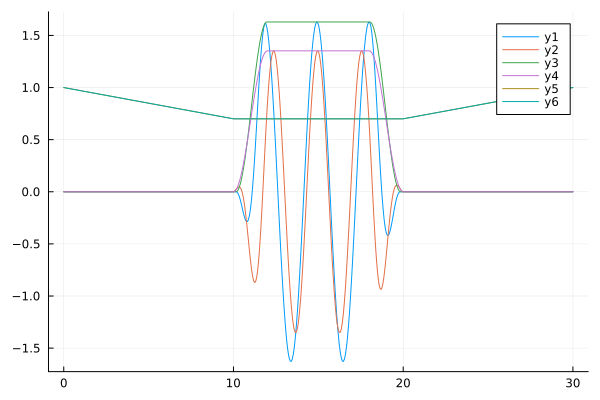

In [66]:
times = LinRange(0,30.0,500)

plot(times,[[pulse(p_new,t) for t in times],
            [pulse(p,t) for t in times],
            [pulse(p_new .* mask,t) for t in times],
            [pulse(p.*mask,t) for t in times],
            [alpha(p,t) for t in times],
            [alpha(p,t) for t in times]])

In [105]:
res

 * Status: success (objective increased between iterations)

 * Candidate solution
    Final objective value:     4.049066e-06

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.01e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.92e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.11e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.01e-08 ≰ 0.0e+00
    |g(x)|                 = 8.37e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   17249  (vs limit Inf)
    Iterations:    90
    f(x) calls:    568
    ∇f(x) calls:   568


In [33]:
forward_prob = ODEProblem(H_int!, ψ1s, (0.0, 30.0), p_new)
sol_new = solve(forward_prob, p=p_new, saveat=LinRange(0,30.0,1000), reltol=1e-12, abstol=1e-15)

retcode: Success
Interpolation: 1st order linear
t: 1000-element Vector{Float64}:
  0.0
  0.03003003003003003
  0.06006006006006006
  0.09009009009009009
  0.12012012012012012
  0.15015015015015015
  0.18018018018018017
  0.21021021021021022
  0.24024024024024024
  0.2702702702702703
  ⋮
 29.75975975975976
 29.78978978978979
 29.81981981981982
 29.84984984984985
 29.87987987987988
 29.90990990990991
 29.93993993993994
 29.96996996996997
 30.0
u: 1000-element Vector{Matrix{ComplexF64}}:
 [3.835480849665381e-11 - 7.448568444452389e-10im 5.919670547471689e-10 + 4.0373478021226716e-10im; -2.1635208373600882e-9 - 4.867871946156856e-9im 2.37965927760719e-9 + 4.578863147311388e-9im; … ; 2.6520736127120763e-9 - 4.6199030652284644e-9im 5.13155723935998e-9 + 5.439552438757918e-10im; 3.835485923058807e-11 - 7.448569196194522e-10im 5.919670104341769e-10 + 4.03734872812221e-10im]
 [4.991828555435591e-10 + 5.539971548524987e-10im -6.971225045330614e-10 + 1.6517020704722783e-10im; 4.969919186434265e-

In [34]:
occs = zeros(Float64,1000,2,2)
# tmpPot3 = buffer[3]
for (i,t) in enumerate(sol_new.t)
    tmpEs, tmpψs = eigs(KinPot12 + alpha(p_new,t) .* Potential3, nev=2, which=:SR)
    occs[i,:,:] = abs2.(tmpψs'*sol_new.u[i])
end

In [35]:
zero = cat(occs[:,:,1],abs.(1 .- sum(occs,dims=2)[:,1,[1]]),dims=2)
one = cat(occs[:,:,2],abs.(1 .- sum(occs,dims=2)[:,1,[2]]),dims=2);

In [ ]:
# The optimized run:
# [Tᵣ, Tₐ, Tₚ, αmin, ϕ, f, A, Φ_ext, λ]
# 1.8096066788458205
# 10.151415509076779
# 10.0
# 0.7265360232227066
# 2.819743639160394
# 2.0448639414672374
# 4.08982325027897
# 3.1258846903218442
# 0.03571156893603993

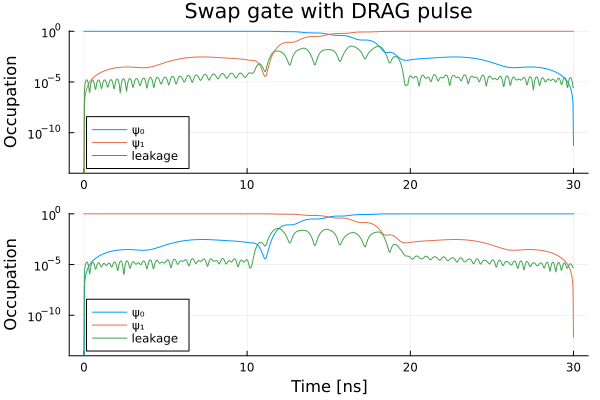

In [41]:
pzero = plot(sol_new.t,zero,title="Swap gate with DRAG pulse")
pone = plot(sol_new.t,one,xlabel="Time [ns]")

# plot(sol_new.t, [zero,one],yaxis=:log,ylims=(1e-10,1.1),layout=(2,1))
outputplot = plot(pzero,pone,
     layout=(2,1),
     yaxis=:log,
     ylims=(1e-14,1.1),
     legend=:bottomleft,
     label=["ψ₀" "ψ₁" "leakage"],
     ylabel="Occupation")

In [46]:
occs[end,:,:]

2×2 Matrix{Float64}:
 5.63061e-12  0.999995
 0.999997     7.02833e-13

In [47]:
# savefig(outputplot,"Figures/SwapOptPulseAndAlpha.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\JuliaStuff\\Figures\\SwapOptPulseAndAlpha.pdf"

In [76]:
tmpEs, tmpψs = eigs(KinPot12 + Potential3, nev=10, which=:SR)
(abs2.(tmpψs'*sol_new.u[end]))

10×2 Matrix{Float64}:
 5.63061e-12  0.999995
 0.999997     7.02833e-13
 9.20674e-7   6.29523e-8
 1.1388e-7    8.33036e-8
 4.68012e-7   3.64247e-7
 5.92302e-7   4.31459e-6
 2.11606e-7   5.4088e-8
 3.29642e-7   2.13459e-7
 1.38093e-8   1.2026e-8
 2.66817e-9   4.23309e-9

In [82]:
ψT = buffer[5]
a1 = - dropdims(ψT[:,1]'*ψ1s[:,2]*ψ1s[:,2]',dims=1)
a2 = - dropdims(ψT[:,2]'*ψ1s[:,1]*ψ1s[:,1]',dims=1)

u0_aug = cat(a1,a2,ψT[:,1],ψT[:,2],zeros(ComplexF64,length(p)),dims=1)
# u0_aug = cat(a1,ψT[:,1],zeros(ComplexF64,length(p)),dims=1)
aug_prob = ODEProblem(augmented_H_int!, u0_aug, (30.0,0.0), p)
aug_sol = solve(aug_prob, p=p, saveat=LinRange(30.0,0,1000), reltol=1e-8, abstol=1e-10)

retcode: Success
Interpolation: 1st order linear
t: 1000-element Vector{Float64}:
 30.0
 29.96996996996997
 29.93993993993994
 29.90990990990991
 29.87987987987988
 29.84984984984985
 29.81981981981982
 29.78978978978979
 29.75975975975976
 29.72972972972973
  ⋮
  0.2402402402402415
  0.2102102102102088
  0.18018018018017945
  0.1501501501501501
  0.12012012012012074
  0.09009009009009139
  0.060060060060058706
  0.030030030030029353
  0.0
u: 1000-element Vector{Vector{ComplexF64}}:
 [-2.1550678865726734e-10 - 6.8336091952853e-10im, -3.696165960607266e-9 - 3.600978794632986e-9im, -2.9557946471870003e-8 - 8.327691716462925e-9im, -1.39000398453211e-7 + 4.811115457856404e-8im, -2.5364870782616345e-7 + 5.041422455970714e-7im, 9.106757932209054e-7 + 1.6461973334083685e-6im, 5.668528972644916e-6 + 8.48459166781326e-8im, 5.710557423556579e-6 - 1.1799900949117443e-5im, -2.0533812574177715e-5 - 1.5814410929095027e-5im, -3.2900496310794674e-5 + 2.804551370764204e-5im  …  -2.723638512272976e-10 -

In [101]:
tmp = aug_sol.u[1][1:end-9]
i = 289
a1 = tmp[1:i]
a2 = tmp[i+1:2*i]
p1 = tmp[2*i+1:3*i]
p2 = tmp[3*i+1:4*i]
a1'*a1, a2'*a2, p1'*p1, p2'*p2

(0.9999971868181943 + 0.0im, 0.9999947150491304 + 0.0im, 0.9999998806045771 + 0.0im, 0.9999998811515642 + 0.0im)